In [11]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

import random
from skimage import io
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam,visualize_saliency

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop, SGD

In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'virussign-resnet50features.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from virussign-resnet50features.npy ...


In [8]:
resnet50features.shape

(9339, 1, 1, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [13]:
# Training top_model and saving min training loss weights
num_epochs=1000
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
early_stopping = EarlyStopping(verbose=1, patience=20, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='virussign-top-weights-min_loss-mlp-resnet50-Adam-1000epochs-earlystop.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
callbacks_list = [early_stopping, checkpointer]
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=callbacks_list)
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 8394 samples, validate on 945 samples
Epoch 1/1000
8394/8394 [==============================] - 0s - loss: 4.1752 - acc: 0.0315 - val_loss: 3.4550 - val_acc: 0.0402
Epoch 2/1000
8394/8394 [==============================] - 0s - loss: 3.4755 - acc: 0.0400 - val_loss: 2.7816 - val_acc: 0.2413
Epoch 3/1000
8394/8394 [==============================] - 0s - loss: 2.7946 - acc: 0.2354 - val_loss: 2.3472 - val_acc: 0.3556
Epoch 4/1000
8394/8394 [==============================] - 0s - loss: 2.3531 - acc: 0.3548 - val_loss: 2.0771 - val_acc: 0.5238
Epoch 5/1000
8394/8394 [==============================] - 0s - loss: 2.0766 - acc: 0.5230 - val_loss: 1.9097 - val_acc: 0.5323
Epoch 6/1000
8394/8394 [==============================] - 0s - loss: 1.9048 - acc: 0.5367 - val_loss: 1.7521 - val_acc: 0.5429
Epoch 7/1000
8394/8394 [==============================] - 0s - loss: 1.7444 - acc: 0.5449 - val_loss: 1.5807 - val_acc: 0.5683
Epoch 8/1000
8394/8394 [==============================] - 0s - l

8394/8394 [==============================] - 0s - loss: 0.1904 - acc: 0.9482 - val_loss: 0.2185 - val_acc: 0.9407
Epoch 65/1000
8394/8394 [==============================] - 0s - loss: 0.1883 - acc: 0.9485 - val_loss: 0.2166 - val_acc: 0.9418
Epoch 66/1000
8394/8394 [==============================] - 0s - loss: 0.1864 - acc: 0.9494 - val_loss: 0.2147 - val_acc: 0.9418
Epoch 67/1000
8394/8394 [==============================] - 0s - loss: 0.1844 - acc: 0.9494 - val_loss: 0.2129 - val_acc: 0.9418
Epoch 68/1000
8394/8394 [==============================] - 0s - loss: 0.1826 - acc: 0.9498 - val_loss: 0.2111 - val_acc: 0.9429
Epoch 69/1000
8394/8394 [==============================] - 0s - loss: 0.1808 - acc: 0.9500 - val_loss: 0.2092 - val_acc: 0.9429
Epoch 70/1000
8394/8394 [==============================] - 0s - loss: 0.1790 - acc: 0.9506 - val_loss: 0.2074 - val_acc: 0.9429
Epoch 71/1000
8394/8394 [==============================] - 0s - loss: 0.1773 - acc: 0.9509 - val_loss: 0.2057 - val_ac

8394/8394 [==============================] - 0s - loss: 0.1189 - acc: 0.9634 - val_loss: 0.1470 - val_acc: 0.9566
Epoch 128/1000
8394/8394 [==============================] - 0s - loss: 0.1182 - acc: 0.9639 - val_loss: 0.1463 - val_acc: 0.9566
Epoch 129/1000
8394/8394 [==============================] - 0s - loss: 0.1176 - acc: 0.9643 - val_loss: 0.1457 - val_acc: 0.9566
Epoch 130/1000
8394/8394 [==============================] - 0s - loss: 0.1169 - acc: 0.9643 - val_loss: 0.1451 - val_acc: 0.9566
Epoch 131/1000
8394/8394 [==============================] - 0s - loss: 0.1163 - acc: 0.9645 - val_loss: 0.1444 - val_acc: 0.9577
Epoch 132/1000
8394/8394 [==============================] - 0s - loss: 0.1157 - acc: 0.9646 - val_loss: 0.1438 - val_acc: 0.9577
Epoch 133/1000
8394/8394 [==============================] - 0s - loss: 0.1150 - acc: 0.9652 - val_loss: 0.1432 - val_acc: 0.9587
Epoch 134/1000
8394/8394 [==============================] - 0s - loss: 0.1144 - acc: 0.9659 - val_loss: 0.1426 -

8394/8394 [==============================] - 0s - loss: 0.0883 - acc: 0.9756 - val_loss: 0.1169 - val_acc: 0.9640
Epoch 191/1000
8394/8394 [==============================] - 0s - loss: 0.0879 - acc: 0.9757 - val_loss: 0.1166 - val_acc: 0.9640
Epoch 192/1000
8394/8394 [==============================] - 0s - loss: 0.0876 - acc: 0.9757 - val_loss: 0.1162 - val_acc: 0.9640
Epoch 193/1000
8394/8394 [==============================] - 0s - loss: 0.0872 - acc: 0.9761 - val_loss: 0.1159 - val_acc: 0.9640
Epoch 194/1000
8394/8394 [==============================] - 0s - loss: 0.0869 - acc: 0.9765 - val_loss: 0.1155 - val_acc: 0.9640
Epoch 195/1000
8394/8394 [==============================] - 0s - loss: 0.0865 - acc: 0.9768 - val_loss: 0.1152 - val_acc: 0.9651
Epoch 196/1000
8394/8394 [==============================] - 0s - loss: 0.0862 - acc: 0.9771 - val_loss: 0.1148 - val_acc: 0.9651
Epoch 197/1000
8394/8394 [==============================] - 0s - loss: 0.0859 - acc: 0.9772 - val_loss: 0.1145 -

8394/8394 [==============================] - 0s - loss: 0.0702 - acc: 0.9806 - val_loss: 0.0991 - val_acc: 0.9640
Epoch 254/1000
8394/8394 [==============================] - 0s - loss: 0.0700 - acc: 0.9806 - val_loss: 0.0989 - val_acc: 0.9640
Epoch 255/1000
8394/8394 [==============================] - 0s - loss: 0.0697 - acc: 0.9808 - val_loss: 0.0987 - val_acc: 0.9640
Epoch 256/1000
8394/8394 [==============================] - 0s - loss: 0.0695 - acc: 0.9808 - val_loss: 0.0985 - val_acc: 0.9640
Epoch 257/1000
8394/8394 [==============================] - 0s - loss: 0.0693 - acc: 0.9808 - val_loss: 0.0982 - val_acc: 0.9640
Epoch 258/1000
8394/8394 [==============================] - 0s - loss: 0.0691 - acc: 0.9808 - val_loss: 0.0980 - val_acc: 0.9640
Epoch 259/1000
8394/8394 [==============================] - 0s - loss: 0.0688 - acc: 0.9808 - val_loss: 0.0978 - val_acc: 0.9640
Epoch 260/1000
8394/8394 [==============================] - 0s - loss: 0.0686 - acc: 0.9808 - val_loss: 0.0976 -

8394/8394 [==============================] - 0s - loss: 0.0577 - acc: 0.9828 - val_loss: 0.0871 - val_acc: 0.9630
Epoch 317/1000
8394/8394 [==============================] - 0s - loss: 0.0576 - acc: 0.9828 - val_loss: 0.0869 - val_acc: 0.9630
Epoch 318/1000
8394/8394 [==============================] - 0s - loss: 0.0574 - acc: 0.9828 - val_loss: 0.0867 - val_acc: 0.9630
Epoch 319/1000
8394/8394 [==============================] - 0s - loss: 0.0572 - acc: 0.9828 - val_loss: 0.0866 - val_acc: 0.9630
Epoch 320/1000
8394/8394 [==============================] - 0s - loss: 0.0571 - acc: 0.9830 - val_loss: 0.0864 - val_acc: 0.9630
Epoch 321/1000
8394/8394 [==============================] - 0s - loss: 0.0569 - acc: 0.9830 - val_loss: 0.0863 - val_acc: 0.9630
Epoch 322/1000
8394/8394 [==============================] - 0s - loss: 0.0567 - acc: 0.9830 - val_loss: 0.0861 - val_acc: 0.9630
Epoch 323/1000
8394/8394 [==============================] - 0s - loss: 0.0566 - acc: 0.9830 - val_loss: 0.0859 -

8394/8394 [==============================] - 0s - loss: 0.0484 - acc: 0.9836 - val_loss: 0.0782 - val_acc: 0.9640
Epoch 380/1000
8394/8394 [==============================] - 0s - loss: 0.0483 - acc: 0.9837 - val_loss: 0.0781 - val_acc: 0.9640
Epoch 381/1000
8394/8394 [==============================] - 0s - loss: 0.0481 - acc: 0.9837 - val_loss: 0.0780 - val_acc: 0.9640
Epoch 382/1000
8394/8394 [==============================] - 0s - loss: 0.0480 - acc: 0.9837 - val_loss: 0.0778 - val_acc: 0.9640
Epoch 383/1000
8394/8394 [==============================] - 0s - loss: 0.0479 - acc: 0.9837 - val_loss: 0.0777 - val_acc: 0.9640
Epoch 384/1000
8394/8394 [==============================] - 0s - loss: 0.0477 - acc: 0.9837 - val_loss: 0.0776 - val_acc: 0.9640
Epoch 385/1000
8394/8394 [==============================] - 0s - loss: 0.0476 - acc: 0.9837 - val_loss: 0.0775 - val_acc: 0.9640
Epoch 386/1000
8394/8394 [==============================] - 0s - loss: 0.0475 - acc: 0.9837 - val_loss: 0.0774 -

8394/8394 [==============================] - 0s - loss: 0.0411 - acc: 0.9958 - val_loss: 0.0714 - val_acc: 0.9757
Epoch 443/1000
8394/8394 [==============================] - 0s - loss: 0.0410 - acc: 0.9958 - val_loss: 0.0714 - val_acc: 0.9757
Epoch 444/1000
8394/8394 [==============================] - 0s - loss: 0.0409 - acc: 0.9958 - val_loss: 0.0713 - val_acc: 0.9757
Epoch 445/1000
8394/8394 [==============================] - 0s - loss: 0.0408 - acc: 0.9958 - val_loss: 0.0712 - val_acc: 0.9757
Epoch 446/1000
8394/8394 [==============================] - 0s - loss: 0.0407 - acc: 0.9958 - val_loss: 0.0711 - val_acc: 0.9757
Epoch 447/1000
8394/8394 [==============================] - 0s - loss: 0.0406 - acc: 0.9958 - val_loss: 0.0710 - val_acc: 0.9757
Epoch 448/1000
8394/8394 [==============================] - 0s - loss: 0.0405 - acc: 0.9958 - val_loss: 0.0709 - val_acc: 0.9757
Epoch 449/1000
8394/8394 [==============================] - 0s - loss: 0.0404 - acc: 0.9958 - val_loss: 0.0708 -

8394/8394 [==============================] - 0s - loss: 0.0353 - acc: 0.9967 - val_loss: 0.0662 - val_acc: 0.9778
Epoch 506/1000
8394/8394 [==============================] - 0s - loss: 0.0352 - acc: 0.9967 - val_loss: 0.0661 - val_acc: 0.9778
Epoch 507/1000
8394/8394 [==============================] - 0s - loss: 0.0351 - acc: 0.9967 - val_loss: 0.0660 - val_acc: 0.9778
Epoch 508/1000
8394/8394 [==============================] - 0s - loss: 0.0350 - acc: 0.9967 - val_loss: 0.0660 - val_acc: 0.9778
Epoch 509/1000
8394/8394 [==============================] - 0s - loss: 0.0349 - acc: 0.9967 - val_loss: 0.0659 - val_acc: 0.9778
Epoch 510/1000
8394/8394 [==============================] - 0s - loss: 0.0348 - acc: 0.9967 - val_loss: 0.0658 - val_acc: 0.9778
Epoch 511/1000
8394/8394 [==============================] - 0s - loss: 0.0348 - acc: 0.9967 - val_loss: 0.0657 - val_acc: 0.9778
Epoch 512/1000
8394/8394 [==============================] - 0s - loss: 0.0347 - acc: 0.9968 - val_loss: 0.0657 -

8394/8394 [==============================] - 0s - loss: 0.0305 - acc: 0.9975 - val_loss: 0.0620 - val_acc: 0.9788
Epoch 569/1000
8394/8394 [==============================] - 0s - loss: 0.0305 - acc: 0.9975 - val_loss: 0.0620 - val_acc: 0.9788
Epoch 570/1000
8394/8394 [==============================] - 0s - loss: 0.0304 - acc: 0.9975 - val_loss: 0.0619 - val_acc: 0.9788
Epoch 571/1000
8394/8394 [==============================] - 0s - loss: 0.0303 - acc: 0.9975 - val_loss: 0.0618 - val_acc: 0.9788
Epoch 572/1000
8394/8394 [==============================] - 0s - loss: 0.0303 - acc: 0.9975 - val_loss: 0.0618 - val_acc: 0.9788
Epoch 573/1000
8394/8394 [==============================] - 0s - loss: 0.0302 - acc: 0.9975 - val_loss: 0.0617 - val_acc: 0.9788
Epoch 574/1000
8394/8394 [==============================] - 0s - loss: 0.0301 - acc: 0.9975 - val_loss: 0.0617 - val_acc: 0.9788
Epoch 575/1000
8394/8394 [==============================] - 0s - loss: 0.0301 - acc: 0.9975 - val_loss: 0.0616 -

8394/8394 [==============================] - 0s - loss: 0.0266 - acc: 0.9982 - val_loss: 0.0587 - val_acc: 0.9788
Epoch 632/1000
8394/8394 [==============================] - 0s - loss: 0.0266 - acc: 0.9982 - val_loss: 0.0586 - val_acc: 0.9788
Epoch 633/1000
8394/8394 [==============================] - 0s - loss: 0.0265 - acc: 0.9982 - val_loss: 0.0586 - val_acc: 0.9788
Epoch 634/1000
8394/8394 [==============================] - 0s - loss: 0.0265 - acc: 0.9982 - val_loss: 0.0586 - val_acc: 0.9788
Epoch 635/1000
8394/8394 [==============================] - 0s - loss: 0.0264 - acc: 0.9982 - val_loss: 0.0585 - val_acc: 0.9788
Epoch 636/1000
8394/8394 [==============================] - 0s - loss: 0.0263 - acc: 0.9982 - val_loss: 0.0585 - val_acc: 0.9788
Epoch 637/1000
8394/8394 [==============================] - 0s - loss: 0.0263 - acc: 0.9982 - val_loss: 0.0584 - val_acc: 0.9788
Epoch 638/1000
8394/8394 [==============================] - 0s - loss: 0.0262 - acc: 0.9982 - val_loss: 0.0584 -

8394/8394 [==============================] - 0s - loss: 0.0234 - acc: 0.9989 - val_loss: 0.0560 - val_acc: 0.9788
Epoch 695/1000
8394/8394 [==============================] - 0s - loss: 0.0233 - acc: 0.9989 - val_loss: 0.0560 - val_acc: 0.9788
Epoch 696/1000
8394/8394 [==============================] - 0s - loss: 0.0233 - acc: 0.9989 - val_loss: 0.0560 - val_acc: 0.9788
Epoch 697/1000
8394/8394 [==============================] - 0s - loss: 0.0232 - acc: 0.9989 - val_loss: 0.0559 - val_acc: 0.9788
Epoch 698/1000
8394/8394 [==============================] - 0s - loss: 0.0232 - acc: 0.9989 - val_loss: 0.0559 - val_acc: 0.9788
Epoch 699/1000
8394/8394 [==============================] - 0s - loss: 0.0232 - acc: 0.9989 - val_loss: 0.0559 - val_acc: 0.9788
Epoch 700/1000
8394/8394 [==============================] - 0s - loss: 0.0231 - acc: 0.9989 - val_loss: 0.0558 - val_acc: 0.9788
Epoch 701/1000
8394/8394 [==============================] - 0s - loss: 0.0231 - acc: 0.9989 - val_loss: 0.0558 -

8394/8394 [==============================] - 0s - loss: 0.0207 - acc: 0.9993 - val_loss: 0.0539 - val_acc: 0.9788
Epoch 758/1000
8394/8394 [==============================] - 0s - loss: 0.0206 - acc: 0.9993 - val_loss: 0.0539 - val_acc: 0.9788
Epoch 759/1000
8394/8394 [==============================] - 0s - loss: 0.0206 - acc: 0.9993 - val_loss: 0.0539 - val_acc: 0.9788
Epoch 760/1000
8394/8394 [==============================] - 0s - loss: 0.0205 - acc: 0.9993 - val_loss: 0.0538 - val_acc: 0.9788
Epoch 761/1000
8394/8394 [==============================] - 0s - loss: 0.0205 - acc: 0.9993 - val_loss: 0.0538 - val_acc: 0.9788
Epoch 762/1000
8394/8394 [==============================] - 0s - loss: 0.0205 - acc: 0.9993 - val_loss: 0.0538 - val_acc: 0.9788
Epoch 763/1000
8394/8394 [==============================] - 0s - loss: 0.0204 - acc: 0.9993 - val_loss: 0.0538 - val_acc: 0.9788
Epoch 764/1000
8394/8394 [==============================] - 0s - loss: 0.0204 - acc: 0.9993 - val_loss: 0.0537 -

8394/8394 [==============================] - 0s - loss: 0.0184 - acc: 0.9993 - val_loss: 0.0523 - val_acc: 0.9799
Epoch 821/1000
8394/8394 [==============================] - 0s - loss: 0.0183 - acc: 0.9993 - val_loss: 0.0522 - val_acc: 0.9799
Epoch 822/1000
8394/8394 [==============================] - 0s - loss: 0.0183 - acc: 0.9993 - val_loss: 0.0522 - val_acc: 0.9799
Epoch 823/1000
8394/8394 [==============================] - 0s - loss: 0.0183 - acc: 0.9993 - val_loss: 0.0522 - val_acc: 0.9799
Epoch 824/1000
8394/8394 [==============================] - 0s - loss: 0.0182 - acc: 0.9993 - val_loss: 0.0522 - val_acc: 0.9799
Epoch 825/1000
8394/8394 [==============================] - 0s - loss: 0.0182 - acc: 0.9993 - val_loss: 0.0521 - val_acc: 0.9799
Epoch 826/1000
8394/8394 [==============================] - 0s - loss: 0.0182 - acc: 0.9994 - val_loss: 0.0521 - val_acc: 0.9799
Epoch 827/1000
8394/8394 [==============================] - 0s - loss: 0.0181 - acc: 0.9994 - val_loss: 0.0521 -

8394/8394 [==============================] - 0s - loss: 0.0164 - acc: 0.9995 - val_loss: 0.0509 - val_acc: 0.9799
Epoch 884/1000
8394/8394 [==============================] - 0s - loss: 0.0164 - acc: 0.9995 - val_loss: 0.0509 - val_acc: 0.9799
Epoch 885/1000
8394/8394 [==============================] - 0s - loss: 0.0163 - acc: 0.9995 - val_loss: 0.0509 - val_acc: 0.9799
Epoch 886/1000
8394/8394 [==============================] - 0s - loss: 0.0163 - acc: 0.9995 - val_loss: 0.0509 - val_acc: 0.9810
Epoch 887/1000
8394/8394 [==============================] - 0s - loss: 0.0163 - acc: 0.9995 - val_loss: 0.0508 - val_acc: 0.9810
Epoch 888/1000
8394/8394 [==============================] - 0s - loss: 0.0163 - acc: 0.9995 - val_loss: 0.0508 - val_acc: 0.9810
Epoch 889/1000
8394/8394 [==============================] - 0s - loss: 0.0162 - acc: 0.9995 - val_loss: 0.0508 - val_acc: 0.9810
Epoch 890/1000
8394/8394 [==============================] - 0s - loss: 0.0162 - acc: 0.9995 - val_loss: 0.0508 -

8394/8394 [==============================] - 0s - loss: 0.0147 - acc: 0.9995 - val_loss: 0.0499 - val_acc: 0.9810
Epoch 947/1000
8394/8394 [==============================] - 0s - loss: 0.0147 - acc: 0.9995 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 948/1000
8394/8394 [==============================] - 0s - loss: 0.0147 - acc: 0.9995 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 949/1000
8394/8394 [==============================] - 0s - loss: 0.0147 - acc: 0.9995 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 950/1000
8394/8394 [==============================] - 0s - loss: 0.0146 - acc: 0.9995 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 951/1000
8394/8394 [==============================] - 0s - loss: 0.0146 - acc: 0.9995 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 952/1000
8394/8394 [==============================] - 0s - loss: 0.0146 - acc: 0.9995 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 953/1000
8394/8394 [==============================] - 0s - loss: 0.0146 - acc: 0.9995 - val_loss: 0.0498 -

8397/8397 [==============================] - 0s - loss: 1.5301 - acc: 0.5757 - val_loss: 1.3809 - val_acc: 0.6051
Epoch 10/1000
8397/8397 [==============================] - 0s - loss: 1.3689 - acc: 0.6062 - val_loss: 1.2415 - val_acc: 0.7187
Epoch 11/1000
8397/8397 [==============================] - 0s - loss: 1.2297 - acc: 0.7235 - val_loss: 1.1360 - val_acc: 0.7548
Epoch 12/1000
8397/8397 [==============================] - 0s - loss: 1.1243 - acc: 0.7532 - val_loss: 1.0513 - val_acc: 0.8100
Epoch 13/1000
8397/8397 [==============================] - 0s - loss: 1.0395 - acc: 0.8105 - val_loss: 0.9746 - val_acc: 0.8238
Epoch 14/1000
8397/8397 [==============================] - 0s - loss: 0.9629 - acc: 0.8258 - val_loss: 0.9031 - val_acc: 0.8344
Epoch 15/1000
8397/8397 [==============================] - 0s - loss: 0.8917 - acc: 0.8321 - val_loss: 0.8385 - val_acc: 0.8386
Epoch 16/1000
8397/8397 [==============================] - 0s - loss: 0.8277 - acc: 0.8402 - val_loss: 0.7813 - val_ac

8397/8397 [==============================] - 0s - loss: 0.1894 - acc: 0.9542 - val_loss: 0.2030 - val_acc: 0.9448
Epoch 74/1000
8397/8397 [==============================] - 0s - loss: 0.1878 - acc: 0.9546 - val_loss: 0.2015 - val_acc: 0.9469
Epoch 75/1000
8397/8397 [==============================] - 0s - loss: 0.1862 - acc: 0.9553 - val_loss: 0.2001 - val_acc: 0.9469
Epoch 76/1000
8397/8397 [==============================] - 0s - loss: 0.1846 - acc: 0.9555 - val_loss: 0.1987 - val_acc: 0.9469
Epoch 77/1000
8397/8397 [==============================] - 0s - loss: 0.1831 - acc: 0.9557 - val_loss: 0.1974 - val_acc: 0.9459
Epoch 78/1000
8397/8397 [==============================] - 0s - loss: 0.1817 - acc: 0.9558 - val_loss: 0.1962 - val_acc: 0.9459
Epoch 79/1000
8397/8397 [==============================] - 0s - loss: 0.1803 - acc: 0.9562 - val_loss: 0.1950 - val_acc: 0.9459
Epoch 80/1000
8397/8397 [==============================] - 0s - loss: 0.1789 - acc: 0.9563 - val_loss: 0.1938 - val_ac

8397/8397 [==============================] - 0s - loss: 0.1291 - acc: 0.9649 - val_loss: 0.1486 - val_acc: 0.9544
Epoch 137/1000
8397/8397 [==============================] - 0s - loss: 0.1285 - acc: 0.9650 - val_loss: 0.1481 - val_acc: 0.9544
Epoch 138/1000
8397/8397 [==============================] - 0s - loss: 0.1279 - acc: 0.9651 - val_loss: 0.1475 - val_acc: 0.9544
Epoch 139/1000
8397/8397 [==============================] - 0s - loss: 0.1273 - acc: 0.9652 - val_loss: 0.1470 - val_acc: 0.9544
Epoch 140/1000
8397/8397 [==============================] - 0s - loss: 0.1267 - acc: 0.9652 - val_loss: 0.1465 - val_acc: 0.9554
Epoch 141/1000
8397/8397 [==============================] - 0s - loss: 0.1261 - acc: 0.9652 - val_loss: 0.1460 - val_acc: 0.9554
Epoch 142/1000
8397/8397 [==============================] - 0s - loss: 0.1256 - acc: 0.9653 - val_loss: 0.1455 - val_acc: 0.9554
Epoch 143/1000
8397/8397 [==============================] - 0s - loss: 0.1250 - acc: 0.9653 - val_loss: 0.1450 -

8397/8397 [==============================] - 0s - loss: 0.1007 - acc: 0.9711 - val_loss: 0.1238 - val_acc: 0.9586
Epoch 200/1000
8397/8397 [==============================] - 0s - loss: 0.1003 - acc: 0.9711 - val_loss: 0.1236 - val_acc: 0.9586
Epoch 201/1000
8397/8397 [==============================] - 0s - loss: 0.1000 - acc: 0.9712 - val_loss: 0.1233 - val_acc: 0.9586
Epoch 202/1000
8397/8397 [==============================] - 0s - loss: 0.0997 - acc: 0.9713 - val_loss: 0.1230 - val_acc: 0.9586
Epoch 203/1000
8397/8397 [==============================] - 0s - loss: 0.0993 - acc: 0.9713 - val_loss: 0.1227 - val_acc: 0.9586
Epoch 204/1000
8397/8397 [==============================] - 0s - loss: 0.0990 - acc: 0.9713 - val_loss: 0.1224 - val_acc: 0.9586
Epoch 205/1000
8397/8397 [==============================] - 0s - loss: 0.0987 - acc: 0.9713 - val_loss: 0.1221 - val_acc: 0.9586
Epoch 206/1000
8397/8397 [==============================] - 0s - loss: 0.0983 - acc: 0.9713 - val_loss: 0.1219 -

8397/8397 [==============================] - 0s - loss: 0.0833 - acc: 0.9751 - val_loss: 0.1093 - val_acc: 0.9607
Epoch 263/1000
8397/8397 [==============================] - 0s - loss: 0.0831 - acc: 0.9755 - val_loss: 0.1091 - val_acc: 0.9607
Epoch 264/1000
8397/8397 [==============================] - 0s - loss: 0.0828 - acc: 0.9756 - val_loss: 0.1089 - val_acc: 0.9607
Epoch 265/1000
8397/8397 [==============================] - 0s - loss: 0.0826 - acc: 0.9756 - val_loss: 0.1087 - val_acc: 0.9607
Epoch 266/1000
8397/8397 [==============================] - 0s - loss: 0.0824 - acc: 0.9756 - val_loss: 0.1085 - val_acc: 0.9607
Epoch 267/1000
8397/8397 [==============================] - 0s - loss: 0.0822 - acc: 0.9757 - val_loss: 0.1084 - val_acc: 0.9607
Epoch 268/1000
8397/8397 [==============================] - 0s - loss: 0.0820 - acc: 0.9757 - val_loss: 0.1082 - val_acc: 0.9607
Epoch 269/1000
8397/8397 [==============================] - 0s - loss: 0.0817 - acc: 0.9758 - val_loss: 0.1080 -

8397/8397 [==============================] - 0s - loss: 0.0713 - acc: 0.9820 - val_loss: 0.0995 - val_acc: 0.9660
Epoch 326/1000
8397/8397 [==============================] - 0s - loss: 0.0711 - acc: 0.9823 - val_loss: 0.0993 - val_acc: 0.9660
Epoch 327/1000
8397/8397 [==============================] - 0s - loss: 0.0709 - acc: 0.9823 - val_loss: 0.0992 - val_acc: 0.9660
Epoch 328/1000
8397/8397 [==============================] - 0s - loss: 0.0708 - acc: 0.9823 - val_loss: 0.0991 - val_acc: 0.9660
Epoch 329/1000
8397/8397 [==============================] - 0s - loss: 0.0706 - acc: 0.9823 - val_loss: 0.0990 - val_acc: 0.9660
Epoch 330/1000
8397/8397 [==============================] - 0s - loss: 0.0704 - acc: 0.9823 - val_loss: 0.0988 - val_acc: 0.9660
Epoch 331/1000
8397/8397 [==============================] - 0s - loss: 0.0703 - acc: 0.9824 - val_loss: 0.0987 - val_acc: 0.9660
Epoch 332/1000
8397/8397 [==============================] - 0s - loss: 0.0701 - acc: 0.9824 - val_loss: 0.0986 -

8397/8397 [==============================] - 0s - loss: 0.0622 - acc: 0.9839 - val_loss: 0.0922 - val_acc: 0.9671
Epoch 389/1000
8397/8397 [==============================] - 0s - loss: 0.0621 - acc: 0.9839 - val_loss: 0.0921 - val_acc: 0.9671
Epoch 390/1000
8397/8397 [==============================] - 0s - loss: 0.0620 - acc: 0.9839 - val_loss: 0.0920 - val_acc: 0.9671
Epoch 391/1000
8397/8397 [==============================] - 0s - loss: 0.0618 - acc: 0.9839 - val_loss: 0.0919 - val_acc: 0.9671
Epoch 392/1000
8397/8397 [==============================] - 0s - loss: 0.0617 - acc: 0.9840 - val_loss: 0.0918 - val_acc: 0.9671
Epoch 393/1000
8397/8397 [==============================] - 0s - loss: 0.0616 - acc: 0.9840 - val_loss: 0.0917 - val_acc: 0.9671
Epoch 394/1000
8397/8397 [==============================] - 0s - loss: 0.0615 - acc: 0.9842 - val_loss: 0.0916 - val_acc: 0.9671
Epoch 395/1000
8397/8397 [==============================] - 0s - loss: 0.0613 - acc: 0.9842 - val_loss: 0.0915 -

8397/8397 [==============================] - 0s - loss: 0.0550 - acc: 0.9850 - val_loss: 0.0865 - val_acc: 0.9682
Epoch 452/1000
8397/8397 [==============================] - 0s - loss: 0.0549 - acc: 0.9851 - val_loss: 0.0864 - val_acc: 0.9682
Epoch 453/1000
8397/8397 [==============================] - 0s - loss: 0.0548 - acc: 0.9851 - val_loss: 0.0863 - val_acc: 0.9682
Epoch 454/1000
8397/8397 [==============================] - 0s - loss: 0.0547 - acc: 0.9852 - val_loss: 0.0862 - val_acc: 0.9682
Epoch 455/1000
8397/8397 [==============================] - 0s - loss: 0.0546 - acc: 0.9852 - val_loss: 0.0862 - val_acc: 0.9682
Epoch 456/1000
8397/8397 [==============================] - 0s - loss: 0.0545 - acc: 0.9852 - val_loss: 0.0861 - val_acc: 0.9682
Epoch 457/1000
8397/8397 [==============================] - 0s - loss: 0.0544 - acc: 0.9854 - val_loss: 0.0860 - val_acc: 0.9682
Epoch 458/1000
8397/8397 [==============================] - 0s - loss: 0.0543 - acc: 0.9854 - val_loss: 0.0859 -

8397/8397 [==============================] - 0s - loss: 0.0490 - acc: 0.9861 - val_loss: 0.0817 - val_acc: 0.9682
Epoch 515/1000
8397/8397 [==============================] - 0s - loss: 0.0489 - acc: 0.9861 - val_loss: 0.0816 - val_acc: 0.9682
Epoch 516/1000
8397/8397 [==============================] - 0s - loss: 0.0488 - acc: 0.9861 - val_loss: 0.0816 - val_acc: 0.9682
Epoch 517/1000
8397/8397 [==============================] - 0s - loss: 0.0487 - acc: 0.9861 - val_loss: 0.0815 - val_acc: 0.9682
Epoch 518/1000
8397/8397 [==============================] - 0s - loss: 0.0486 - acc: 0.9861 - val_loss: 0.0814 - val_acc: 0.9682
Epoch 519/1000
8397/8397 [==============================] - 0s - loss: 0.0485 - acc: 0.9861 - val_loss: 0.0814 - val_acc: 0.9682
Epoch 520/1000
8397/8397 [==============================] - 0s - loss: 0.0485 - acc: 0.9861 - val_loss: 0.0813 - val_acc: 0.9682
Epoch 521/1000
8397/8397 [==============================] - 0s - loss: 0.0484 - acc: 0.9861 - val_loss: 0.0812 -

8397/8397 [==============================] - 0s - loss: 0.0439 - acc: 0.9867 - val_loss: 0.0776 - val_acc: 0.9682
Epoch 578/1000
8397/8397 [==============================] - 0s - loss: 0.0438 - acc: 0.9867 - val_loss: 0.0776 - val_acc: 0.9682
Epoch 579/1000
8397/8397 [==============================] - 0s - loss: 0.0437 - acc: 0.9867 - val_loss: 0.0775 - val_acc: 0.9682
Epoch 580/1000
8397/8397 [==============================] - 0s - loss: 0.0436 - acc: 0.9867 - val_loss: 0.0774 - val_acc: 0.9682
Epoch 581/1000
8397/8397 [==============================] - 0s - loss: 0.0436 - acc: 0.9867 - val_loss: 0.0774 - val_acc: 0.9682
Epoch 582/1000
8397/8397 [==============================] - 0s - loss: 0.0435 - acc: 0.9867 - val_loss: 0.0773 - val_acc: 0.9682
Epoch 583/1000
8397/8397 [==============================] - 0s - loss: 0.0434 - acc: 0.9867 - val_loss: 0.0773 - val_acc: 0.9682
Epoch 584/1000
8397/8397 [==============================] - 0s - loss: 0.0433 - acc: 0.9867 - val_loss: 0.0772 -

8397/8397 [==============================] - 0s - loss: 0.0394 - acc: 0.9868 - val_loss: 0.0740 - val_acc: 0.9682
Epoch 641/1000
8397/8397 [==============================] - 0s - loss: 0.0394 - acc: 0.9868 - val_loss: 0.0740 - val_acc: 0.9682
Epoch 642/1000
8397/8397 [==============================] - 0s - loss: 0.0393 - acc: 0.9868 - val_loss: 0.0739 - val_acc: 0.9682
Epoch 643/1000
8397/8397 [==============================] - 0s - loss: 0.0392 - acc: 0.9868 - val_loss: 0.0739 - val_acc: 0.9682
Epoch 644/1000
8397/8397 [==============================] - 0s - loss: 0.0392 - acc: 0.9868 - val_loss: 0.0738 - val_acc: 0.9682
Epoch 645/1000
8397/8397 [==============================] - 0s - loss: 0.0391 - acc: 0.9868 - val_loss: 0.0738 - val_acc: 0.9682
Epoch 646/1000
8397/8397 [==============================] - 0s - loss: 0.0390 - acc: 0.9868 - val_loss: 0.0737 - val_acc: 0.9682
Epoch 647/1000
8397/8397 [==============================] - 0s - loss: 0.0390 - acc: 0.9868 - val_loss: 0.0737 -

8397/8397 [==============================] - 0s - loss: 0.0355 - acc: 0.9870 - val_loss: 0.0709 - val_acc: 0.9682
Epoch 704/1000
8397/8397 [==============================] - 0s - loss: 0.0355 - acc: 0.9870 - val_loss: 0.0708 - val_acc: 0.9682
Epoch 705/1000
8397/8397 [==============================] - 0s - loss: 0.0354 - acc: 0.9870 - val_loss: 0.0708 - val_acc: 0.9682
Epoch 706/1000
8397/8397 [==============================] - 0s - loss: 0.0354 - acc: 0.9870 - val_loss: 0.0708 - val_acc: 0.9682
Epoch 707/1000
8397/8397 [==============================] - 0s - loss: 0.0353 - acc: 0.9870 - val_loss: 0.0707 - val_acc: 0.9682
Epoch 708/1000
8397/8397 [==============================] - 0s - loss: 0.0352 - acc: 0.9870 - val_loss: 0.0707 - val_acc: 0.9682
Epoch 709/1000
8397/8397 [==============================] - 0s - loss: 0.0352 - acc: 0.9870 - val_loss: 0.0706 - val_acc: 0.9682
Epoch 710/1000
8397/8397 [==============================] - 0s - loss: 0.0351 - acc: 0.9870 - val_loss: 0.0706 -

8397/8397 [==============================] - 0s - loss: 0.0321 - acc: 0.9874 - val_loss: 0.0681 - val_acc: 0.9682
Epoch 767/1000
8397/8397 [==============================] - 0s - loss: 0.0321 - acc: 0.9874 - val_loss: 0.0681 - val_acc: 0.9682
Epoch 768/1000
8397/8397 [==============================] - 0s - loss: 0.0320 - acc: 0.9874 - val_loss: 0.0680 - val_acc: 0.9682
Epoch 769/1000
8397/8397 [==============================] - 0s - loss: 0.0319 - acc: 0.9874 - val_loss: 0.0680 - val_acc: 0.9682
Epoch 770/1000
8397/8397 [==============================] - 0s - loss: 0.0319 - acc: 0.9875 - val_loss: 0.0680 - val_acc: 0.9682
Epoch 771/1000
8397/8397 [==============================] - 0s - loss: 0.0318 - acc: 0.9875 - val_loss: 0.0679 - val_acc: 0.9682
Epoch 772/1000
8397/8397 [==============================] - 0s - loss: 0.0318 - acc: 0.9875 - val_loss: 0.0679 - val_acc: 0.9682
Epoch 773/1000
8397/8397 [==============================] - 0s - loss: 0.0317 - acc: 0.9875 - val_loss: 0.0678 -

8397/8397 [==============================] - 0s - loss: 0.0291 - acc: 0.9875 - val_loss: 0.0657 - val_acc: 0.9682
Epoch 830/1000
8397/8397 [==============================] - 0s - loss: 0.0290 - acc: 0.9875 - val_loss: 0.0656 - val_acc: 0.9682
Epoch 831/1000
8397/8397 [==============================] - 0s - loss: 0.0290 - acc: 0.9875 - val_loss: 0.0656 - val_acc: 0.9682
Epoch 832/1000
8397/8397 [==============================] - 0s - loss: 0.0289 - acc: 0.9875 - val_loss: 0.0656 - val_acc: 0.9682
Epoch 833/1000
8397/8397 [==============================] - 0s - loss: 0.0289 - acc: 0.9875 - val_loss: 0.0655 - val_acc: 0.9682
Epoch 834/1000
8397/8397 [==============================] - 0s - loss: 0.0288 - acc: 0.9875 - val_loss: 0.0655 - val_acc: 0.9682
Epoch 835/1000
8397/8397 [==============================] - 0s - loss: 0.0288 - acc: 0.9875 - val_loss: 0.0655 - val_acc: 0.9682
Epoch 836/1000
8397/8397 [==============================] - 0s - loss: 0.0288 - acc: 0.9876 - val_loss: 0.0654 -

8397/8397 [==============================] - 0s - loss: 0.0264 - acc: 0.9879 - val_loss: 0.0635 - val_acc: 0.9798
Epoch 893/1000
8397/8397 [==============================] - 0s - loss: 0.0263 - acc: 0.9992 - val_loss: 0.0635 - val_acc: 0.9798
Epoch 894/1000
8397/8397 [==============================] - 0s - loss: 0.0263 - acc: 0.9992 - val_loss: 0.0635 - val_acc: 0.9798
Epoch 895/1000
8397/8397 [==============================] - 0s - loss: 0.0263 - acc: 0.9992 - val_loss: 0.0634 - val_acc: 0.9798
Epoch 896/1000
8397/8397 [==============================] - 0s - loss: 0.0262 - acc: 0.9992 - val_loss: 0.0634 - val_acc: 0.9798
Epoch 897/1000
8397/8397 [==============================] - 0s - loss: 0.0262 - acc: 0.9992 - val_loss: 0.0634 - val_acc: 0.9798
Epoch 898/1000
8397/8397 [==============================] - 0s - loss: 0.0261 - acc: 0.9992 - val_loss: 0.0633 - val_acc: 0.9798
Epoch 899/1000
8397/8397 [==============================] - 0s - loss: 0.0261 - acc: 0.9992 - val_loss: 0.0633 -

8397/8397 [==============================] - 0s - loss: 0.0240 - acc: 0.9993 - val_loss: 0.0616 - val_acc: 0.9798
Epoch 956/1000
8397/8397 [==============================] - 0s - loss: 0.0240 - acc: 0.9993 - val_loss: 0.0616 - val_acc: 0.9798
Epoch 957/1000
8397/8397 [==============================] - 0s - loss: 0.0239 - acc: 0.9993 - val_loss: 0.0616 - val_acc: 0.9798
Epoch 958/1000
8397/8397 [==============================] - 0s - loss: 0.0239 - acc: 0.9993 - val_loss: 0.0616 - val_acc: 0.9798
Epoch 959/1000
8397/8397 [==============================] - 0s - loss: 0.0239 - acc: 0.9993 - val_loss: 0.0615 - val_acc: 0.9798
Epoch 960/1000
8397/8397 [==============================] - 0s - loss: 0.0238 - acc: 0.9993 - val_loss: 0.0615 - val_acc: 0.9798
Epoch 961/1000
8397/8397 [==============================] - 0s - loss: 0.0238 - acc: 0.9993 - val_loss: 0.0615 - val_acc: 0.9798
Epoch 962/1000
8397/8397 [==============================] - 0s - loss: 0.0237 - acc: 0.9993 - val_loss: 0.0614 -

8401/8401 [==============================] - 0s - loss: 0.7020 - acc: 0.8282 - val_loss: 0.6549 - val_acc: 0.8486
Epoch 19/1000
8401/8401 [==============================] - 0s - loss: 0.6543 - acc: 0.8519 - val_loss: 0.6129 - val_acc: 0.8625
Epoch 20/1000
8401/8401 [==============================] - 0s - loss: 0.6129 - acc: 0.8718 - val_loss: 0.5757 - val_acc: 0.8849
Epoch 21/1000
8401/8401 [==============================] - 0s - loss: 0.5764 - acc: 0.8863 - val_loss: 0.5429 - val_acc: 0.8891
Epoch 22/1000
8401/8401 [==============================] - 0s - loss: 0.5441 - acc: 0.8911 - val_loss: 0.5129 - val_acc: 0.8945
Epoch 23/1000
8401/8401 [==============================] - 0s - loss: 0.5144 - acc: 0.8941 - val_loss: 0.4860 - val_acc: 0.8955
Epoch 24/1000
8401/8401 [==============================] - 0s - loss: 0.4876 - acc: 0.8964 - val_loss: 0.4625 - val_acc: 0.8987
Epoch 25/1000
8401/8401 [==============================] - 0s - loss: 0.4638 - acc: 0.9007 - val_loss: 0.4424 - val_ac

8401/8401 [==============================] - 0s - loss: 0.1635 - acc: 0.9532 - val_loss: 0.1710 - val_acc: 0.9552
Epoch 83/1000
8401/8401 [==============================] - 0s - loss: 0.1622 - acc: 0.9531 - val_loss: 0.1697 - val_acc: 0.9563
Epoch 84/1000
8401/8401 [==============================] - 0s - loss: 0.1609 - acc: 0.9532 - val_loss: 0.1685 - val_acc: 0.9563
Epoch 85/1000
8401/8401 [==============================] - 0s - loss: 0.1597 - acc: 0.9535 - val_loss: 0.1673 - val_acc: 0.9563
Epoch 86/1000
8401/8401 [==============================] - 0s - loss: 0.1584 - acc: 0.9537 - val_loss: 0.1662 - val_acc: 0.9563
Epoch 87/1000
8401/8401 [==============================] - 0s - loss: 0.1572 - acc: 0.9539 - val_loss: 0.1650 - val_acc: 0.9574
Epoch 88/1000
8401/8401 [==============================] - 0s - loss: 0.1561 - acc: 0.9542 - val_loss: 0.1639 - val_acc: 0.9574
Epoch 89/1000
8401/8401 [==============================] - 0s - loss: 0.1549 - acc: 0.9544 - val_loss: 0.1629 - val_ac

8401/8401 [==============================] - 0s - loss: 0.1120 - acc: 0.9704 - val_loss: 0.1233 - val_acc: 0.9648
Epoch 146/1000
8401/8401 [==============================] - 0s - loss: 0.1114 - acc: 0.9704 - val_loss: 0.1229 - val_acc: 0.9648
Epoch 147/1000
8401/8401 [==============================] - 0s - loss: 0.1109 - acc: 0.9705 - val_loss: 0.1224 - val_acc: 0.9648
Epoch 148/1000
8401/8401 [==============================] - 0s - loss: 0.1104 - acc: 0.9707 - val_loss: 0.1219 - val_acc: 0.9648
Epoch 149/1000
8401/8401 [==============================] - 0s - loss: 0.1099 - acc: 0.9710 - val_loss: 0.1215 - val_acc: 0.9648
Epoch 150/1000
8401/8401 [==============================] - 0s - loss: 0.1094 - acc: 0.9710 - val_loss: 0.1210 - val_acc: 0.9659
Epoch 151/1000
8401/8401 [==============================] - 0s - loss: 0.1090 - acc: 0.9710 - val_loss: 0.1206 - val_acc: 0.9659
Epoch 152/1000
8401/8401 [==============================] - 0s - loss: 0.1085 - acc: 0.9710 - val_loss: 0.1202 -

8401/8401 [==============================] - 0s - loss: 0.0876 - acc: 0.9768 - val_loss: 0.1017 - val_acc: 0.9701
Epoch 209/1000
8401/8401 [==============================] - 0s - loss: 0.0873 - acc: 0.9769 - val_loss: 0.1015 - val_acc: 0.9701
Epoch 210/1000
8401/8401 [==============================] - 0s - loss: 0.0870 - acc: 0.9769 - val_loss: 0.1012 - val_acc: 0.9701
Epoch 211/1000
8401/8401 [==============================] - 0s - loss: 0.0867 - acc: 0.9770 - val_loss: 0.1010 - val_acc: 0.9701
Epoch 212/1000
8401/8401 [==============================] - 0s - loss: 0.0864 - acc: 0.9770 - val_loss: 0.1007 - val_acc: 0.9701
Epoch 213/1000
8401/8401 [==============================] - 0s - loss: 0.0862 - acc: 0.9770 - val_loss: 0.1005 - val_acc: 0.9701
Epoch 214/1000
8401/8401 [==============================] - 0s - loss: 0.0859 - acc: 0.9771 - val_loss: 0.1003 - val_acc: 0.9701
Epoch 215/1000
8401/8401 [==============================] - 0s - loss: 0.0856 - acc: 0.9773 - val_loss: 0.1000 -

8401/8401 [==============================] - 0s - loss: 0.0724 - acc: 0.9795 - val_loss: 0.0889 - val_acc: 0.9691
Epoch 272/1000
8401/8401 [==============================] - 0s - loss: 0.0722 - acc: 0.9795 - val_loss: 0.0888 - val_acc: 0.9691
Epoch 273/1000
8401/8401 [==============================] - 0s - loss: 0.0720 - acc: 0.9795 - val_loss: 0.0886 - val_acc: 0.9691
Epoch 274/1000
8401/8401 [==============================] - 0s - loss: 0.0718 - acc: 0.9795 - val_loss: 0.0884 - val_acc: 0.9691
Epoch 275/1000
8401/8401 [==============================] - 0s - loss: 0.0716 - acc: 0.9795 - val_loss: 0.0883 - val_acc: 0.9691
Epoch 276/1000
8401/8401 [==============================] - 0s - loss: 0.0714 - acc: 0.9796 - val_loss: 0.0881 - val_acc: 0.9691
Epoch 277/1000
8401/8401 [==============================] - 0s - loss: 0.0712 - acc: 0.9796 - val_loss: 0.0880 - val_acc: 0.9691
Epoch 278/1000
8401/8401 [==============================] - 0s - loss: 0.0711 - acc: 0.9796 - val_loss: 0.0878 -

8401/8401 [==============================] - 0s - loss: 0.0615 - acc: 0.9815 - val_loss: 0.0800 - val_acc: 0.9701
Epoch 335/1000
8401/8401 [==============================] - 0s - loss: 0.0614 - acc: 0.9815 - val_loss: 0.0799 - val_acc: 0.9701
Epoch 336/1000
8401/8401 [==============================] - 0s - loss: 0.0612 - acc: 0.9815 - val_loss: 0.0798 - val_acc: 0.9701
Epoch 337/1000
8401/8401 [==============================] - 0s - loss: 0.0611 - acc: 0.9815 - val_loss: 0.0796 - val_acc: 0.9701
Epoch 338/1000
8401/8401 [==============================] - 0s - loss: 0.0609 - acc: 0.9817 - val_loss: 0.0795 - val_acc: 0.9701
Epoch 339/1000
8401/8401 [==============================] - 0s - loss: 0.0608 - acc: 0.9817 - val_loss: 0.0794 - val_acc: 0.9701
Epoch 340/1000
8401/8401 [==============================] - 0s - loss: 0.0606 - acc: 0.9818 - val_loss: 0.0793 - val_acc: 0.9701
Epoch 341/1000
8401/8401 [==============================] - 0s - loss: 0.0605 - acc: 0.9818 - val_loss: 0.0792 -

8401/8401 [==============================] - 0s - loss: 0.0531 - acc: 0.9826 - val_loss: 0.0732 - val_acc: 0.9712
Epoch 398/1000
8401/8401 [==============================] - 0s - loss: 0.0529 - acc: 0.9826 - val_loss: 0.0731 - val_acc: 0.9712
Epoch 399/1000
8401/8401 [==============================] - 0s - loss: 0.0528 - acc: 0.9826 - val_loss: 0.0730 - val_acc: 0.9712
Epoch 400/1000
8401/8401 [==============================] - 0s - loss: 0.0527 - acc: 0.9826 - val_loss: 0.0729 - val_acc: 0.9723
Epoch 401/1000
8401/8401 [==============================] - 0s - loss: 0.0526 - acc: 0.9826 - val_loss: 0.0728 - val_acc: 0.9723
Epoch 402/1000
8401/8401 [==============================] - 0s - loss: 0.0525 - acc: 0.9827 - val_loss: 0.0727 - val_acc: 0.9723
Epoch 403/1000
8401/8401 [==============================] - 0s - loss: 0.0523 - acc: 0.9827 - val_loss: 0.0726 - val_acc: 0.9723
Epoch 404/1000
8401/8401 [==============================] - 0s - loss: 0.0522 - acc: 0.9827 - val_loss: 0.0725 -

8401/8401 [==============================] - 0s - loss: 0.0462 - acc: 0.9833 - val_loss: 0.0677 - val_acc: 0.9733
Epoch 461/1000
8401/8401 [==============================] - 0s - loss: 0.0461 - acc: 0.9833 - val_loss: 0.0676 - val_acc: 0.9733
Epoch 462/1000
8401/8401 [==============================] - 0s - loss: 0.0460 - acc: 0.9835 - val_loss: 0.0675 - val_acc: 0.9733
Epoch 463/1000
8401/8401 [==============================] - 0s - loss: 0.0459 - acc: 0.9835 - val_loss: 0.0675 - val_acc: 0.9733
Epoch 464/1000
8401/8401 [==============================] - 0s - loss: 0.0458 - acc: 0.9835 - val_loss: 0.0674 - val_acc: 0.9733
Epoch 465/1000
8401/8401 [==============================] - 0s - loss: 0.0457 - acc: 0.9835 - val_loss: 0.0673 - val_acc: 0.9733
Epoch 466/1000
8401/8401 [==============================] - 0s - loss: 0.0456 - acc: 0.9835 - val_loss: 0.0672 - val_acc: 0.9733
Epoch 467/1000
8401/8401 [==============================] - 0s - loss: 0.0455 - acc: 0.9836 - val_loss: 0.0672 -

8401/8401 [==============================] - 0s - loss: 0.0405 - acc: 0.9846 - val_loss: 0.0632 - val_acc: 0.9744
Epoch 524/1000
8401/8401 [==============================] - 0s - loss: 0.0405 - acc: 0.9846 - val_loss: 0.0631 - val_acc: 0.9744
Epoch 525/1000
8401/8401 [==============================] - 0s - loss: 0.0404 - acc: 0.9846 - val_loss: 0.0630 - val_acc: 0.9744
Epoch 526/1000
8401/8401 [==============================] - 0s - loss: 0.0403 - acc: 0.9846 - val_loss: 0.0630 - val_acc: 0.9744
Epoch 527/1000
8401/8401 [==============================] - 0s - loss: 0.0402 - acc: 0.9846 - val_loss: 0.0629 - val_acc: 0.9744
Epoch 528/1000
8401/8401 [==============================] - 0s - loss: 0.0401 - acc: 0.9846 - val_loss: 0.0629 - val_acc: 0.9744
Epoch 529/1000
8401/8401 [==============================] - 0s - loss: 0.0401 - acc: 0.9846 - val_loss: 0.0628 - val_acc: 0.9744
Epoch 530/1000
8401/8401 [==============================] - 0s - loss: 0.0400 - acc: 0.9846 - val_loss: 0.0627 -

8401/8401 [==============================] - 0s - loss: 0.0358 - acc: 0.9852 - val_loss: 0.0594 - val_acc: 0.9755
Epoch 587/1000
8401/8401 [==============================] - 0s - loss: 0.0357 - acc: 0.9852 - val_loss: 0.0593 - val_acc: 0.9755
Epoch 588/1000
8401/8401 [==============================] - 0s - loss: 0.0357 - acc: 0.9852 - val_loss: 0.0593 - val_acc: 0.9755
Epoch 589/1000
8401/8401 [==============================] - 0s - loss: 0.0356 - acc: 0.9852 - val_loss: 0.0592 - val_acc: 0.9755
Epoch 590/1000
8401/8401 [==============================] - 0s - loss: 0.0355 - acc: 0.9852 - val_loss: 0.0592 - val_acc: 0.9755
Epoch 591/1000
8401/8401 [==============================] - 0s - loss: 0.0354 - acc: 0.9854 - val_loss: 0.0591 - val_acc: 0.9872
Epoch 592/1000
8401/8401 [==============================] - 0s - loss: 0.0354 - acc: 0.9967 - val_loss: 0.0591 - val_acc: 0.9872
Epoch 593/1000
8401/8401 [==============================] - 0s - loss: 0.0353 - acc: 0.9967 - val_loss: 0.0590 -

8401/8401 [==============================] - 0s - loss: 0.0318 - acc: 0.9974 - val_loss: 0.0562 - val_acc: 0.9872
Epoch 650/1000
8401/8401 [==============================] - 0s - loss: 0.0317 - acc: 0.9974 - val_loss: 0.0562 - val_acc: 0.9872
Epoch 651/1000
8401/8401 [==============================] - 0s - loss: 0.0317 - acc: 0.9974 - val_loss: 0.0561 - val_acc: 0.9872
Epoch 652/1000
8401/8401 [==============================] - 0s - loss: 0.0316 - acc: 0.9975 - val_loss: 0.0561 - val_acc: 0.9872
Epoch 653/1000
8401/8401 [==============================] - 0s - loss: 0.0315 - acc: 0.9975 - val_loss: 0.0560 - val_acc: 0.9872
Epoch 654/1000
8401/8401 [==============================] - 0s - loss: 0.0315 - acc: 0.9975 - val_loss: 0.0560 - val_acc: 0.9872
Epoch 655/1000
8401/8401 [==============================] - 0s - loss: 0.0314 - acc: 0.9975 - val_loss: 0.0559 - val_acc: 0.9872
Epoch 656/1000
8401/8401 [==============================] - 0s - loss: 0.0314 - acc: 0.9976 - val_loss: 0.0559 -

8401/8401 [==============================] - 0s - loss: 0.0284 - acc: 0.9979 - val_loss: 0.0535 - val_acc: 0.9872
Epoch 713/1000
8401/8401 [==============================] - 0s - loss: 0.0283 - acc: 0.9979 - val_loss: 0.0535 - val_acc: 0.9872
Epoch 714/1000
8401/8401 [==============================] - 0s - loss: 0.0283 - acc: 0.9979 - val_loss: 0.0535 - val_acc: 0.9872
Epoch 715/1000
8401/8401 [==============================] - 0s - loss: 0.0282 - acc: 0.9979 - val_loss: 0.0534 - val_acc: 0.9872
Epoch 716/1000
8401/8401 [==============================] - 0s - loss: 0.0282 - acc: 0.9979 - val_loss: 0.0534 - val_acc: 0.9872
Epoch 717/1000
8401/8401 [==============================] - 0s - loss: 0.0281 - acc: 0.9979 - val_loss: 0.0533 - val_acc: 0.9872
Epoch 718/1000
8401/8401 [==============================] - 0s - loss: 0.0281 - acc: 0.9979 - val_loss: 0.0533 - val_acc: 0.9872
Epoch 719/1000
8401/8401 [==============================] - 0s - loss: 0.0280 - acc: 0.9979 - val_loss: 0.0533 -

8401/8401 [==============================] - 0s - loss: 0.0254 - acc: 0.9986 - val_loss: 0.0513 - val_acc: 0.9872
Epoch 776/1000
8401/8401 [==============================] - 0s - loss: 0.0254 - acc: 0.9986 - val_loss: 0.0512 - val_acc: 0.9872
Epoch 777/1000
8401/8401 [==============================] - 0s - loss: 0.0253 - acc: 0.9986 - val_loss: 0.0512 - val_acc: 0.9872
Epoch 778/1000
8401/8401 [==============================] - 0s - loss: 0.0253 - acc: 0.9986 - val_loss: 0.0512 - val_acc: 0.9872
Epoch 779/1000
8401/8401 [==============================] - 0s - loss: 0.0252 - acc: 0.9986 - val_loss: 0.0511 - val_acc: 0.9872
Epoch 780/1000
8401/8401 [==============================] - 0s - loss: 0.0252 - acc: 0.9986 - val_loss: 0.0511 - val_acc: 0.9872
Epoch 781/1000
8401/8401 [==============================] - 0s - loss: 0.0252 - acc: 0.9986 - val_loss: 0.0511 - val_acc: 0.9872
Epoch 782/1000
8401/8401 [==============================] - 0s - loss: 0.0251 - acc: 0.9986 - val_loss: 0.0510 -

8401/8401 [==============================] - 0s - loss: 0.0229 - acc: 0.9987 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 839/1000
8401/8401 [==============================] - 0s - loss: 0.0228 - acc: 0.9987 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 840/1000
8401/8401 [==============================] - 0s - loss: 0.0228 - acc: 0.9988 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 841/1000
8401/8401 [==============================] - 0s - loss: 0.0228 - acc: 0.9988 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 842/1000
8401/8401 [==============================] - 0s - loss: 0.0227 - acc: 0.9988 - val_loss: 0.0492 - val_acc: 0.9872
Epoch 843/1000
8401/8401 [==============================] - 0s - loss: 0.0227 - acc: 0.9988 - val_loss: 0.0492 - val_acc: 0.9872
Epoch 844/1000
8401/8401 [==============================] - 0s - loss: 0.0227 - acc: 0.9988 - val_loss: 0.0492 - val_acc: 0.9872
Epoch 845/1000
8401/8401 [==============================] - 0s - loss: 0.0226 - acc: 0.9988 - val_loss: 0.0491 -

8401/8401 [==============================] - 0s - loss: 0.0207 - acc: 0.9989 - val_loss: 0.0477 - val_acc: 0.9872
Epoch 902/1000
8401/8401 [==============================] - 0s - loss: 0.0206 - acc: 0.9989 - val_loss: 0.0477 - val_acc: 0.9872
Epoch 903/1000
8401/8401 [==============================] - 0s - loss: 0.0206 - acc: 0.9989 - val_loss: 0.0476 - val_acc: 0.9872
Epoch 904/1000
8401/8401 [==============================] - 0s - loss: 0.0206 - acc: 0.9989 - val_loss: 0.0476 - val_acc: 0.9872
Epoch 905/1000
8401/8401 [==============================] - 0s - loss: 0.0205 - acc: 0.9989 - val_loss: 0.0476 - val_acc: 0.9872
Epoch 906/1000
8401/8401 [==============================] - 0s - loss: 0.0205 - acc: 0.9989 - val_loss: 0.0476 - val_acc: 0.9872
Epoch 907/1000
8401/8401 [==============================] - 0s - loss: 0.0205 - acc: 0.9989 - val_loss: 0.0475 - val_acc: 0.9872
Epoch 908/1000
8401/8401 [==============================] - 0s - loss: 0.0204 - acc: 0.9989 - val_loss: 0.0475 -

8401/8401 [==============================] - 0s - loss: 0.0187 - acc: 0.9993 - val_loss: 0.0463 - val_acc: 0.9872
Epoch 965/1000
8401/8401 [==============================] - 0s - loss: 0.0187 - acc: 0.9993 - val_loss: 0.0463 - val_acc: 0.9872
Epoch 966/1000
8401/8401 [==============================] - 0s - loss: 0.0187 - acc: 0.9993 - val_loss: 0.0462 - val_acc: 0.9872
Epoch 967/1000
8401/8401 [==============================] - 0s - loss: 0.0187 - acc: 0.9993 - val_loss: 0.0462 - val_acc: 0.9872
Epoch 968/1000
8401/8401 [==============================] - 0s - loss: 0.0186 - acc: 0.9993 - val_loss: 0.0462 - val_acc: 0.9872
Epoch 969/1000
8401/8401 [==============================] - 0s - loss: 0.0186 - acc: 0.9993 - val_loss: 0.0462 - val_acc: 0.9872
Epoch 970/1000
8401/8401 [==============================] - 0s - loss: 0.0186 - acc: 0.9993 - val_loss: 0.0461 - val_acc: 0.9872
Epoch 971/1000
8401/8401 [==============================] - 0s - loss: 0.0185 - acc: 0.9993 - val_loss: 0.0461 -

8403/8403 [==============================] - 0s - loss: 0.5717 - acc: 0.8928 - val_loss: 0.5640 - val_acc: 0.8825
Epoch 28/1000
8403/8403 [==============================] - 0s - loss: 0.5506 - acc: 0.8823 - val_loss: 0.5462 - val_acc: 0.8761
Epoch 29/1000
8403/8403 [==============================] - 0s - loss: 0.5327 - acc: 0.8711 - val_loss: 0.5295 - val_acc: 0.8632
Epoch 30/1000
8403/8403 [==============================] - 0s - loss: 0.5160 - acc: 0.8662 - val_loss: 0.5128 - val_acc: 0.8600
Epoch 31/1000
8403/8403 [==============================] - 0s - loss: 0.4992 - acc: 0.8645 - val_loss: 0.4955 - val_acc: 0.8590
Epoch 32/1000
8403/8403 [==============================] - 0s - loss: 0.4820 - acc: 0.8656 - val_loss: 0.4785 - val_acc: 0.8686
Epoch 33/1000
8403/8403 [==============================] - 0s - loss: 0.4650 - acc: 0.8695 - val_loss: 0.4618 - val_acc: 0.8739
Epoch 34/1000
8403/8403 [==============================] - 0s - loss: 0.4483 - acc: 0.8765 - val_loss: 0.4451 - val_ac

8403/8403 [==============================] - 0s - loss: 0.1815 - acc: 0.9506 - val_loss: 0.1906 - val_acc: 0.9476
Epoch 92/1000
8403/8403 [==============================] - 0s - loss: 0.1802 - acc: 0.9505 - val_loss: 0.1892 - val_acc: 0.9466
Epoch 93/1000
8403/8403 [==============================] - 0s - loss: 0.1788 - acc: 0.9511 - val_loss: 0.1878 - val_acc: 0.9466
Epoch 94/1000
8403/8403 [==============================] - 0s - loss: 0.1775 - acc: 0.9514 - val_loss: 0.1864 - val_acc: 0.9466
Epoch 95/1000
8403/8403 [==============================] - 0s - loss: 0.1762 - acc: 0.9517 - val_loss: 0.1851 - val_acc: 0.9476
Epoch 96/1000
8403/8403 [==============================] - 0s - loss: 0.1749 - acc: 0.9520 - val_loss: 0.1837 - val_acc: 0.9476
Epoch 97/1000
8403/8403 [==============================] - 0s - loss: 0.1736 - acc: 0.9520 - val_loss: 0.1824 - val_acc: 0.9476
Epoch 98/1000
8403/8403 [==============================] - 0s - loss: 0.1724 - acc: 0.9525 - val_loss: 0.1811 - val_ac

8403/8403 [==============================] - 0s - loss: 0.1243 - acc: 0.9626 - val_loss: 0.1329 - val_acc: 0.9583
Epoch 155/1000
8403/8403 [==============================] - 0s - loss: 0.1237 - acc: 0.9630 - val_loss: 0.1323 - val_acc: 0.9583
Epoch 156/1000
8403/8403 [==============================] - 0s - loss: 0.1231 - acc: 0.9636 - val_loss: 0.1317 - val_acc: 0.9594
Epoch 157/1000
8403/8403 [==============================] - 0s - loss: 0.1225 - acc: 0.9639 - val_loss: 0.1312 - val_acc: 0.9605
Epoch 158/1000
8403/8403 [==============================] - 0s - loss: 0.1219 - acc: 0.9645 - val_loss: 0.1306 - val_acc: 0.9615
Epoch 159/1000
8403/8403 [==============================] - 0s - loss: 0.1214 - acc: 0.9647 - val_loss: 0.1300 - val_acc: 0.9615
Epoch 160/1000
8403/8403 [==============================] - 0s - loss: 0.1208 - acc: 0.9650 - val_loss: 0.1295 - val_acc: 0.9615
Epoch 161/1000
8403/8403 [==============================] - 0s - loss: 0.1202 - acc: 0.9653 - val_loss: 0.1289 -

8403/8403 [==============================] - 0s - loss: 0.0952 - acc: 0.9754 - val_loss: 0.1048 - val_acc: 0.9712
Epoch 218/1000
8403/8403 [==============================] - 0s - loss: 0.0949 - acc: 0.9756 - val_loss: 0.1045 - val_acc: 0.9722
Epoch 219/1000
8403/8403 [==============================] - 0s - loss: 0.0945 - acc: 0.9756 - val_loss: 0.1041 - val_acc: 0.9722
Epoch 220/1000
8403/8403 [==============================] - 0s - loss: 0.0942 - acc: 0.9757 - val_loss: 0.1038 - val_acc: 0.9733
Epoch 221/1000
8403/8403 [==============================] - 0s - loss: 0.0938 - acc: 0.9758 - val_loss: 0.1035 - val_acc: 0.9733
Epoch 222/1000
8403/8403 [==============================] - 0s - loss: 0.0935 - acc: 0.9758 - val_loss: 0.1031 - val_acc: 0.9733
Epoch 223/1000
8403/8403 [==============================] - 0s - loss: 0.0931 - acc: 0.9758 - val_loss: 0.1028 - val_acc: 0.9733
Epoch 224/1000
8403/8403 [==============================] - 0s - loss: 0.0928 - acc: 0.9760 - val_loss: 0.1025 -

8403/8403 [==============================] - 0s - loss: 0.0769 - acc: 0.9789 - val_loss: 0.0879 - val_acc: 0.9744
Epoch 281/1000
8403/8403 [==============================] - 0s - loss: 0.0767 - acc: 0.9792 - val_loss: 0.0877 - val_acc: 0.9744
Epoch 282/1000
8403/8403 [==============================] - 0s - loss: 0.0765 - acc: 0.9792 - val_loss: 0.0875 - val_acc: 0.9744
Epoch 283/1000
8403/8403 [==============================] - 0s - loss: 0.0762 - acc: 0.9792 - val_loss: 0.0873 - val_acc: 0.9744
Epoch 284/1000
8403/8403 [==============================] - 0s - loss: 0.0760 - acc: 0.9792 - val_loss: 0.0871 - val_acc: 0.9744
Epoch 285/1000
8403/8403 [==============================] - 0s - loss: 0.0758 - acc: 0.9793 - val_loss: 0.0869 - val_acc: 0.9744
Epoch 286/1000
8403/8403 [==============================] - 0s - loss: 0.0755 - acc: 0.9793 - val_loss: 0.0867 - val_acc: 0.9744
Epoch 287/1000
8403/8403 [==============================] - 0s - loss: 0.0753 - acc: 0.9793 - val_loss: 0.0865 -

8403/8403 [==============================] - 0s - loss: 0.0640 - acc: 0.9813 - val_loss: 0.0766 - val_acc: 0.9733
Epoch 344/1000
8403/8403 [==============================] - 0s - loss: 0.0639 - acc: 0.9813 - val_loss: 0.0765 - val_acc: 0.9733
Epoch 345/1000
8403/8403 [==============================] - 0s - loss: 0.0637 - acc: 0.9813 - val_loss: 0.0763 - val_acc: 0.9733
Epoch 346/1000
8403/8403 [==============================] - 0s - loss: 0.0635 - acc: 0.9813 - val_loss: 0.0762 - val_acc: 0.9733
Epoch 347/1000
8403/8403 [==============================] - 0s - loss: 0.0633 - acc: 0.9814 - val_loss: 0.0760 - val_acc: 0.9733
Epoch 348/1000
8403/8403 [==============================] - 0s - loss: 0.0632 - acc: 0.9814 - val_loss: 0.0759 - val_acc: 0.9733
Epoch 349/1000
8403/8403 [==============================] - 0s - loss: 0.0630 - acc: 0.9816 - val_loss: 0.0758 - val_acc: 0.9733
Epoch 350/1000
8403/8403 [==============================] - 0s - loss: 0.0628 - acc: 0.9816 - val_loss: 0.0756 -

8403/8403 [==============================] - 0s - loss: 0.0543 - acc: 0.9831 - val_loss: 0.0685 - val_acc: 0.9744
Epoch 407/1000
8403/8403 [==============================] - 0s - loss: 0.0541 - acc: 0.9831 - val_loss: 0.0684 - val_acc: 0.9744
Epoch 408/1000
8403/8403 [==============================] - 0s - loss: 0.0540 - acc: 0.9831 - val_loss: 0.0683 - val_acc: 0.9744
Epoch 409/1000
8403/8403 [==============================] - 0s - loss: 0.0539 - acc: 0.9831 - val_loss: 0.0682 - val_acc: 0.9744
Epoch 410/1000
8403/8403 [==============================] - 0s - loss: 0.0537 - acc: 0.9831 - val_loss: 0.0681 - val_acc: 0.9744
Epoch 411/1000
8403/8403 [==============================] - 0s - loss: 0.0536 - acc: 0.9831 - val_loss: 0.0680 - val_acc: 0.9744
Epoch 412/1000
8403/8403 [==============================] - 0s - loss: 0.0535 - acc: 0.9831 - val_loss: 0.0679 - val_acc: 0.9744
Epoch 413/1000
8403/8403 [==============================] - 0s - loss: 0.0533 - acc: 0.9831 - val_loss: 0.0678 -

8403/8403 [==============================] - 0s - loss: 0.0466 - acc: 0.9841 - val_loss: 0.0625 - val_acc: 0.9744
Epoch 470/1000
8403/8403 [==============================] - 0s - loss: 0.0465 - acc: 0.9841 - val_loss: 0.0624 - val_acc: 0.9744
Epoch 471/1000
8403/8403 [==============================] - 0s - loss: 0.0464 - acc: 0.9841 - val_loss: 0.0623 - val_acc: 0.9744
Epoch 472/1000
8403/8403 [==============================] - 0s - loss: 0.0463 - acc: 0.9841 - val_loss: 0.0622 - val_acc: 0.9744
Epoch 473/1000
8403/8403 [==============================] - 0s - loss: 0.0462 - acc: 0.9841 - val_loss: 0.0622 - val_acc: 0.9744
Epoch 474/1000
8403/8403 [==============================] - 0s - loss: 0.0461 - acc: 0.9841 - val_loss: 0.0621 - val_acc: 0.9744
Epoch 475/1000
8403/8403 [==============================] - 0s - loss: 0.0460 - acc: 0.9842 - val_loss: 0.0620 - val_acc: 0.9744
Epoch 476/1000
8403/8403 [==============================] - 0s - loss: 0.0458 - acc: 0.9842 - val_loss: 0.0619 -

8403/8403 [==============================] - 0s - loss: 0.0404 - acc: 0.9962 - val_loss: 0.0579 - val_acc: 0.9861
Epoch 533/1000
8403/8403 [==============================] - 0s - loss: 0.0403 - acc: 0.9962 - val_loss: 0.0578 - val_acc: 0.9861
Epoch 534/1000
8403/8403 [==============================] - 0s - loss: 0.0403 - acc: 0.9962 - val_loss: 0.0577 - val_acc: 0.9861
Epoch 535/1000
8403/8403 [==============================] - 0s - loss: 0.0402 - acc: 0.9962 - val_loss: 0.0577 - val_acc: 0.9861
Epoch 536/1000
8403/8403 [==============================] - 0s - loss: 0.0401 - acc: 0.9962 - val_loss: 0.0576 - val_acc: 0.9861
Epoch 537/1000
8403/8403 [==============================] - 0s - loss: 0.0400 - acc: 0.9963 - val_loss: 0.0575 - val_acc: 0.9861
Epoch 538/1000
8403/8403 [==============================] - 0s - loss: 0.0399 - acc: 0.9963 - val_loss: 0.0575 - val_acc: 0.9861
Epoch 539/1000
8403/8403 [==============================] - 0s - loss: 0.0398 - acc: 0.9963 - val_loss: 0.0574 -

8403/8403 [==============================] - 0s - loss: 0.0354 - acc: 0.9970 - val_loss: 0.0543 - val_acc: 0.9872
Epoch 596/1000
8403/8403 [==============================] - 0s - loss: 0.0353 - acc: 0.9970 - val_loss: 0.0542 - val_acc: 0.9872
Epoch 597/1000
8403/8403 [==============================] - 0s - loss: 0.0353 - acc: 0.9970 - val_loss: 0.0542 - val_acc: 0.9872
Epoch 598/1000
8403/8403 [==============================] - 0s - loss: 0.0352 - acc: 0.9970 - val_loss: 0.0541 - val_acc: 0.9872
Epoch 599/1000
8403/8403 [==============================] - 0s - loss: 0.0351 - acc: 0.9970 - val_loss: 0.0541 - val_acc: 0.9872
Epoch 600/1000
8403/8403 [==============================] - 0s - loss: 0.0350 - acc: 0.9970 - val_loss: 0.0540 - val_acc: 0.9872
Epoch 601/1000
8403/8403 [==============================] - 0s - loss: 0.0350 - acc: 0.9970 - val_loss: 0.0540 - val_acc: 0.9872
Epoch 602/1000
8403/8403 [==============================] - 0s - loss: 0.0349 - acc: 0.9970 - val_loss: 0.0539 -

8403/8403 [==============================] - 0s - loss: 0.0312 - acc: 0.9977 - val_loss: 0.0515 - val_acc: 0.9872
Epoch 659/1000
8403/8403 [==============================] - 0s - loss: 0.0312 - acc: 0.9977 - val_loss: 0.0514 - val_acc: 0.9872
Epoch 660/1000
8403/8403 [==============================] - 0s - loss: 0.0311 - acc: 0.9977 - val_loss: 0.0514 - val_acc: 0.9872
Epoch 661/1000
8403/8403 [==============================] - 0s - loss: 0.0311 - acc: 0.9977 - val_loss: 0.0514 - val_acc: 0.9872
Epoch 662/1000
8403/8403 [==============================] - 0s - loss: 0.0310 - acc: 0.9977 - val_loss: 0.0513 - val_acc: 0.9872
Epoch 663/1000
8403/8403 [==============================] - 0s - loss: 0.0309 - acc: 0.9977 - val_loss: 0.0513 - val_acc: 0.9872
Epoch 664/1000
8403/8403 [==============================] - 0s - loss: 0.0309 - acc: 0.9977 - val_loss: 0.0512 - val_acc: 0.9872
Epoch 665/1000
8403/8403 [==============================] - 0s - loss: 0.0308 - acc: 0.9977 - val_loss: 0.0512 -

8403/8403 [==============================] - 0s - loss: 0.0278 - acc: 0.9983 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 722/1000
8403/8403 [==============================] - 0s - loss: 0.0277 - acc: 0.9983 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 723/1000
8403/8403 [==============================] - 0s - loss: 0.0277 - acc: 0.9983 - val_loss: 0.0492 - val_acc: 0.9872
Epoch 724/1000
8403/8403 [==============================] - 0s - loss: 0.0276 - acc: 0.9983 - val_loss: 0.0492 - val_acc: 0.9872
Epoch 725/1000
8403/8403 [==============================] - 0s - loss: 0.0276 - acc: 0.9983 - val_loss: 0.0492 - val_acc: 0.9872
Epoch 726/1000
8403/8403 [==============================] - 0s - loss: 0.0275 - acc: 0.9983 - val_loss: 0.0491 - val_acc: 0.9872
Epoch 727/1000
8403/8403 [==============================] - 0s - loss: 0.0275 - acc: 0.9983 - val_loss: 0.0491 - val_acc: 0.9872
Epoch 728/1000
8403/8403 [==============================] - 0s - loss: 0.0274 - acc: 0.9983 - val_loss: 0.0491 -

8403/8403 [==============================] - 0s - loss: 0.0248 - acc: 0.9986 - val_loss: 0.0476 - val_acc: 0.9872
Epoch 785/1000
8403/8403 [==============================] - 0s - loss: 0.0248 - acc: 0.9986 - val_loss: 0.0475 - val_acc: 0.9872
Epoch 786/1000
8403/8403 [==============================] - 0s - loss: 0.0248 - acc: 0.9986 - val_loss: 0.0475 - val_acc: 0.9872
Epoch 787/1000
8403/8403 [==============================] - 0s - loss: 0.0247 - acc: 0.9986 - val_loss: 0.0475 - val_acc: 0.9872
Epoch 788/1000
8403/8403 [==============================] - 0s - loss: 0.0247 - acc: 0.9986 - val_loss: 0.0475 - val_acc: 0.9872
Epoch 789/1000
8403/8403 [==============================] - 0s - loss: 0.0246 - acc: 0.9986 - val_loss: 0.0474 - val_acc: 0.9872
Epoch 790/1000
8403/8403 [==============================] - 0s - loss: 0.0246 - acc: 0.9986 - val_loss: 0.0474 - val_acc: 0.9872
Epoch 791/1000
8403/8403 [==============================] - 0s - loss: 0.0246 - acc: 0.9986 - val_loss: 0.0474 -

8403/8403 [==============================] - 0s - loss: 0.0224 - acc: 0.9990 - val_loss: 0.0462 - val_acc: 0.9882
Epoch 848/1000
8403/8403 [==============================] - 0s - loss: 0.0223 - acc: 0.9990 - val_loss: 0.0462 - val_acc: 0.9882
Epoch 849/1000
8403/8403 [==============================] - 0s - loss: 0.0223 - acc: 0.9990 - val_loss: 0.0462 - val_acc: 0.9882
Epoch 850/1000
8403/8403 [==============================] - 0s - loss: 0.0222 - acc: 0.9990 - val_loss: 0.0462 - val_acc: 0.9882
Epoch 851/1000
8403/8403 [==============================] - 0s - loss: 0.0222 - acc: 0.9990 - val_loss: 0.0462 - val_acc: 0.9882
Epoch 852/1000
8403/8403 [==============================] - 0s - loss: 0.0222 - acc: 0.9990 - val_loss: 0.0461 - val_acc: 0.9882
Epoch 853/1000
8403/8403 [==============================] - 0s - loss: 0.0221 - acc: 0.9990 - val_loss: 0.0461 - val_acc: 0.9882
Epoch 854/1000
8403/8403 [==============================] - 0s - loss: 0.0221 - acc: 0.9990 - val_loss: 0.0461 -

8403/8403 [==============================] - 0s - loss: 0.0202 - acc: 0.9990 - val_loss: 0.0452 - val_acc: 0.9882
Epoch 911/1000
8403/8403 [==============================] - 0s - loss: 0.0202 - acc: 0.9990 - val_loss: 0.0452 - val_acc: 0.9882
Epoch 912/1000
8403/8403 [==============================] - 0s - loss: 0.0201 - acc: 0.9990 - val_loss: 0.0452 - val_acc: 0.9882
Epoch 913/1000
8403/8403 [==============================] - 0s - loss: 0.0201 - acc: 0.9990 - val_loss: 0.0451 - val_acc: 0.9882
Epoch 914/1000
8403/8403 [==============================] - 0s - loss: 0.0201 - acc: 0.9990 - val_loss: 0.0451 - val_acc: 0.9882
Epoch 915/1000
8403/8403 [==============================] - 0s - loss: 0.0200 - acc: 0.9990 - val_loss: 0.0451 - val_acc: 0.9882
Epoch 916/1000
8403/8403 [==============================] - 0s - loss: 0.0200 - acc: 0.9992 - val_loss: 0.0451 - val_acc: 0.9882
Epoch 917/1000
8403/8403 [==============================] - 0s - loss: 0.0200 - acc: 0.9992 - val_loss: 0.0451 -

8403/8403 [==============================] - 0s - loss: 0.0183 - acc: 0.9992 - val_loss: 0.0444 - val_acc: 0.9882
Epoch 974/1000
8403/8403 [==============================] - 0s - loss: 0.0183 - acc: 0.9992 - val_loss: 0.0444 - val_acc: 0.9882
Epoch 975/1000
8403/8403 [==============================] - 0s - loss: 0.0183 - acc: 0.9992 - val_loss: 0.0444 - val_acc: 0.9882
Epoch 976/1000
8403/8403 [==============================] - 0s - loss: 0.0183 - acc: 0.9992 - val_loss: 0.0443 - val_acc: 0.9882
Epoch 977/1000
8403/8403 [==============================] - 0s - loss: 0.0182 - acc: 0.9992 - val_loss: 0.0443 - val_acc: 0.9882
Epoch 978/1000
8403/8403 [==============================] - 0s - loss: 0.0182 - acc: 0.9992 - val_loss: 0.0443 - val_acc: 0.9882
Epoch 979/1000
8403/8403 [==============================] - 0s - loss: 0.0182 - acc: 0.9992 - val_loss: 0.0443 - val_acc: 0.9882
Epoch 980/1000
8403/8403 [==============================] - 0s - loss: 0.0181 - acc: 0.9992 - val_loss: 0.0443 -

8404/8404 [==============================] - 0s - loss: 0.3549 - acc: 0.8971 - val_loss: 0.3384 - val_acc: 0.8973
Epoch 37/1000
8404/8404 [==============================] - 0s - loss: 0.3444 - acc: 0.9064 - val_loss: 0.3295 - val_acc: 0.9102
Epoch 38/1000
8404/8404 [==============================] - 0s - loss: 0.3356 - acc: 0.9154 - val_loss: 0.3217 - val_acc: 0.9187
Epoch 39/1000
8404/8404 [==============================] - 0s - loss: 0.3281 - acc: 0.9230 - val_loss: 0.3147 - val_acc: 0.9262
Epoch 40/1000
8404/8404 [==============================] - 0s - loss: 0.3214 - acc: 0.9263 - val_loss: 0.3081 - val_acc: 0.9305
Epoch 41/1000
8404/8404 [==============================] - 0s - loss: 0.3152 - acc: 0.9272 - val_loss: 0.3017 - val_acc: 0.9294
Epoch 42/1000
8404/8404 [==============================] - 0s - loss: 0.3091 - acc: 0.9292 - val_loss: 0.2953 - val_acc: 0.9326
Epoch 43/1000
8404/8404 [==============================] - 0s - loss: 0.3029 - acc: 0.9316 - val_loss: 0.2888 - val_ac

8404/8404 [==============================] - 0s - loss: 0.1597 - acc: 0.9557 - val_loss: 0.1584 - val_acc: 0.9487
Epoch 101/1000
8404/8404 [==============================] - 0s - loss: 0.1586 - acc: 0.9557 - val_loss: 0.1575 - val_acc: 0.9487
Epoch 102/1000
8404/8404 [==============================] - 0s - loss: 0.1575 - acc: 0.9561 - val_loss: 0.1565 - val_acc: 0.9497
Epoch 103/1000
8404/8404 [==============================] - 0s - loss: 0.1565 - acc: 0.9564 - val_loss: 0.1556 - val_acc: 0.9508
Epoch 104/1000
8404/8404 [==============================] - 0s - loss: 0.1554 - acc: 0.9574 - val_loss: 0.1546 - val_acc: 0.9519
Epoch 105/1000
8404/8404 [==============================] - 0s - loss: 0.1544 - acc: 0.9579 - val_loss: 0.1537 - val_acc: 0.9519
Epoch 106/1000
8404/8404 [==============================] - 0s - loss: 0.1534 - acc: 0.9582 - val_loss: 0.1528 - val_acc: 0.9519
Epoch 107/1000
8404/8404 [==============================] - 0s - loss: 0.1524 - acc: 0.9589 - val_loss: 0.1520 -

8404/8404 [==============================] - 0s - loss: 0.1125 - acc: 0.9667 - val_loss: 0.1177 - val_acc: 0.9583
Epoch 164/1000
8404/8404 [==============================] - 0s - loss: 0.1120 - acc: 0.9668 - val_loss: 0.1173 - val_acc: 0.9583
Epoch 165/1000
8404/8404 [==============================] - 0s - loss: 0.1115 - acc: 0.9668 - val_loss: 0.1168 - val_acc: 0.9583
Epoch 166/1000
8404/8404 [==============================] - 0s - loss: 0.1110 - acc: 0.9672 - val_loss: 0.1164 - val_acc: 0.9604
Epoch 167/1000
8404/8404 [==============================] - 0s - loss: 0.1105 - acc: 0.9679 - val_loss: 0.1160 - val_acc: 0.9604
Epoch 168/1000
8404/8404 [==============================] - 0s - loss: 0.1100 - acc: 0.9682 - val_loss: 0.1156 - val_acc: 0.9604
Epoch 169/1000
8404/8404 [==============================] - 0s - loss: 0.1095 - acc: 0.9686 - val_loss: 0.1152 - val_acc: 0.9604
Epoch 170/1000
8404/8404 [==============================] - 0s - loss: 0.1090 - acc: 0.9689 - val_loss: 0.1148 -

8404/8404 [==============================] - 0s - loss: 0.0875 - acc: 0.9760 - val_loss: 0.0970 - val_acc: 0.9636
Epoch 227/1000
8404/8404 [==============================] - 0s - loss: 0.0872 - acc: 0.9760 - val_loss: 0.0968 - val_acc: 0.9636
Epoch 228/1000
8404/8404 [==============================] - 0s - loss: 0.0868 - acc: 0.9760 - val_loss: 0.0965 - val_acc: 0.9636
Epoch 229/1000
8404/8404 [==============================] - 0s - loss: 0.0865 - acc: 0.9760 - val_loss: 0.0963 - val_acc: 0.9636
Epoch 230/1000
8404/8404 [==============================] - 0s - loss: 0.0862 - acc: 0.9760 - val_loss: 0.0960 - val_acc: 0.9636
Epoch 231/1000
8404/8404 [==============================] - 0s - loss: 0.0859 - acc: 0.9760 - val_loss: 0.0958 - val_acc: 0.9636
Epoch 232/1000
8404/8404 [==============================] - 0s - loss: 0.0856 - acc: 0.9760 - val_loss: 0.0956 - val_acc: 0.9636
Epoch 233/1000
8404/8404 [==============================] - 0s - loss: 0.0853 - acc: 0.9760 - val_loss: 0.0953 -

8404/8404 [==============================] - 0s - loss: 0.0713 - acc: 0.9795 - val_loss: 0.0842 - val_acc: 0.9690
Epoch 290/1000
8404/8404 [==============================] - 0s - loss: 0.0710 - acc: 0.9795 - val_loss: 0.0841 - val_acc: 0.9690
Epoch 291/1000
8404/8404 [==============================] - 0s - loss: 0.0708 - acc: 0.9795 - val_loss: 0.0839 - val_acc: 0.9690
Epoch 292/1000
8404/8404 [==============================] - 0s - loss: 0.0706 - acc: 0.9795 - val_loss: 0.0837 - val_acc: 0.9690
Epoch 293/1000
8404/8404 [==============================] - 0s - loss: 0.0704 - acc: 0.9795 - val_loss: 0.0836 - val_acc: 0.9690
Epoch 294/1000
8404/8404 [==============================] - 0s - loss: 0.0702 - acc: 0.9795 - val_loss: 0.0834 - val_acc: 0.9690
Epoch 295/1000
8404/8404 [==============================] - 0s - loss: 0.0700 - acc: 0.9798 - val_loss: 0.0833 - val_acc: 0.9690
Epoch 296/1000
8404/8404 [==============================] - 0s - loss: 0.0698 - acc: 0.9798 - val_loss: 0.0831 -

8404/8404 [==============================] - 0s - loss: 0.0596 - acc: 0.9810 - val_loss: 0.0755 - val_acc: 0.9690
Epoch 353/1000
8404/8404 [==============================] - 0s - loss: 0.0594 - acc: 0.9810 - val_loss: 0.0753 - val_acc: 0.9690
Epoch 354/1000
8404/8404 [==============================] - 0s - loss: 0.0592 - acc: 0.9810 - val_loss: 0.0752 - val_acc: 0.9690
Epoch 355/1000
8404/8404 [==============================] - 0s - loss: 0.0591 - acc: 0.9810 - val_loss: 0.0751 - val_acc: 0.9690
Epoch 356/1000
8404/8404 [==============================] - 0s - loss: 0.0589 - acc: 0.9810 - val_loss: 0.0750 - val_acc: 0.9690
Epoch 357/1000
8404/8404 [==============================] - 0s - loss: 0.0588 - acc: 0.9810 - val_loss: 0.0749 - val_acc: 0.9690
Epoch 358/1000
8404/8404 [==============================] - 0s - loss: 0.0586 - acc: 0.9811 - val_loss: 0.0748 - val_acc: 0.9690
Epoch 359/1000
8404/8404 [==============================] - 0s - loss: 0.0585 - acc: 0.9811 - val_loss: 0.0746 -

8404/8404 [==============================] - 0s - loss: 0.0506 - acc: 0.9825 - val_loss: 0.0690 - val_acc: 0.9690
Epoch 416/1000
8404/8404 [==============================] - 0s - loss: 0.0505 - acc: 0.9825 - val_loss: 0.0690 - val_acc: 0.9690
Epoch 417/1000
8404/8404 [==============================] - 0s - loss: 0.0504 - acc: 0.9825 - val_loss: 0.0689 - val_acc: 0.9690
Epoch 418/1000
8404/8404 [==============================] - 0s - loss: 0.0502 - acc: 0.9825 - val_loss: 0.0688 - val_acc: 0.9690
Epoch 419/1000
8404/8404 [==============================] - 0s - loss: 0.0501 - acc: 0.9825 - val_loss: 0.0687 - val_acc: 0.9690
Epoch 420/1000
8404/8404 [==============================] - 0s - loss: 0.0500 - acc: 0.9825 - val_loss: 0.0686 - val_acc: 0.9690
Epoch 421/1000
8404/8404 [==============================] - 0s - loss: 0.0499 - acc: 0.9825 - val_loss: 0.0685 - val_acc: 0.9690
Epoch 422/1000
8404/8404 [==============================] - 0s - loss: 0.0498 - acc: 0.9825 - val_loss: 0.0684 -

8404/8404 [==============================] - 0s - loss: 0.0436 - acc: 0.9952 - val_loss: 0.0642 - val_acc: 0.9818
Epoch 479/1000
8404/8404 [==============================] - 0s - loss: 0.0435 - acc: 0.9954 - val_loss: 0.0641 - val_acc: 0.9818
Epoch 480/1000
8404/8404 [==============================] - 0s - loss: 0.0434 - acc: 0.9954 - val_loss: 0.0641 - val_acc: 0.9818
Epoch 481/1000
8404/8404 [==============================] - 0s - loss: 0.0433 - acc: 0.9954 - val_loss: 0.0640 - val_acc: 0.9818
Epoch 482/1000
8404/8404 [==============================] - 0s - loss: 0.0432 - acc: 0.9954 - val_loss: 0.0639 - val_acc: 0.9818
Epoch 483/1000
8404/8404 [==============================] - 0s - loss: 0.0431 - acc: 0.9954 - val_loss: 0.0639 - val_acc: 0.9818
Epoch 484/1000
8404/8404 [==============================] - 0s - loss: 0.0430 - acc: 0.9954 - val_loss: 0.0638 - val_acc: 0.9818
Epoch 485/1000
8404/8404 [==============================] - 0s - loss: 0.0429 - acc: 0.9954 - val_loss: 0.0638 -

8404/8404 [==============================] - 0s - loss: 0.0379 - acc: 0.9962 - val_loss: 0.0605 - val_acc: 0.9829
Epoch 542/1000
8404/8404 [==============================] - 0s - loss: 0.0378 - acc: 0.9962 - val_loss: 0.0605 - val_acc: 0.9829
Epoch 543/1000
8404/8404 [==============================] - 0s - loss: 0.0377 - acc: 0.9962 - val_loss: 0.0604 - val_acc: 0.9829
Epoch 544/1000
8404/8404 [==============================] - 0s - loss: 0.0376 - acc: 0.9962 - val_loss: 0.0604 - val_acc: 0.9829
Epoch 545/1000
8404/8404 [==============================] - 0s - loss: 0.0375 - acc: 0.9962 - val_loss: 0.0603 - val_acc: 0.9829
Epoch 546/1000
8404/8404 [==============================] - 0s - loss: 0.0375 - acc: 0.9962 - val_loss: 0.0602 - val_acc: 0.9829
Epoch 547/1000
8404/8404 [==============================] - 0s - loss: 0.0374 - acc: 0.9962 - val_loss: 0.0602 - val_acc: 0.9829
Epoch 548/1000
8404/8404 [==============================] - 0s - loss: 0.0373 - acc: 0.9962 - val_loss: 0.0601 -

8404/8404 [==============================] - 0s - loss: 0.0332 - acc: 0.9969 - val_loss: 0.0576 - val_acc: 0.9829
Epoch 605/1000
8404/8404 [==============================] - 0s - loss: 0.0332 - acc: 0.9969 - val_loss: 0.0576 - val_acc: 0.9829
Epoch 606/1000
8404/8404 [==============================] - 0s - loss: 0.0331 - acc: 0.9969 - val_loss: 0.0575 - val_acc: 0.9829
Epoch 607/1000
8404/8404 [==============================] - 0s - loss: 0.0330 - acc: 0.9969 - val_loss: 0.0575 - val_acc: 0.9829
Epoch 608/1000
8404/8404 [==============================] - 0s - loss: 0.0330 - acc: 0.9969 - val_loss: 0.0575 - val_acc: 0.9829
Epoch 609/1000
8404/8404 [==============================] - 0s - loss: 0.0329 - acc: 0.9969 - val_loss: 0.0574 - val_acc: 0.9829
Epoch 610/1000
8404/8404 [==============================] - 0s - loss: 0.0328 - acc: 0.9969 - val_loss: 0.0574 - val_acc: 0.9829
Epoch 611/1000
8404/8404 [==============================] - 0s - loss: 0.0328 - acc: 0.9969 - val_loss: 0.0573 -

8404/8404 [==============================] - 0s - loss: 0.0294 - acc: 0.9977 - val_loss: 0.0554 - val_acc: 0.9829
Epoch 668/1000
8404/8404 [==============================] - 0s - loss: 0.0293 - acc: 0.9977 - val_loss: 0.0553 - val_acc: 0.9829
Epoch 669/1000
8404/8404 [==============================] - 0s - loss: 0.0293 - acc: 0.9977 - val_loss: 0.0553 - val_acc: 0.9829
Epoch 670/1000
8404/8404 [==============================] - 0s - loss: 0.0292 - acc: 0.9977 - val_loss: 0.0553 - val_acc: 0.9829
Epoch 671/1000
8404/8404 [==============================] - 0s - loss: 0.0291 - acc: 0.9977 - val_loss: 0.0552 - val_acc: 0.9829
Epoch 672/1000
8404/8404 [==============================] - 0s - loss: 0.0291 - acc: 0.9977 - val_loss: 0.0552 - val_acc: 0.9829
Epoch 673/1000
8404/8404 [==============================] - 0s - loss: 0.0290 - acc: 0.9977 - val_loss: 0.0552 - val_acc: 0.9829
Epoch 674/1000
8404/8404 [==============================] - 0s - loss: 0.0290 - acc: 0.9977 - val_loss: 0.0551 -

8404/8404 [==============================] - 0s - loss: 0.0261 - acc: 0.9980 - val_loss: 0.0536 - val_acc: 0.9829
Epoch 731/1000
8404/8404 [==============================] - 0s - loss: 0.0261 - acc: 0.9980 - val_loss: 0.0535 - val_acc: 0.9829
Epoch 732/1000
8404/8404 [==============================] - 0s - loss: 0.0260 - acc: 0.9980 - val_loss: 0.0535 - val_acc: 0.9829
Epoch 733/1000
8404/8404 [==============================] - 0s - loss: 0.0260 - acc: 0.9980 - val_loss: 0.0535 - val_acc: 0.9829
Epoch 734/1000
8404/8404 [==============================] - 0s - loss: 0.0260 - acc: 0.9981 - val_loss: 0.0535 - val_acc: 0.9829
Epoch 735/1000
8404/8404 [==============================] - 0s - loss: 0.0259 - acc: 0.9981 - val_loss: 0.0534 - val_acc: 0.9829
Epoch 736/1000
8404/8404 [==============================] - 0s - loss: 0.0259 - acc: 0.9981 - val_loss: 0.0534 - val_acc: 0.9829
Epoch 737/1000
8404/8404 [==============================] - 0s - loss: 0.0258 - acc: 0.9981 - val_loss: 0.0534 -

8404/8404 [==============================] - 0s - loss: 0.0234 - acc: 0.9981 - val_loss: 0.0522 - val_acc: 0.9840
Epoch 794/1000
8404/8404 [==============================] - 0s - loss: 0.0234 - acc: 0.9981 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 795/1000
8404/8404 [==============================] - 0s - loss: 0.0233 - acc: 0.9981 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 796/1000
8404/8404 [==============================] - 0s - loss: 0.0233 - acc: 0.9981 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 797/1000
8404/8404 [==============================] - 0s - loss: 0.0232 - acc: 0.9981 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 798/1000
8404/8404 [==============================] - 0s - loss: 0.0232 - acc: 0.9981 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 799/1000
8404/8404 [==============================] - 0s - loss: 0.0232 - acc: 0.9981 - val_loss: 0.0520 - val_acc: 0.9840
Epoch 800/1000
8404/8404 [==============================] - 0s - loss: 0.0231 - acc: 0.9981 - val_loss: 0.0520 -

8404/8404 [==============================] - 0s - loss: 0.0211 - acc: 0.9985 - val_loss: 0.0510 - val_acc: 0.9840
Epoch 857/1000
8404/8404 [==============================] - 0s - loss: 0.0210 - acc: 0.9985 - val_loss: 0.0510 - val_acc: 0.9840
Epoch 858/1000
8404/8404 [==============================] - 0s - loss: 0.0210 - acc: 0.9985 - val_loss: 0.0510 - val_acc: 0.9840
Epoch 859/1000
8404/8404 [==============================] - 0s - loss: 0.0209 - acc: 0.9985 - val_loss: 0.0510 - val_acc: 0.9840
Epoch 860/1000
8404/8404 [==============================] - 0s - loss: 0.0209 - acc: 0.9985 - val_loss: 0.0510 - val_acc: 0.9840
Epoch 861/1000
8404/8404 [==============================] - 0s - loss: 0.0209 - acc: 0.9985 - val_loss: 0.0509 - val_acc: 0.9840
Epoch 862/1000
8404/8404 [==============================] - 0s - loss: 0.0208 - acc: 0.9985 - val_loss: 0.0509 - val_acc: 0.9840
Epoch 863/1000
8404/8404 [==============================] - 0s - loss: 0.0208 - acc: 0.9985 - val_loss: 0.0509 -

8404/8404 [==============================] - 0s - loss: 0.0190 - acc: 0.9989 - val_loss: 0.0501 - val_acc: 0.9840
Epoch 920/1000
8404/8404 [==============================] - 0s - loss: 0.0190 - acc: 0.9989 - val_loss: 0.0501 - val_acc: 0.9840
Epoch 921/1000
8404/8404 [==============================] - 0s - loss: 0.0190 - acc: 0.9989 - val_loss: 0.0501 - val_acc: 0.9840
Epoch 922/1000
8404/8404 [==============================] - 0s - loss: 0.0189 - acc: 0.9989 - val_loss: 0.0501 - val_acc: 0.9840
Epoch 923/1000
8404/8404 [==============================] - 0s - loss: 0.0189 - acc: 0.9989 - val_loss: 0.0501 - val_acc: 0.9840
Epoch 924/1000
8404/8404 [==============================] - 0s - loss: 0.0189 - acc: 0.9989 - val_loss: 0.0501 - val_acc: 0.9840
Epoch 925/1000
8404/8404 [==============================] - 0s - loss: 0.0188 - acc: 0.9989 - val_loss: 0.0500 - val_acc: 0.9840
Epoch 926/1000
8404/8404 [==============================] - 0s - loss: 0.0188 - acc: 0.9989 - val_loss: 0.0500 -

8404/8404 [==============================] - 0s - loss: 0.0173 - acc: 0.9989 - val_loss: 0.0494 - val_acc: 0.9840
Epoch 983/1000
8404/8404 [==============================] - 0s - loss: 0.0172 - acc: 0.9989 - val_loss: 0.0494 - val_acc: 0.9840
Epoch 984/1000
8404/8404 [==============================] - 0s - loss: 0.0172 - acc: 0.9989 - val_loss: 0.0494 - val_acc: 0.9840
Epoch 985/1000
8404/8404 [==============================] - 0s - loss: 0.0172 - acc: 0.9989 - val_loss: 0.0494 - val_acc: 0.9840
Epoch 986/1000
8404/8404 [==============================] - 0s - loss: 0.0172 - acc: 0.9989 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 987/1000
8404/8404 [==============================] - 0s - loss: 0.0171 - acc: 0.9989 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 988/1000
8404/8404 [==============================] - 0s - loss: 0.0171 - acc: 0.9989 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 989/1000
8404/8404 [==============================] - 0s - loss: 0.0171 - acc: 0.9989 - val_loss: 0.0493 -

8404/8404 [==============================] - 0s - loss: 0.2338 - acc: 0.9434 - val_loss: 0.2545 - val_acc: 0.9337
Epoch 46/1000
8404/8404 [==============================] - 0s - loss: 0.2300 - acc: 0.9441 - val_loss: 0.2508 - val_acc: 0.9348
Epoch 47/1000
8404/8404 [==============================] - 0s - loss: 0.2263 - acc: 0.9448 - val_loss: 0.2472 - val_acc: 0.9358
Epoch 48/1000
8404/8404 [==============================] - 0s - loss: 0.2226 - acc: 0.9455 - val_loss: 0.2438 - val_acc: 0.9358
Epoch 49/1000
8404/8404 [==============================] - 0s - loss: 0.2190 - acc: 0.9456 - val_loss: 0.2406 - val_acc: 0.9358
Epoch 50/1000
8404/8404 [==============================] - 0s - loss: 0.2156 - acc: 0.9462 - val_loss: 0.2377 - val_acc: 0.9369
Epoch 51/1000
8404/8404 [==============================] - 0s - loss: 0.2125 - acc: 0.9466 - val_loss: 0.2350 - val_acc: 0.9369
Epoch 52/1000
8404/8404 [==============================] - 0s - loss: 0.2096 - acc: 0.9469 - val_loss: 0.2325 - val_ac

8404/8404 [==============================] - 0s - loss: 0.1292 - acc: 0.9626 - val_loss: 0.1589 - val_acc: 0.9497
Epoch 110/1000
8404/8404 [==============================] - 0s - loss: 0.1285 - acc: 0.9630 - val_loss: 0.1582 - val_acc: 0.9508
Epoch 111/1000
8404/8404 [==============================] - 0s - loss: 0.1277 - acc: 0.9630 - val_loss: 0.1575 - val_acc: 0.9508
Epoch 112/1000
8404/8404 [==============================] - 0s - loss: 0.1270 - acc: 0.9630 - val_loss: 0.1568 - val_acc: 0.9508
Epoch 113/1000
8404/8404 [==============================] - 0s - loss: 0.1263 - acc: 0.9631 - val_loss: 0.1562 - val_acc: 0.9508
Epoch 114/1000
8404/8404 [==============================] - 0s - loss: 0.1256 - acc: 0.9632 - val_loss: 0.1555 - val_acc: 0.9508
Epoch 115/1000
8404/8404 [==============================] - 0s - loss: 0.1249 - acc: 0.9632 - val_loss: 0.1548 - val_acc: 0.9508
Epoch 116/1000
8404/8404 [==============================] - 0s - loss: 0.1242 - acc: 0.9632 - val_loss: 0.1541 -

8404/8404 [==============================] - 0s - loss: 0.0958 - acc: 0.9731 - val_loss: 0.1267 - val_acc: 0.9604
Epoch 173/1000
8404/8404 [==============================] - 0s - loss: 0.0954 - acc: 0.9732 - val_loss: 0.1264 - val_acc: 0.9604
Epoch 174/1000
8404/8404 [==============================] - 0s - loss: 0.0951 - acc: 0.9735 - val_loss: 0.1260 - val_acc: 0.9604
Epoch 175/1000
8404/8404 [==============================] - 0s - loss: 0.0947 - acc: 0.9738 - val_loss: 0.1256 - val_acc: 0.9604
Epoch 176/1000
8404/8404 [==============================] - 0s - loss: 0.0943 - acc: 0.9741 - val_loss: 0.1253 - val_acc: 0.9615
Epoch 177/1000
8404/8404 [==============================] - 0s - loss: 0.0940 - acc: 0.9745 - val_loss: 0.1249 - val_acc: 0.9615
Epoch 178/1000
8404/8404 [==============================] - 0s - loss: 0.0936 - acc: 0.9749 - val_loss: 0.1246 - val_acc: 0.9626
Epoch 179/1000
8404/8404 [==============================] - 0s - loss: 0.0932 - acc: 0.9751 - val_loss: 0.1242 -

8404/8404 [==============================] - 0s - loss: 0.0771 - acc: 0.9802 - val_loss: 0.1083 - val_acc: 0.9668
Epoch 236/1000
8404/8404 [==============================] - 0s - loss: 0.0768 - acc: 0.9804 - val_loss: 0.1080 - val_acc: 0.9668
Epoch 237/1000
8404/8404 [==============================] - 0s - loss: 0.0766 - acc: 0.9804 - val_loss: 0.1078 - val_acc: 0.9668
Epoch 238/1000
8404/8404 [==============================] - 0s - loss: 0.0763 - acc: 0.9804 - val_loss: 0.1076 - val_acc: 0.9668
Epoch 239/1000
8404/8404 [==============================] - 0s - loss: 0.0761 - acc: 0.9804 - val_loss: 0.1074 - val_acc: 0.9668
Epoch 240/1000
8404/8404 [==============================] - 0s - loss: 0.0759 - acc: 0.9805 - val_loss: 0.1071 - val_acc: 0.9668
Epoch 241/1000
8404/8404 [==============================] - 0s - loss: 0.0757 - acc: 0.9805 - val_loss: 0.1069 - val_acc: 0.9679
Epoch 242/1000
8404/8404 [==============================] - 0s - loss: 0.0754 - acc: 0.9806 - val_loss: 0.1067 -

8404/8404 [==============================] - 0s - loss: 0.0644 - acc: 0.9824 - val_loss: 0.0958 - val_acc: 0.9701
Epoch 299/1000
8404/8404 [==============================] - 0s - loss: 0.0642 - acc: 0.9824 - val_loss: 0.0956 - val_acc: 0.9701
Epoch 300/1000
8404/8404 [==============================] - 0s - loss: 0.0640 - acc: 0.9824 - val_loss: 0.0955 - val_acc: 0.9701
Epoch 301/1000
8404/8404 [==============================] - 0s - loss: 0.0639 - acc: 0.9825 - val_loss: 0.0953 - val_acc: 0.9701
Epoch 302/1000
8404/8404 [==============================] - 0s - loss: 0.0637 - acc: 0.9825 - val_loss: 0.0951 - val_acc: 0.9711
Epoch 303/1000
8404/8404 [==============================] - 0s - loss: 0.0635 - acc: 0.9825 - val_loss: 0.0950 - val_acc: 0.9711
Epoch 304/1000
8404/8404 [==============================] - 0s - loss: 0.0633 - acc: 0.9825 - val_loss: 0.0948 - val_acc: 0.9711
Epoch 305/1000
8404/8404 [==============================] - 0s - loss: 0.0632 - acc: 0.9825 - val_loss: 0.0946 -

8404/8404 [==============================] - 0s - loss: 0.0548 - acc: 0.9836 - val_loss: 0.0864 - val_acc: 0.9711
Epoch 362/1000
8404/8404 [==============================] - 0s - loss: 0.0547 - acc: 0.9836 - val_loss: 0.0863 - val_acc: 0.9711
Epoch 363/1000
8404/8404 [==============================] - 0s - loss: 0.0546 - acc: 0.9836 - val_loss: 0.0862 - val_acc: 0.9711
Epoch 364/1000
8404/8404 [==============================] - 0s - loss: 0.0544 - acc: 0.9836 - val_loss: 0.0861 - val_acc: 0.9711
Epoch 365/1000
8404/8404 [==============================] - 0s - loss: 0.0543 - acc: 0.9836 - val_loss: 0.0859 - val_acc: 0.9711
Epoch 366/1000
8404/8404 [==============================] - 0s - loss: 0.0542 - acc: 0.9836 - val_loss: 0.0858 - val_acc: 0.9711
Epoch 367/1000
8404/8404 [==============================] - 0s - loss: 0.0541 - acc: 0.9837 - val_loss: 0.0857 - val_acc: 0.9701
Epoch 368/1000
8404/8404 [==============================] - 0s - loss: 0.0539 - acc: 0.9837 - val_loss: 0.0855 -

8404/8404 [==============================] - 0s - loss: 0.0473 - acc: 0.9850 - val_loss: 0.0791 - val_acc: 0.9711
Epoch 425/1000
8404/8404 [==============================] - 0s - loss: 0.0472 - acc: 0.9850 - val_loss: 0.0790 - val_acc: 0.9711
Epoch 426/1000
8404/8404 [==============================] - 0s - loss: 0.0471 - acc: 0.9850 - val_loss: 0.0789 - val_acc: 0.9711
Epoch 427/1000
8404/8404 [==============================] - 0s - loss: 0.0470 - acc: 0.9850 - val_loss: 0.0788 - val_acc: 0.9711
Epoch 428/1000
8404/8404 [==============================] - 0s - loss: 0.0469 - acc: 0.9850 - val_loss: 0.0787 - val_acc: 0.9711
Epoch 429/1000
8404/8404 [==============================] - 0s - loss: 0.0467 - acc: 0.9850 - val_loss: 0.0786 - val_acc: 0.9711
Epoch 430/1000
8404/8404 [==============================] - 0s - loss: 0.0466 - acc: 0.9850 - val_loss: 0.0785 - val_acc: 0.9711
Epoch 431/1000
8404/8404 [==============================] - 0s - loss: 0.0465 - acc: 0.9850 - val_loss: 0.0784 -

8404/8404 [==============================] - 0s - loss: 0.0411 - acc: 0.9860 - val_loss: 0.0731 - val_acc: 0.9722
Epoch 488/1000
8404/8404 [==============================] - 0s - loss: 0.0410 - acc: 0.9860 - val_loss: 0.0730 - val_acc: 0.9722
Epoch 489/1000
8404/8404 [==============================] - 0s - loss: 0.0409 - acc: 0.9860 - val_loss: 0.0729 - val_acc: 0.9722
Epoch 490/1000
8404/8404 [==============================] - 0s - loss: 0.0408 - acc: 0.9860 - val_loss: 0.0728 - val_acc: 0.9722
Epoch 491/1000
8404/8404 [==============================] - 0s - loss: 0.0407 - acc: 0.9860 - val_loss: 0.0727 - val_acc: 0.9722
Epoch 492/1000
8404/8404 [==============================] - 0s - loss: 0.0406 - acc: 0.9860 - val_loss: 0.0727 - val_acc: 0.9722
Epoch 493/1000
8404/8404 [==============================] - 0s - loss: 0.0406 - acc: 0.9860 - val_loss: 0.0726 - val_acc: 0.9722
Epoch 494/1000
8404/8404 [==============================] - 0s - loss: 0.0405 - acc: 0.9860 - val_loss: 0.0725 -

8404/8404 [==============================] - 0s - loss: 0.0359 - acc: 0.9864 - val_loss: 0.0682 - val_acc: 0.9722
Epoch 551/1000
8404/8404 [==============================] - 0s - loss: 0.0358 - acc: 0.9864 - val_loss: 0.0681 - val_acc: 0.9722
Epoch 552/1000
8404/8404 [==============================] - 0s - loss: 0.0358 - acc: 0.9864 - val_loss: 0.0680 - val_acc: 0.9722
Epoch 553/1000
8404/8404 [==============================] - 0s - loss: 0.0357 - acc: 0.9864 - val_loss: 0.0679 - val_acc: 0.9722
Epoch 554/1000
8404/8404 [==============================] - 0s - loss: 0.0356 - acc: 0.9864 - val_loss: 0.0679 - val_acc: 0.9722
Epoch 555/1000
8404/8404 [==============================] - 0s - loss: 0.0355 - acc: 0.9864 - val_loss: 0.0678 - val_acc: 0.9722
Epoch 556/1000
8404/8404 [==============================] - 0s - loss: 0.0355 - acc: 0.9864 - val_loss: 0.0677 - val_acc: 0.9722
Epoch 557/1000
8404/8404 [==============================] - 0s - loss: 0.0354 - acc: 0.9864 - val_loss: 0.0677 -

8404/8404 [==============================] - 0s - loss: 0.0316 - acc: 0.9981 - val_loss: 0.0641 - val_acc: 0.9872
Epoch 614/1000
8404/8404 [==============================] - 0s - loss: 0.0315 - acc: 0.9981 - val_loss: 0.0640 - val_acc: 0.9872
Epoch 615/1000
8404/8404 [==============================] - 0s - loss: 0.0314 - acc: 0.9981 - val_loss: 0.0640 - val_acc: 0.9872
Epoch 616/1000
8404/8404 [==============================] - 0s - loss: 0.0314 - acc: 0.9981 - val_loss: 0.0639 - val_acc: 0.9872
Epoch 617/1000
8404/8404 [==============================] - 0s - loss: 0.0313 - acc: 0.9981 - val_loss: 0.0638 - val_acc: 0.9872
Epoch 618/1000
8404/8404 [==============================] - 0s - loss: 0.0312 - acc: 0.9981 - val_loss: 0.0638 - val_acc: 0.9872
Epoch 619/1000
8404/8404 [==============================] - 0s - loss: 0.0312 - acc: 0.9981 - val_loss: 0.0637 - val_acc: 0.9872
Epoch 620/1000
8404/8404 [==============================] - 0s - loss: 0.0311 - acc: 0.9981 - val_loss: 0.0637 -

8404/8404 [==============================] - 0s - loss: 0.0279 - acc: 0.9985 - val_loss: 0.0607 - val_acc: 0.9872
Epoch 677/1000
8404/8404 [==============================] - 0s - loss: 0.0278 - acc: 0.9985 - val_loss: 0.0606 - val_acc: 0.9872
Epoch 678/1000
8404/8404 [==============================] - 0s - loss: 0.0278 - acc: 0.9985 - val_loss: 0.0606 - val_acc: 0.9872
Epoch 679/1000
8404/8404 [==============================] - 0s - loss: 0.0277 - acc: 0.9985 - val_loss: 0.0606 - val_acc: 0.9872
Epoch 680/1000
8404/8404 [==============================] - 0s - loss: 0.0277 - acc: 0.9986 - val_loss: 0.0605 - val_acc: 0.9872
Epoch 681/1000
8404/8404 [==============================] - 0s - loss: 0.0276 - acc: 0.9987 - val_loss: 0.0605 - val_acc: 0.9872
Epoch 682/1000
8404/8404 [==============================] - 0s - loss: 0.0275 - acc: 0.9987 - val_loss: 0.0604 - val_acc: 0.9872
Epoch 683/1000
8404/8404 [==============================] - 0s - loss: 0.0275 - acc: 0.9987 - val_loss: 0.0604 -

8404/8404 [==============================] - 0s - loss: 0.0247 - acc: 0.9987 - val_loss: 0.0579 - val_acc: 0.9872
Epoch 740/1000
8404/8404 [==============================] - 0s - loss: 0.0247 - acc: 0.9987 - val_loss: 0.0579 - val_acc: 0.9872
Epoch 741/1000
8404/8404 [==============================] - 0s - loss: 0.0246 - acc: 0.9987 - val_loss: 0.0578 - val_acc: 0.9872
Epoch 742/1000
8404/8404 [==============================] - 0s - loss: 0.0246 - acc: 0.9987 - val_loss: 0.0578 - val_acc: 0.9872
Epoch 743/1000
8404/8404 [==============================] - 0s - loss: 0.0245 - acc: 0.9987 - val_loss: 0.0577 - val_acc: 0.9872
Epoch 744/1000
8404/8404 [==============================] - 0s - loss: 0.0245 - acc: 0.9987 - val_loss: 0.0577 - val_acc: 0.9872
Epoch 745/1000
8404/8404 [==============================] - 0s - loss: 0.0245 - acc: 0.9987 - val_loss: 0.0577 - val_acc: 0.9872
Epoch 746/1000
8404/8404 [==============================] - 0s - loss: 0.0244 - acc: 0.9987 - val_loss: 0.0576 -

8404/8404 [==============================] - 0s - loss: 0.0220 - acc: 0.9989 - val_loss: 0.0556 - val_acc: 0.9872
Epoch 803/1000
8404/8404 [==============================] - 0s - loss: 0.0220 - acc: 0.9989 - val_loss: 0.0556 - val_acc: 0.9872
Epoch 804/1000
8404/8404 [==============================] - 0s - loss: 0.0220 - acc: 0.9989 - val_loss: 0.0555 - val_acc: 0.9872
Epoch 805/1000
8404/8404 [==============================] - 0s - loss: 0.0219 - acc: 0.9989 - val_loss: 0.0555 - val_acc: 0.9872
Epoch 806/1000
8404/8404 [==============================] - 0s - loss: 0.0219 - acc: 0.9989 - val_loss: 0.0555 - val_acc: 0.9872
Epoch 807/1000
8404/8404 [==============================] - 0s - loss: 0.0219 - acc: 0.9989 - val_loss: 0.0554 - val_acc: 0.9872
Epoch 808/1000
8404/8404 [==============================] - 0s - loss: 0.0218 - acc: 0.9989 - val_loss: 0.0554 - val_acc: 0.9872
Epoch 809/1000
8404/8404 [==============================] - 0s - loss: 0.0218 - acc: 0.9989 - val_loss: 0.0554 -

8404/8404 [==============================] - 0s - loss: 0.0197 - acc: 0.9993 - val_loss: 0.0537 - val_acc: 0.9872
Epoch 866/1000
8404/8404 [==============================] - 0s - loss: 0.0197 - acc: 0.9993 - val_loss: 0.0536 - val_acc: 0.9872
Epoch 867/1000
8404/8404 [==============================] - 0s - loss: 0.0197 - acc: 0.9994 - val_loss: 0.0536 - val_acc: 0.9872
Epoch 868/1000
8404/8404 [==============================] - 0s - loss: 0.0196 - acc: 0.9994 - val_loss: 0.0536 - val_acc: 0.9872
Epoch 869/1000
8404/8404 [==============================] - 0s - loss: 0.0196 - acc: 0.9994 - val_loss: 0.0536 - val_acc: 0.9872
Epoch 870/1000
8404/8404 [==============================] - 0s - loss: 0.0196 - acc: 0.9994 - val_loss: 0.0535 - val_acc: 0.9872
Epoch 871/1000
8404/8404 [==============================] - 0s - loss: 0.0195 - acc: 0.9994 - val_loss: 0.0535 - val_acc: 0.9872
Epoch 872/1000
8404/8404 [==============================] - 0s - loss: 0.0195 - acc: 0.9994 - val_loss: 0.0535 -

8404/8404 [==============================] - 0s - loss: 0.0178 - acc: 0.9995 - val_loss: 0.0520 - val_acc: 0.9872
Epoch 929/1000
8404/8404 [==============================] - 0s - loss: 0.0177 - acc: 0.9995 - val_loss: 0.0520 - val_acc: 0.9872
Epoch 930/1000
8404/8404 [==============================] - 0s - loss: 0.0177 - acc: 0.9995 - val_loss: 0.0520 - val_acc: 0.9872
Epoch 931/1000
8404/8404 [==============================] - 0s - loss: 0.0177 - acc: 0.9995 - val_loss: 0.0520 - val_acc: 0.9872
Epoch 932/1000
8404/8404 [==============================] - 0s - loss: 0.0176 - acc: 0.9995 - val_loss: 0.0520 - val_acc: 0.9872
Epoch 933/1000
8404/8404 [==============================] - 0s - loss: 0.0176 - acc: 0.9995 - val_loss: 0.0519 - val_acc: 0.9872
Epoch 934/1000
8404/8404 [==============================] - 0s - loss: 0.0176 - acc: 0.9996 - val_loss: 0.0519 - val_acc: 0.9872
Epoch 935/1000
8404/8404 [==============================] - 0s - loss: 0.0176 - acc: 0.9996 - val_loss: 0.0519 -

8404/8404 [==============================] - 0s - loss: 0.0160 - acc: 0.9996 - val_loss: 0.0507 - val_acc: 0.9872
Epoch 992/1000
8404/8404 [==============================] - 0s - loss: 0.0160 - acc: 0.9996 - val_loss: 0.0507 - val_acc: 0.9872
Epoch 993/1000
8404/8404 [==============================] - 0s - loss: 0.0160 - acc: 0.9996 - val_loss: 0.0506 - val_acc: 0.9872
Epoch 994/1000
8404/8404 [==============================] - 0s - loss: 0.0160 - acc: 0.9996 - val_loss: 0.0506 - val_acc: 0.9872
Epoch 995/1000
8404/8404 [==============================] - 0s - loss: 0.0159 - acc: 0.9996 - val_loss: 0.0506 - val_acc: 0.9872
Epoch 996/1000
8404/8404 [==============================] - 0s - loss: 0.0159 - acc: 0.9996 - val_loss: 0.0506 - val_acc: 0.9872
Epoch 997/1000
8404/8404 [==============================] - 0s - loss: 0.0159 - acc: 0.9996 - val_loss: 0.0506 - val_acc: 0.9872
Epoch 998/1000
8404/8404 [==============================] - 0s - loss: 0.0159 - acc: 0.9996 - val_loss: 0.0505 -

8408/8408 [==============================] - 0s - loss: 0.2649 - acc: 0.9352 - val_loss: 0.2624 - val_acc: 0.9420
Epoch 55/1000
8408/8408 [==============================] - 0s - loss: 0.2592 - acc: 0.9355 - val_loss: 0.2574 - val_acc: 0.9441
Epoch 56/1000
8408/8408 [==============================] - 0s - loss: 0.2538 - acc: 0.9361 - val_loss: 0.2527 - val_acc: 0.9452
Epoch 57/1000
8408/8408 [==============================] - 0s - loss: 0.2488 - acc: 0.9371 - val_loss: 0.2485 - val_acc: 0.9452
Epoch 58/1000
8408/8408 [==============================] - 0s - loss: 0.2442 - acc: 0.9383 - val_loss: 0.2447 - val_acc: 0.9441
Epoch 59/1000
8408/8408 [==============================] - 0s - loss: 0.2401 - acc: 0.9391 - val_loss: 0.2412 - val_acc: 0.9441
Epoch 60/1000
8408/8408 [==============================] - 0s - loss: 0.2363 - acc: 0.9397 - val_loss: 0.2382 - val_acc: 0.9452
Epoch 61/1000
8408/8408 [==============================] - 0s - loss: 0.2329 - acc: 0.9409 - val_loss: 0.2355 - val_ac

8408/8408 [==============================] - 0s - loss: 0.1450 - acc: 0.9571 - val_loss: 0.1545 - val_acc: 0.9506
Epoch 118/1000
8408/8408 [==============================] - 0s - loss: 0.1441 - acc: 0.9573 - val_loss: 0.1537 - val_acc: 0.9506
Epoch 119/1000
8408/8408 [==============================] - 0s - loss: 0.1432 - acc: 0.9574 - val_loss: 0.1529 - val_acc: 0.9506
Epoch 120/1000
8408/8408 [==============================] - 0s - loss: 0.1424 - acc: 0.9575 - val_loss: 0.1520 - val_acc: 0.9506
Epoch 121/1000
8408/8408 [==============================] - 0s - loss: 0.1415 - acc: 0.9575 - val_loss: 0.1512 - val_acc: 0.9506
Epoch 122/1000
8408/8408 [==============================] - 0s - loss: 0.1407 - acc: 0.9578 - val_loss: 0.1504 - val_acc: 0.9506
Epoch 123/1000
8408/8408 [==============================] - 0s - loss: 0.1398 - acc: 0.9579 - val_loss: 0.1496 - val_acc: 0.9506
Epoch 124/1000
8408/8408 [==============================] - 0s - loss: 0.1390 - acc: 0.9579 - val_loss: 0.1489 -

8408/8408 [==============================] - 0s - loss: 0.1051 - acc: 0.9676 - val_loss: 0.1168 - val_acc: 0.9603
Epoch 181/1000
8408/8408 [==============================] - 0s - loss: 0.1046 - acc: 0.9681 - val_loss: 0.1164 - val_acc: 0.9603
Epoch 182/1000
8408/8408 [==============================] - 0s - loss: 0.1042 - acc: 0.9686 - val_loss: 0.1160 - val_acc: 0.9624
Epoch 183/1000
8408/8408 [==============================] - 0s - loss: 0.1037 - acc: 0.9685 - val_loss: 0.1155 - val_acc: 0.9624
Epoch 184/1000
8408/8408 [==============================] - 0s - loss: 0.1033 - acc: 0.9686 - val_loss: 0.1151 - val_acc: 0.9624
Epoch 185/1000
8408/8408 [==============================] - 0s - loss: 0.1029 - acc: 0.9687 - val_loss: 0.1147 - val_acc: 0.9624
Epoch 186/1000
8408/8408 [==============================] - 0s - loss: 0.1024 - acc: 0.9688 - val_loss: 0.1143 - val_acc: 0.9624
Epoch 187/1000
8408/8408 [==============================] - 0s - loss: 0.1020 - acc: 0.9688 - val_loss: 0.1139 -

8408/8408 [==============================] - 0s - loss: 0.0823 - acc: 0.9763 - val_loss: 0.0960 - val_acc: 0.9646
Epoch 244/1000
8408/8408 [==============================] - 0s - loss: 0.0820 - acc: 0.9765 - val_loss: 0.0958 - val_acc: 0.9646
Epoch 245/1000
8408/8408 [==============================] - 0s - loss: 0.0817 - acc: 0.9766 - val_loss: 0.0955 - val_acc: 0.9646
Epoch 246/1000
8408/8408 [==============================] - 0s - loss: 0.0815 - acc: 0.9768 - val_loss: 0.0953 - val_acc: 0.9656
Epoch 247/1000
8408/8408 [==============================] - 0s - loss: 0.0812 - acc: 0.9769 - val_loss: 0.0950 - val_acc: 0.9667
Epoch 248/1000
8408/8408 [==============================] - 0s - loss: 0.0809 - acc: 0.9772 - val_loss: 0.0948 - val_acc: 0.9667
Epoch 249/1000
8408/8408 [==============================] - 0s - loss: 0.0806 - acc: 0.9773 - val_loss: 0.0945 - val_acc: 0.9667
Epoch 250/1000
8408/8408 [==============================] - 0s - loss: 0.0803 - acc: 0.9774 - val_loss: 0.0943 -

8408/8408 [==============================] - 0s - loss: 0.0671 - acc: 0.9798 - val_loss: 0.0829 - val_acc: 0.9689
Epoch 307/1000
8408/8408 [==============================] - 0s - loss: 0.0669 - acc: 0.9798 - val_loss: 0.0828 - val_acc: 0.9689
Epoch 308/1000
8408/8408 [==============================] - 0s - loss: 0.0667 - acc: 0.9799 - val_loss: 0.0826 - val_acc: 0.9689
Epoch 309/1000
8408/8408 [==============================] - 0s - loss: 0.0665 - acc: 0.9799 - val_loss: 0.0824 - val_acc: 0.9689
Epoch 310/1000
8408/8408 [==============================] - 0s - loss: 0.0663 - acc: 0.9800 - val_loss: 0.0823 - val_acc: 0.9689
Epoch 311/1000
8408/8408 [==============================] - 0s - loss: 0.0661 - acc: 0.9801 - val_loss: 0.0821 - val_acc: 0.9689
Epoch 312/1000
8408/8408 [==============================] - 0s - loss: 0.0659 - acc: 0.9801 - val_loss: 0.0819 - val_acc: 0.9689
Epoch 313/1000
8408/8408 [==============================] - 0s - loss: 0.0657 - acc: 0.9801 - val_loss: 0.0818 -

8408/8408 [==============================] - 0s - loss: 0.0560 - acc: 0.9819 - val_loss: 0.0739 - val_acc: 0.9710
Epoch 370/1000
8408/8408 [==============================] - 0s - loss: 0.0559 - acc: 0.9819 - val_loss: 0.0737 - val_acc: 0.9710
Epoch 371/1000
8408/8408 [==============================] - 0s - loss: 0.0557 - acc: 0.9819 - val_loss: 0.0736 - val_acc: 0.9710
Epoch 372/1000
8408/8408 [==============================] - 0s - loss: 0.0556 - acc: 0.9819 - val_loss: 0.0735 - val_acc: 0.9710
Epoch 373/1000
8408/8408 [==============================] - 0s - loss: 0.0554 - acc: 0.9819 - val_loss: 0.0734 - val_acc: 0.9710
Epoch 374/1000
8408/8408 [==============================] - 0s - loss: 0.0553 - acc: 0.9820 - val_loss: 0.0733 - val_acc: 0.9710
Epoch 375/1000
8408/8408 [==============================] - 0s - loss: 0.0551 - acc: 0.9820 - val_loss: 0.0731 - val_acc: 0.9710
Epoch 376/1000
8408/8408 [==============================] - 0s - loss: 0.0550 - acc: 0.9820 - val_loss: 0.0730 -

8408/8408 [==============================] - 0s - loss: 0.0475 - acc: 0.9828 - val_loss: 0.0672 - val_acc: 0.9710
Epoch 433/1000
8408/8408 [==============================] - 0s - loss: 0.0474 - acc: 0.9828 - val_loss: 0.0671 - val_acc: 0.9710
Epoch 434/1000
8408/8408 [==============================] - 0s - loss: 0.0473 - acc: 0.9828 - val_loss: 0.0670 - val_acc: 0.9817
Epoch 435/1000
8408/8408 [==============================] - 0s - loss: 0.0472 - acc: 0.9942 - val_loss: 0.0669 - val_acc: 0.9817
Epoch 436/1000
8408/8408 [==============================] - 0s - loss: 0.0471 - acc: 0.9942 - val_loss: 0.0668 - val_acc: 0.9817
Epoch 437/1000
8408/8408 [==============================] - 0s - loss: 0.0469 - acc: 0.9943 - val_loss: 0.0667 - val_acc: 0.9817
Epoch 438/1000
8408/8408 [==============================] - 0s - loss: 0.0468 - acc: 0.9943 - val_loss: 0.0666 - val_acc: 0.9817
Epoch 439/1000
8408/8408 [==============================] - 0s - loss: 0.0467 - acc: 0.9943 - val_loss: 0.0665 -

8408/8408 [==============================] - 0s - loss: 0.0408 - acc: 0.9956 - val_loss: 0.0620 - val_acc: 0.9828
Epoch 496/1000
8408/8408 [==============================] - 0s - loss: 0.0407 - acc: 0.9956 - val_loss: 0.0620 - val_acc: 0.9839
Epoch 497/1000
8408/8408 [==============================] - 0s - loss: 0.0406 - acc: 0.9956 - val_loss: 0.0619 - val_acc: 0.9839
Epoch 498/1000
8408/8408 [==============================] - 0s - loss: 0.0405 - acc: 0.9956 - val_loss: 0.0618 - val_acc: 0.9839
Epoch 499/1000
8408/8408 [==============================] - 0s - loss: 0.0405 - acc: 0.9956 - val_loss: 0.0618 - val_acc: 0.9839
Epoch 500/1000
8408/8408 [==============================] - 0s - loss: 0.0404 - acc: 0.9956 - val_loss: 0.0617 - val_acc: 0.9839
Epoch 501/1000
8408/8408 [==============================] - 0s - loss: 0.0403 - acc: 0.9956 - val_loss: 0.0616 - val_acc: 0.9839
Epoch 502/1000
8408/8408 [==============================] - 0s - loss: 0.0402 - acc: 0.9956 - val_loss: 0.0615 -

8408/8408 [==============================] - 0s - loss: 0.0355 - acc: 0.9961 - val_loss: 0.0580 - val_acc: 0.9850
Epoch 559/1000
8408/8408 [==============================] - 0s - loss: 0.0354 - acc: 0.9961 - val_loss: 0.0580 - val_acc: 0.9850
Epoch 560/1000
8408/8408 [==============================] - 0s - loss: 0.0353 - acc: 0.9961 - val_loss: 0.0579 - val_acc: 0.9850
Epoch 561/1000
8408/8408 [==============================] - 0s - loss: 0.0352 - acc: 0.9961 - val_loss: 0.0579 - val_acc: 0.9850
Epoch 562/1000
8408/8408 [==============================] - 0s - loss: 0.0352 - acc: 0.9961 - val_loss: 0.0578 - val_acc: 0.9850
Epoch 563/1000
8408/8408 [==============================] - 0s - loss: 0.0351 - acc: 0.9961 - val_loss: 0.0578 - val_acc: 0.9850
Epoch 564/1000
8408/8408 [==============================] - 0s - loss: 0.0350 - acc: 0.9962 - val_loss: 0.0577 - val_acc: 0.9850
Epoch 565/1000
8408/8408 [==============================] - 0s - loss: 0.0349 - acc: 0.9962 - val_loss: 0.0577 -

8408/8408 [==============================] - 0s - loss: 0.0311 - acc: 0.9973 - val_loss: 0.0549 - val_acc: 0.9860
Epoch 622/1000
8408/8408 [==============================] - 0s - loss: 0.0310 - acc: 0.9973 - val_loss: 0.0549 - val_acc: 0.9860
Epoch 623/1000
8408/8408 [==============================] - 0s - loss: 0.0310 - acc: 0.9973 - val_loss: 0.0548 - val_acc: 0.9860
Epoch 624/1000
8408/8408 [==============================] - 0s - loss: 0.0309 - acc: 0.9973 - val_loss: 0.0548 - val_acc: 0.9860
Epoch 625/1000
8408/8408 [==============================] - 0s - loss: 0.0308 - acc: 0.9973 - val_loss: 0.0547 - val_acc: 0.9860
Epoch 626/1000
8408/8408 [==============================] - 0s - loss: 0.0308 - acc: 0.9973 - val_loss: 0.0547 - val_acc: 0.9860
Epoch 627/1000
8408/8408 [==============================] - 0s - loss: 0.0307 - acc: 0.9973 - val_loss: 0.0546 - val_acc: 0.9860
Epoch 628/1000
8408/8408 [==============================] - 0s - loss: 0.0307 - acc: 0.9973 - val_loss: 0.0546 -

8408/8408 [==============================] - 0s - loss: 0.0275 - acc: 0.9979 - val_loss: 0.0524 - val_acc: 0.9860
Epoch 685/1000
8408/8408 [==============================] - 0s - loss: 0.0274 - acc: 0.9979 - val_loss: 0.0524 - val_acc: 0.9860
Epoch 686/1000
8408/8408 [==============================] - 0s - loss: 0.0274 - acc: 0.9979 - val_loss: 0.0523 - val_acc: 0.9860
Epoch 687/1000
8408/8408 [==============================] - 0s - loss: 0.0273 - acc: 0.9979 - val_loss: 0.0523 - val_acc: 0.9860
Epoch 688/1000
8408/8408 [==============================] - 0s - loss: 0.0273 - acc: 0.9979 - val_loss: 0.0523 - val_acc: 0.9860
Epoch 689/1000
8408/8408 [==============================] - 0s - loss: 0.0272 - acc: 0.9979 - val_loss: 0.0522 - val_acc: 0.9860
Epoch 690/1000
8408/8408 [==============================] - 0s - loss: 0.0272 - acc: 0.9979 - val_loss: 0.0522 - val_acc: 0.9860
Epoch 691/1000
8408/8408 [==============================] - 0s - loss: 0.0271 - acc: 0.9979 - val_loss: 0.0522 -

8408/8408 [==============================] - 0s - loss: 0.0245 - acc: 0.9981 - val_loss: 0.0504 - val_acc: 0.9860
Epoch 748/1000
8408/8408 [==============================] - 0s - loss: 0.0245 - acc: 0.9981 - val_loss: 0.0504 - val_acc: 0.9860
Epoch 749/1000
8408/8408 [==============================] - 0s - loss: 0.0244 - acc: 0.9981 - val_loss: 0.0504 - val_acc: 0.9860
Epoch 750/1000
8408/8408 [==============================] - 0s - loss: 0.0244 - acc: 0.9981 - val_loss: 0.0503 - val_acc: 0.9860
Epoch 751/1000
8408/8408 [==============================] - 0s - loss: 0.0243 - acc: 0.9981 - val_loss: 0.0503 - val_acc: 0.9860
Epoch 752/1000
8408/8408 [==============================] - 0s - loss: 0.0243 - acc: 0.9981 - val_loss: 0.0503 - val_acc: 0.9860
Epoch 753/1000
8408/8408 [==============================] - 0s - loss: 0.0242 - acc: 0.9981 - val_loss: 0.0503 - val_acc: 0.9860
Epoch 754/1000
8408/8408 [==============================] - 0s - loss: 0.0242 - acc: 0.9981 - val_loss: 0.0502 -

8408/8408 [==============================] - 0s - loss: 0.0220 - acc: 0.9985 - val_loss: 0.0488 - val_acc: 0.9860
Epoch 811/1000
8408/8408 [==============================] - 0s - loss: 0.0219 - acc: 0.9985 - val_loss: 0.0488 - val_acc: 0.9860
Epoch 812/1000
8408/8408 [==============================] - 0s - loss: 0.0219 - acc: 0.9985 - val_loss: 0.0488 - val_acc: 0.9860
Epoch 813/1000
8408/8408 [==============================] - 0s - loss: 0.0219 - acc: 0.9985 - val_loss: 0.0488 - val_acc: 0.9860
Epoch 814/1000
8408/8408 [==============================] - 0s - loss: 0.0218 - acc: 0.9985 - val_loss: 0.0487 - val_acc: 0.9860
Epoch 815/1000
8408/8408 [==============================] - 0s - loss: 0.0218 - acc: 0.9985 - val_loss: 0.0487 - val_acc: 0.9860
Epoch 816/1000
8408/8408 [==============================] - 0s - loss: 0.0217 - acc: 0.9985 - val_loss: 0.0487 - val_acc: 0.9860
Epoch 817/1000
8408/8408 [==============================] - 0s - loss: 0.0217 - acc: 0.9985 - val_loss: 0.0487 -

8408/8408 [==============================] - 0s - loss: 0.0198 - acc: 0.9990 - val_loss: 0.0476 - val_acc: 0.9860
Epoch 874/1000
8408/8408 [==============================] - 0s - loss: 0.0198 - acc: 0.9990 - val_loss: 0.0475 - val_acc: 0.9860
Epoch 875/1000
8408/8408 [==============================] - 0s - loss: 0.0197 - acc: 0.9990 - val_loss: 0.0475 - val_acc: 0.9860
Epoch 876/1000
8408/8408 [==============================] - 0s - loss: 0.0197 - acc: 0.9990 - val_loss: 0.0475 - val_acc: 0.9860
Epoch 877/1000
8408/8408 [==============================] - 0s - loss: 0.0197 - acc: 0.9990 - val_loss: 0.0475 - val_acc: 0.9860
Epoch 878/1000
8408/8408 [==============================] - 0s - loss: 0.0197 - acc: 0.9990 - val_loss: 0.0475 - val_acc: 0.9860
Epoch 879/1000
8408/8408 [==============================] - 0s - loss: 0.0196 - acc: 0.9990 - val_loss: 0.0475 - val_acc: 0.9860
Epoch 880/1000
8408/8408 [==============================] - 0s - loss: 0.0196 - acc: 0.9990 - val_loss: 0.0474 -

8408/8408 [==============================] - 0s - loss: 0.0180 - acc: 0.9990 - val_loss: 0.0465 - val_acc: 0.9860
Epoch 937/1000
8408/8408 [==============================] - 0s - loss: 0.0179 - acc: 0.9990 - val_loss: 0.0465 - val_acc: 0.9860
Epoch 938/1000
8408/8408 [==============================] - 0s - loss: 0.0179 - acc: 0.9990 - val_loss: 0.0465 - val_acc: 0.9860
Epoch 939/1000
8408/8408 [==============================] - 0s - loss: 0.0179 - acc: 0.9990 - val_loss: 0.0465 - val_acc: 0.9860
Epoch 940/1000
8408/8408 [==============================] - 0s - loss: 0.0178 - acc: 0.9990 - val_loss: 0.0465 - val_acc: 0.9860
Epoch 941/1000
8408/8408 [==============================] - 0s - loss: 0.0178 - acc: 0.9990 - val_loss: 0.0465 - val_acc: 0.9860
Epoch 942/1000
8408/8408 [==============================] - 0s - loss: 0.0178 - acc: 0.9990 - val_loss: 0.0464 - val_acc: 0.9860
Epoch 943/1000
8408/8408 [==============================] - 0s - loss: 0.0178 - acc: 0.9990 - val_loss: 0.0464 -

8408/8408 [==============================] - 0s - loss: 0.0163 - acc: 0.9992 - val_loss: 0.0457 - val_acc: 0.9860
Epoch 1000/1000
8408/8408 [==============================] - 0s - loss: 0.0163 - acc: 0.9993 - val_loss: 0.0457 - val_acc: 0.9860
[6] Test acurracy: 0.9860
Train on 8410 samples, validate on 929 samples
Epoch 1/1000
8410/8410 [==============================] - 0s - loss: 4.5441 - acc: 0.0322 - val_loss: 3.7026 - val_acc: 0.0183
Epoch 2/1000
8410/8410 [==============================] - 0s - loss: 3.6920 - acc: 0.0190 - val_loss: 3.1474 - val_acc: 0.1313
Epoch 3/1000
8410/8410 [==============================] - 0s - loss: 3.1412 - acc: 0.1252 - val_loss: 2.6925 - val_acc: 0.1808
Epoch 4/1000
8410/8410 [==============================] - 0s - loss: 2.6895 - acc: 0.1795 - val_loss: 2.3498 - val_acc: 0.2702
Epoch 5/1000
8410/8410 [==============================] - 0s - loss: 2.3490 - acc: 0.2844 - val_loss: 2.1396 - val_acc: 0.3897
Epoch 6/1000
8410/8410 [========================

8410/8410 [==============================] - 0s - loss: 0.2281 - acc: 0.9439 - val_loss: 0.2302 - val_acc: 0.9354
Epoch 63/1000
8410/8410 [==============================] - 0s - loss: 0.2256 - acc: 0.9447 - val_loss: 0.2279 - val_acc: 0.9365
Epoch 64/1000
8410/8410 [==============================] - 0s - loss: 0.2231 - acc: 0.9449 - val_loss: 0.2256 - val_acc: 0.9376
Epoch 65/1000
8410/8410 [==============================] - 0s - loss: 0.2208 - acc: 0.9451 - val_loss: 0.2235 - val_acc: 0.9386
Epoch 66/1000
8410/8410 [==============================] - 0s - loss: 0.2185 - acc: 0.9454 - val_loss: 0.2214 - val_acc: 0.9386
Epoch 67/1000
8410/8410 [==============================] - 0s - loss: 0.2162 - acc: 0.9463 - val_loss: 0.2194 - val_acc: 0.9397
Epoch 68/1000
8410/8410 [==============================] - 0s - loss: 0.2141 - acc: 0.9470 - val_loss: 0.2174 - val_acc: 0.9397
Epoch 69/1000
8410/8410 [==============================] - 0s - loss: 0.2120 - acc: 0.9473 - val_loss: 0.2155 - val_ac

8410/8410 [==============================] - 0s - loss: 0.1430 - acc: 0.9590 - val_loss: 0.1507 - val_acc: 0.9526
Epoch 126/1000
8410/8410 [==============================] - 0s - loss: 0.1422 - acc: 0.9596 - val_loss: 0.1500 - val_acc: 0.9537
Epoch 127/1000
8410/8410 [==============================] - 0s - loss: 0.1414 - acc: 0.9597 - val_loss: 0.1492 - val_acc: 0.9537
Epoch 128/1000
8410/8410 [==============================] - 0s - loss: 0.1406 - acc: 0.9600 - val_loss: 0.1485 - val_acc: 0.9548
Epoch 129/1000
8410/8410 [==============================] - 0s - loss: 0.1398 - acc: 0.9602 - val_loss: 0.1477 - val_acc: 0.9548
Epoch 130/1000
8410/8410 [==============================] - 0s - loss: 0.1391 - acc: 0.9603 - val_loss: 0.1470 - val_acc: 0.9559
Epoch 131/1000
8410/8410 [==============================] - 0s - loss: 0.1383 - acc: 0.9604 - val_loss: 0.1463 - val_acc: 0.9559
Epoch 132/1000
8410/8410 [==============================] - 0s - loss: 0.1376 - acc: 0.9608 - val_loss: 0.1456 -

8410/8410 [==============================] - 0s - loss: 0.1059 - acc: 0.9666 - val_loss: 0.1147 - val_acc: 0.9612
Epoch 189/1000
8410/8410 [==============================] - 0s - loss: 0.1055 - acc: 0.9667 - val_loss: 0.1143 - val_acc: 0.9612
Epoch 190/1000
8410/8410 [==============================] - 0s - loss: 0.1050 - acc: 0.9671 - val_loss: 0.1139 - val_acc: 0.9612
Epoch 191/1000
8410/8410 [==============================] - 0s - loss: 0.1046 - acc: 0.9671 - val_loss: 0.1134 - val_acc: 0.9612
Epoch 192/1000
8410/8410 [==============================] - 0s - loss: 0.1042 - acc: 0.9673 - val_loss: 0.1130 - val_acc: 0.9612
Epoch 193/1000
8410/8410 [==============================] - 0s - loss: 0.1037 - acc: 0.9677 - val_loss: 0.1126 - val_acc: 0.9623
Epoch 194/1000
8410/8410 [==============================] - 0s - loss: 0.1033 - acc: 0.9681 - val_loss: 0.1122 - val_acc: 0.9623
Epoch 195/1000
8410/8410 [==============================] - 0s - loss: 0.1029 - acc: 0.9686 - val_loss: 0.1118 -

8410/8410 [==============================] - 0s - loss: 0.0836 - acc: 0.9741 - val_loss: 0.0934 - val_acc: 0.9645
Epoch 252/1000
8410/8410 [==============================] - 0s - loss: 0.0834 - acc: 0.9741 - val_loss: 0.0932 - val_acc: 0.9645
Epoch 253/1000
8410/8410 [==============================] - 0s - loss: 0.0831 - acc: 0.9742 - val_loss: 0.0929 - val_acc: 0.9645
Epoch 254/1000
8410/8410 [==============================] - 0s - loss: 0.0828 - acc: 0.9742 - val_loss: 0.0926 - val_acc: 0.9645
Epoch 255/1000
8410/8410 [==============================] - 0s - loss: 0.0825 - acc: 0.9743 - val_loss: 0.0924 - val_acc: 0.9645
Epoch 256/1000
8410/8410 [==============================] - 0s - loss: 0.0822 - acc: 0.9743 - val_loss: 0.0921 - val_acc: 0.9645
Epoch 257/1000
8410/8410 [==============================] - 0s - loss: 0.0820 - acc: 0.9743 - val_loss: 0.0919 - val_acc: 0.9645
Epoch 258/1000
8410/8410 [==============================] - 0s - loss: 0.0817 - acc: 0.9744 - val_loss: 0.0916 -

8410/8410 [==============================] - 0s - loss: 0.0685 - acc: 0.9807 - val_loss: 0.0797 - val_acc: 0.9731
Epoch 315/1000
8410/8410 [==============================] - 0s - loss: 0.0683 - acc: 0.9809 - val_loss: 0.0795 - val_acc: 0.9731
Epoch 316/1000
8410/8410 [==============================] - 0s - loss: 0.0681 - acc: 0.9809 - val_loss: 0.0793 - val_acc: 0.9731
Epoch 317/1000
8410/8410 [==============================] - 0s - loss: 0.0679 - acc: 0.9810 - val_loss: 0.0791 - val_acc: 0.9731
Epoch 318/1000
8410/8410 [==============================] - 0s - loss: 0.0677 - acc: 0.9811 - val_loss: 0.0790 - val_acc: 0.9731
Epoch 319/1000
8410/8410 [==============================] - 0s - loss: 0.0675 - acc: 0.9811 - val_loss: 0.0788 - val_acc: 0.9731
Epoch 320/1000
8410/8410 [==============================] - 0s - loss: 0.0673 - acc: 0.9811 - val_loss: 0.0786 - val_acc: 0.9731
Epoch 321/1000
8410/8410 [==============================] - 0s - loss: 0.0671 - acc: 0.9812 - val_loss: 0.0784 -

8410/8410 [==============================] - 0s - loss: 0.0573 - acc: 0.9830 - val_loss: 0.0700 - val_acc: 0.9742
Epoch 378/1000
8410/8410 [==============================] - 0s - loss: 0.0572 - acc: 0.9830 - val_loss: 0.0698 - val_acc: 0.9742
Epoch 379/1000
8410/8410 [==============================] - 0s - loss: 0.0570 - acc: 0.9830 - val_loss: 0.0697 - val_acc: 0.9742
Epoch 380/1000
8410/8410 [==============================] - 0s - loss: 0.0569 - acc: 0.9830 - val_loss: 0.0696 - val_acc: 0.9742
Epoch 381/1000
8410/8410 [==============================] - 0s - loss: 0.0567 - acc: 0.9830 - val_loss: 0.0695 - val_acc: 0.9742
Epoch 382/1000
8410/8410 [==============================] - 0s - loss: 0.0566 - acc: 0.9830 - val_loss: 0.0693 - val_acc: 0.9742
Epoch 383/1000
8410/8410 [==============================] - 0s - loss: 0.0564 - acc: 0.9830 - val_loss: 0.0692 - val_acc: 0.9742
Epoch 384/1000
8410/8410 [==============================] - 0s - loss: 0.0562 - acc: 0.9830 - val_loss: 0.0691 -

8410/8410 [==============================] - 0s - loss: 0.0487 - acc: 0.9842 - val_loss: 0.0628 - val_acc: 0.9742
Epoch 441/1000
8410/8410 [==============================] - 0s - loss: 0.0486 - acc: 0.9842 - val_loss: 0.0627 - val_acc: 0.9742
Epoch 442/1000
8410/8410 [==============================] - 0s - loss: 0.0484 - acc: 0.9842 - val_loss: 0.0626 - val_acc: 0.9742
Epoch 443/1000
8410/8410 [==============================] - 0s - loss: 0.0483 - acc: 0.9842 - val_loss: 0.0625 - val_acc: 0.9742
Epoch 444/1000
8410/8410 [==============================] - 0s - loss: 0.0482 - acc: 0.9842 - val_loss: 0.0624 - val_acc: 0.9742
Epoch 445/1000
8410/8410 [==============================] - 0s - loss: 0.0481 - acc: 0.9842 - val_loss: 0.0623 - val_acc: 0.9742
Epoch 446/1000
8410/8410 [==============================] - 0s - loss: 0.0480 - acc: 0.9842 - val_loss: 0.0622 - val_acc: 0.9742
Epoch 447/1000
8410/8410 [==============================] - 0s - loss: 0.0478 - acc: 0.9842 - val_loss: 0.0621 -

8410/8410 [==============================] - 0s - loss: 0.0418 - acc: 0.9968 - val_loss: 0.0573 - val_acc: 0.9860
Epoch 504/1000
8410/8410 [==============================] - 0s - loss: 0.0417 - acc: 0.9968 - val_loss: 0.0572 - val_acc: 0.9860
Epoch 505/1000
8410/8410 [==============================] - 0s - loss: 0.0416 - acc: 0.9968 - val_loss: 0.0572 - val_acc: 0.9860
Epoch 506/1000
8410/8410 [==============================] - 0s - loss: 0.0415 - acc: 0.9968 - val_loss: 0.0571 - val_acc: 0.9860
Epoch 507/1000
8410/8410 [==============================] - 0s - loss: 0.0414 - acc: 0.9968 - val_loss: 0.0570 - val_acc: 0.9860
Epoch 508/1000
8410/8410 [==============================] - 0s - loss: 0.0413 - acc: 0.9968 - val_loss: 0.0569 - val_acc: 0.9860
Epoch 509/1000
8410/8410 [==============================] - 0s - loss: 0.0412 - acc: 0.9968 - val_loss: 0.0569 - val_acc: 0.9860
Epoch 510/1000
8410/8410 [==============================] - 0s - loss: 0.0411 - acc: 0.9968 - val_loss: 0.0568 -

8410/8410 [==============================] - 0s - loss: 0.0362 - acc: 0.9974 - val_loss: 0.0530 - val_acc: 0.9860
Epoch 567/1000
8410/8410 [==============================] - 0s - loss: 0.0362 - acc: 0.9974 - val_loss: 0.0530 - val_acc: 0.9860
Epoch 568/1000
8410/8410 [==============================] - 0s - loss: 0.0361 - acc: 0.9974 - val_loss: 0.0529 - val_acc: 0.9860
Epoch 569/1000
8410/8410 [==============================] - 0s - loss: 0.0360 - acc: 0.9974 - val_loss: 0.0529 - val_acc: 0.9860
Epoch 570/1000
8410/8410 [==============================] - 0s - loss: 0.0359 - acc: 0.9974 - val_loss: 0.0528 - val_acc: 0.9860
Epoch 571/1000
8410/8410 [==============================] - 0s - loss: 0.0358 - acc: 0.9974 - val_loss: 0.0527 - val_acc: 0.9860
Epoch 572/1000
8410/8410 [==============================] - 0s - loss: 0.0358 - acc: 0.9974 - val_loss: 0.0527 - val_acc: 0.9860
Epoch 573/1000
8410/8410 [==============================] - 0s - loss: 0.0357 - acc: 0.9974 - val_loss: 0.0526 -

8410/8410 [==============================] - 0s - loss: 0.0317 - acc: 0.9974 - val_loss: 0.0497 - val_acc: 0.9860
Epoch 630/1000
8410/8410 [==============================] - 0s - loss: 0.0316 - acc: 0.9974 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 631/1000
8410/8410 [==============================] - 0s - loss: 0.0315 - acc: 0.9974 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 632/1000
8410/8410 [==============================] - 0s - loss: 0.0315 - acc: 0.9974 - val_loss: 0.0495 - val_acc: 0.9860
Epoch 633/1000
8410/8410 [==============================] - 0s - loss: 0.0314 - acc: 0.9974 - val_loss: 0.0495 - val_acc: 0.9860
Epoch 634/1000
8410/8410 [==============================] - 0s - loss: 0.0313 - acc: 0.9974 - val_loss: 0.0494 - val_acc: 0.9871
Epoch 635/1000
8410/8410 [==============================] - 0s - loss: 0.0313 - acc: 0.9974 - val_loss: 0.0494 - val_acc: 0.9871
Epoch 636/1000
8410/8410 [==============================] - 0s - loss: 0.0312 - acc: 0.9974 - val_loss: 0.0493 -

8410/8410 [==============================] - 0s - loss: 0.0279 - acc: 0.9977 - val_loss: 0.0470 - val_acc: 0.9871
Epoch 693/1000
8410/8410 [==============================] - 0s - loss: 0.0278 - acc: 0.9977 - val_loss: 0.0469 - val_acc: 0.9871
Epoch 694/1000
8410/8410 [==============================] - 0s - loss: 0.0278 - acc: 0.9977 - val_loss: 0.0469 - val_acc: 0.9871
Epoch 695/1000
8410/8410 [==============================] - 0s - loss: 0.0277 - acc: 0.9977 - val_loss: 0.0468 - val_acc: 0.9871
Epoch 696/1000
8410/8410 [==============================] - 0s - loss: 0.0276 - acc: 0.9977 - val_loss: 0.0468 - val_acc: 0.9871
Epoch 697/1000
8410/8410 [==============================] - 0s - loss: 0.0276 - acc: 0.9977 - val_loss: 0.0468 - val_acc: 0.9871
Epoch 698/1000
8410/8410 [==============================] - 0s - loss: 0.0275 - acc: 0.9977 - val_loss: 0.0467 - val_acc: 0.9871
Epoch 699/1000
8410/8410 [==============================] - 0s - loss: 0.0275 - acc: 0.9977 - val_loss: 0.0467 -

8410/8410 [==============================] - 0s - loss: 0.0247 - acc: 0.9980 - val_loss: 0.0448 - val_acc: 0.9871
Epoch 756/1000
8410/8410 [==============================] - 0s - loss: 0.0247 - acc: 0.9981 - val_loss: 0.0447 - val_acc: 0.9871
Epoch 757/1000
8410/8410 [==============================] - 0s - loss: 0.0246 - acc: 0.9981 - val_loss: 0.0447 - val_acc: 0.9871
Epoch 758/1000
8410/8410 [==============================] - 0s - loss: 0.0246 - acc: 0.9981 - val_loss: 0.0447 - val_acc: 0.9871
Epoch 759/1000
8410/8410 [==============================] - 0s - loss: 0.0245 - acc: 0.9981 - val_loss: 0.0447 - val_acc: 0.9871
Epoch 760/1000
8410/8410 [==============================] - 0s - loss: 0.0245 - acc: 0.9981 - val_loss: 0.0446 - val_acc: 0.9871
Epoch 761/1000
8410/8410 [==============================] - 0s - loss: 0.0244 - acc: 0.9981 - val_loss: 0.0446 - val_acc: 0.9871
Epoch 762/1000
8410/8410 [==============================] - 0s - loss: 0.0244 - acc: 0.9981 - val_loss: 0.0446 -

8410/8410 [==============================] - 0s - loss: 0.0220 - acc: 0.9989 - val_loss: 0.0430 - val_acc: 0.9871
Epoch 819/1000
8410/8410 [==============================] - 0s - loss: 0.0220 - acc: 0.9989 - val_loss: 0.0430 - val_acc: 0.9871
Epoch 820/1000
8410/8410 [==============================] - 0s - loss: 0.0220 - acc: 0.9989 - val_loss: 0.0430 - val_acc: 0.9871
Epoch 821/1000
8410/8410 [==============================] - 0s - loss: 0.0219 - acc: 0.9989 - val_loss: 0.0429 - val_acc: 0.9871
Epoch 822/1000
8410/8410 [==============================] - 0s - loss: 0.0219 - acc: 0.9989 - val_loss: 0.0429 - val_acc: 0.9871
Epoch 823/1000
8410/8410 [==============================] - 0s - loss: 0.0218 - acc: 0.9989 - val_loss: 0.0429 - val_acc: 0.9871
Epoch 824/1000
8410/8410 [==============================] - 0s - loss: 0.0218 - acc: 0.9989 - val_loss: 0.0429 - val_acc: 0.9871
Epoch 825/1000
8410/8410 [==============================] - 0s - loss: 0.0218 - acc: 0.9989 - val_loss: 0.0428 -

8410/8410 [==============================] - 0s - loss: 0.0198 - acc: 0.9992 - val_loss: 0.0416 - val_acc: 0.9871
Epoch 882/1000
8410/8410 [==============================] - 0s - loss: 0.0197 - acc: 0.9992 - val_loss: 0.0415 - val_acc: 0.9871
Epoch 883/1000
8410/8410 [==============================] - 0s - loss: 0.0197 - acc: 0.9992 - val_loss: 0.0415 - val_acc: 0.9871
Epoch 884/1000
8410/8410 [==============================] - 0s - loss: 0.0197 - acc: 0.9992 - val_loss: 0.0415 - val_acc: 0.9871
Epoch 885/1000
8410/8410 [==============================] - 0s - loss: 0.0196 - acc: 0.9992 - val_loss: 0.0415 - val_acc: 0.9871
Epoch 886/1000
8410/8410 [==============================] - 0s - loss: 0.0196 - acc: 0.9992 - val_loss: 0.0415 - val_acc: 0.9871
Epoch 887/1000
8410/8410 [==============================] - 0s - loss: 0.0196 - acc: 0.9992 - val_loss: 0.0414 - val_acc: 0.9871
Epoch 888/1000
8410/8410 [==============================] - 0s - loss: 0.0195 - acc: 0.9992 - val_loss: 0.0414 -

8410/8410 [==============================] - 0s - loss: 0.0178 - acc: 0.9994 - val_loss: 0.0404 - val_acc: 0.9871
Epoch 945/1000
8410/8410 [==============================] - 0s - loss: 0.0178 - acc: 0.9994 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 946/1000
8410/8410 [==============================] - 0s - loss: 0.0178 - acc: 0.9994 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 947/1000
8410/8410 [==============================] - 0s - loss: 0.0178 - acc: 0.9994 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 948/1000
8410/8410 [==============================] - 0s - loss: 0.0177 - acc: 0.9994 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 949/1000
8410/8410 [==============================] - 0s - loss: 0.0177 - acc: 0.9994 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 950/1000
8410/8410 [==============================] - 0s - loss: 0.0177 - acc: 0.9994 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 951/1000
8410/8410 [==============================] - 0s - loss: 0.0176 - acc: 0.9994 - val_loss: 0.0402 -

8414/8414 [==============================] - 0s - loss: 1.8704 - acc: 0.5425 - val_loss: 1.7409 - val_acc: 0.5795
Epoch 8/1000
8414/8414 [==============================] - 0s - loss: 1.7552 - acc: 0.5720 - val_loss: 1.5966 - val_acc: 0.6011
Epoch 9/1000
8414/8414 [==============================] - 0s - loss: 1.6107 - acc: 0.5958 - val_loss: 1.4393 - val_acc: 0.6205
Epoch 10/1000
8414/8414 [==============================] - 0s - loss: 1.4530 - acc: 0.6187 - val_loss: 1.2894 - val_acc: 0.6270
Epoch 11/1000
8414/8414 [==============================] - 0s - loss: 1.3029 - acc: 0.6232 - val_loss: 1.1674 - val_acc: 0.7157
Epoch 12/1000
8414/8414 [==============================] - 0s - loss: 1.1814 - acc: 0.7163 - val_loss: 1.0777 - val_acc: 0.7459
Epoch 13/1000
8414/8414 [==============================] - 0s - loss: 1.0926 - acc: 0.7499 - val_loss: 1.0071 - val_acc: 0.7827
Epoch 14/1000
8414/8414 [==============================] - 0s - loss: 1.0231 - acc: 0.7884 - val_loss: 0.9404 - val_acc:

8414/8414 [==============================] - 0s - loss: 0.1877 - acc: 0.9515 - val_loss: 0.1798 - val_acc: 0.9535
Epoch 72/1000
8414/8414 [==============================] - 0s - loss: 0.1860 - acc: 0.9515 - val_loss: 0.1783 - val_acc: 0.9535
Epoch 73/1000
8414/8414 [==============================] - 0s - loss: 0.1843 - acc: 0.9517 - val_loss: 0.1769 - val_acc: 0.9535
Epoch 74/1000
8414/8414 [==============================] - 0s - loss: 0.1827 - acc: 0.9521 - val_loss: 0.1755 - val_acc: 0.9535
Epoch 75/1000
8414/8414 [==============================] - 0s - loss: 0.1811 - acc: 0.9526 - val_loss: 0.1742 - val_acc: 0.9535
Epoch 76/1000
8414/8414 [==============================] - 0s - loss: 0.1796 - acc: 0.9527 - val_loss: 0.1730 - val_acc: 0.9535
Epoch 77/1000
8414/8414 [==============================] - 0s - loss: 0.1781 - acc: 0.9529 - val_loss: 0.1718 - val_acc: 0.9524
Epoch 78/1000
8414/8414 [==============================] - 0s - loss: 0.1766 - acc: 0.9532 - val_loss: 0.1706 - val_ac

8414/8414 [==============================] - 0s - loss: 0.1258 - acc: 0.9652 - val_loss: 0.1278 - val_acc: 0.9546
Epoch 135/1000
8414/8414 [==============================] - 0s - loss: 0.1252 - acc: 0.9658 - val_loss: 0.1273 - val_acc: 0.9546
Epoch 136/1000
8414/8414 [==============================] - 0s - loss: 0.1246 - acc: 0.9660 - val_loss: 0.1268 - val_acc: 0.9557
Epoch 137/1000
8414/8414 [==============================] - 0s - loss: 0.1241 - acc: 0.9660 - val_loss: 0.1263 - val_acc: 0.9557
Epoch 138/1000
8414/8414 [==============================] - 0s - loss: 0.1235 - acc: 0.9661 - val_loss: 0.1258 - val_acc: 0.9557
Epoch 139/1000
8414/8414 [==============================] - 0s - loss: 0.1229 - acc: 0.9664 - val_loss: 0.1254 - val_acc: 0.9557
Epoch 140/1000
8414/8414 [==============================] - 0s - loss: 0.1224 - acc: 0.9666 - val_loss: 0.1249 - val_acc: 0.9557
Epoch 141/1000
8414/8414 [==============================] - 0s - loss: 0.1218 - acc: 0.9667 - val_loss: 0.1244 -

8414/8414 [==============================] - 0s - loss: 0.0979 - acc: 0.9733 - val_loss: 0.1048 - val_acc: 0.9643
Epoch 198/1000
8414/8414 [==============================] - 0s - loss: 0.0976 - acc: 0.9733 - val_loss: 0.1046 - val_acc: 0.9643
Epoch 199/1000
8414/8414 [==============================] - 0s - loss: 0.0973 - acc: 0.9733 - val_loss: 0.1043 - val_acc: 0.9643
Epoch 200/1000
8414/8414 [==============================] - 0s - loss: 0.0969 - acc: 0.9733 - val_loss: 0.1041 - val_acc: 0.9643
Epoch 201/1000
8414/8414 [==============================] - 0s - loss: 0.0966 - acc: 0.9733 - val_loss: 0.1038 - val_acc: 0.9643
Epoch 202/1000
8414/8414 [==============================] - 0s - loss: 0.0963 - acc: 0.9733 - val_loss: 0.1035 - val_acc: 0.9643
Epoch 203/1000
8414/8414 [==============================] - 0s - loss: 0.0960 - acc: 0.9733 - val_loss: 0.1033 - val_acc: 0.9643
Epoch 204/1000
8414/8414 [==============================] - 0s - loss: 0.0957 - acc: 0.9733 - val_loss: 0.1030 -

8414/8414 [==============================] - 0s - loss: 0.0812 - acc: 0.9797 - val_loss: 0.0916 - val_acc: 0.9676
Epoch 261/1000
8414/8414 [==============================] - 0s - loss: 0.0809 - acc: 0.9799 - val_loss: 0.0915 - val_acc: 0.9676
Epoch 262/1000
8414/8414 [==============================] - 0s - loss: 0.0807 - acc: 0.9800 - val_loss: 0.0913 - val_acc: 0.9676
Epoch 263/1000
8414/8414 [==============================] - 0s - loss: 0.0805 - acc: 0.9802 - val_loss: 0.0911 - val_acc: 0.9676
Epoch 264/1000
8414/8414 [==============================] - 0s - loss: 0.0803 - acc: 0.9802 - val_loss: 0.0910 - val_acc: 0.9676
Epoch 265/1000
8414/8414 [==============================] - 0s - loss: 0.0801 - acc: 0.9803 - val_loss: 0.0908 - val_acc: 0.9676
Epoch 266/1000
8414/8414 [==============================] - 0s - loss: 0.0799 - acc: 0.9803 - val_loss: 0.0907 - val_acc: 0.9676
Epoch 267/1000
8414/8414 [==============================] - 0s - loss: 0.0797 - acc: 0.9805 - val_loss: 0.0905 -

8414/8414 [==============================] - 0s - loss: 0.0695 - acc: 0.9824 - val_loss: 0.0829 - val_acc: 0.9686
Epoch 324/1000
8414/8414 [==============================] - 0s - loss: 0.0694 - acc: 0.9824 - val_loss: 0.0828 - val_acc: 0.9686
Epoch 325/1000
8414/8414 [==============================] - 0s - loss: 0.0692 - acc: 0.9824 - val_loss: 0.0827 - val_acc: 0.9686
Epoch 326/1000
8414/8414 [==============================] - 0s - loss: 0.0690 - acc: 0.9824 - val_loss: 0.0825 - val_acc: 0.9686
Epoch 327/1000
8414/8414 [==============================] - 0s - loss: 0.0689 - acc: 0.9824 - val_loss: 0.0824 - val_acc: 0.9686
Epoch 328/1000
8414/8414 [==============================] - 0s - loss: 0.0687 - acc: 0.9824 - val_loss: 0.0823 - val_acc: 0.9686
Epoch 329/1000
8414/8414 [==============================] - 0s - loss: 0.0686 - acc: 0.9824 - val_loss: 0.0822 - val_acc: 0.9686
Epoch 330/1000
8414/8414 [==============================] - 0s - loss: 0.0684 - acc: 0.9824 - val_loss: 0.0821 -

8414/8414 [==============================] - 0s - loss: 0.0607 - acc: 0.9836 - val_loss: 0.0765 - val_acc: 0.9719
Epoch 387/1000
8414/8414 [==============================] - 0s - loss: 0.0605 - acc: 0.9836 - val_loss: 0.0764 - val_acc: 0.9719
Epoch 388/1000
8414/8414 [==============================] - 0s - loss: 0.0604 - acc: 0.9837 - val_loss: 0.0763 - val_acc: 0.9719
Epoch 389/1000
8414/8414 [==============================] - 0s - loss: 0.0603 - acc: 0.9837 - val_loss: 0.0762 - val_acc: 0.9719
Epoch 390/1000
8414/8414 [==============================] - 0s - loss: 0.0602 - acc: 0.9837 - val_loss: 0.0762 - val_acc: 0.9719
Epoch 391/1000
8414/8414 [==============================] - 0s - loss: 0.0600 - acc: 0.9837 - val_loss: 0.0761 - val_acc: 0.9719
Epoch 392/1000
8414/8414 [==============================] - 0s - loss: 0.0599 - acc: 0.9837 - val_loss: 0.0760 - val_acc: 0.9719
Epoch 393/1000
8414/8414 [==============================] - 0s - loss: 0.0598 - acc: 0.9837 - val_loss: 0.0759 -

8414/8414 [==============================] - 0s - loss: 0.0535 - acc: 0.9845 - val_loss: 0.0715 - val_acc: 0.9741
Epoch 450/1000
8414/8414 [==============================] - 0s - loss: 0.0534 - acc: 0.9845 - val_loss: 0.0715 - val_acc: 0.9741
Epoch 451/1000
8414/8414 [==============================] - 0s - loss: 0.0533 - acc: 0.9845 - val_loss: 0.0714 - val_acc: 0.9741
Epoch 452/1000
8414/8414 [==============================] - 0s - loss: 0.0532 - acc: 0.9848 - val_loss: 0.0713 - val_acc: 0.9741
Epoch 453/1000
8414/8414 [==============================] - 0s - loss: 0.0531 - acc: 0.9848 - val_loss: 0.0713 - val_acc: 0.9741
Epoch 454/1000
8414/8414 [==============================] - 0s - loss: 0.0530 - acc: 0.9848 - val_loss: 0.0712 - val_acc: 0.9741
Epoch 455/1000
8414/8414 [==============================] - 0s - loss: 0.0529 - acc: 0.9849 - val_loss: 0.0711 - val_acc: 0.9741
Epoch 456/1000
8414/8414 [==============================] - 0s - loss: 0.0528 - acc: 0.9849 - val_loss: 0.0711 -

8414/8414 [==============================] - 0s - loss: 0.0475 - acc: 0.9850 - val_loss: 0.0675 - val_acc: 0.9751
Epoch 513/1000
8414/8414 [==============================] - 0s - loss: 0.0474 - acc: 0.9850 - val_loss: 0.0675 - val_acc: 0.9751
Epoch 514/1000
8414/8414 [==============================] - 0s - loss: 0.0473 - acc: 0.9850 - val_loss: 0.0674 - val_acc: 0.9751
Epoch 515/1000
8414/8414 [==============================] - 0s - loss: 0.0472 - acc: 0.9850 - val_loss: 0.0673 - val_acc: 0.9751
Epoch 516/1000
8414/8414 [==============================] - 0s - loss: 0.0471 - acc: 0.9850 - val_loss: 0.0673 - val_acc: 0.9751
Epoch 517/1000
8414/8414 [==============================] - 0s - loss: 0.0470 - acc: 0.9850 - val_loss: 0.0672 - val_acc: 0.9751
Epoch 518/1000
8414/8414 [==============================] - 0s - loss: 0.0470 - acc: 0.9850 - val_loss: 0.0672 - val_acc: 0.9751
Epoch 519/1000
8414/8414 [==============================] - 0s - loss: 0.0469 - acc: 0.9850 - val_loss: 0.0671 -

8414/8414 [==============================] - 0s - loss: 0.0424 - acc: 0.9859 - val_loss: 0.0642 - val_acc: 0.9751
Epoch 576/1000
8414/8414 [==============================] - 0s - loss: 0.0423 - acc: 0.9859 - val_loss: 0.0641 - val_acc: 0.9751
Epoch 577/1000
8414/8414 [==============================] - 0s - loss: 0.0422 - acc: 0.9859 - val_loss: 0.0641 - val_acc: 0.9751
Epoch 578/1000
8414/8414 [==============================] - 0s - loss: 0.0421 - acc: 0.9859 - val_loss: 0.0640 - val_acc: 0.9751
Epoch 579/1000
8414/8414 [==============================] - 0s - loss: 0.0421 - acc: 0.9859 - val_loss: 0.0640 - val_acc: 0.9751
Epoch 580/1000
8414/8414 [==============================] - 0s - loss: 0.0420 - acc: 0.9859 - val_loss: 0.0639 - val_acc: 0.9751
Epoch 581/1000
8414/8414 [==============================] - 0s - loss: 0.0419 - acc: 0.9859 - val_loss: 0.0639 - val_acc: 0.9751
Epoch 582/1000
8414/8414 [==============================] - 0s - loss: 0.0418 - acc: 0.9859 - val_loss: 0.0638 -

8414/8414 [==============================] - 0s - loss: 0.0379 - acc: 0.9863 - val_loss: 0.0613 - val_acc: 0.9751
Epoch 639/1000
8414/8414 [==============================] - 0s - loss: 0.0379 - acc: 0.9863 - val_loss: 0.0613 - val_acc: 0.9751
Epoch 640/1000
8414/8414 [==============================] - 0s - loss: 0.0378 - acc: 0.9863 - val_loss: 0.0612 - val_acc: 0.9751
Epoch 641/1000
8414/8414 [==============================] - 0s - loss: 0.0377 - acc: 0.9863 - val_loss: 0.0612 - val_acc: 0.9751
Epoch 642/1000
8414/8414 [==============================] - 0s - loss: 0.0377 - acc: 0.9863 - val_loss: 0.0611 - val_acc: 0.9751
Epoch 643/1000
8414/8414 [==============================] - 0s - loss: 0.0376 - acc: 0.9863 - val_loss: 0.0611 - val_acc: 0.9751
Epoch 644/1000
8414/8414 [==============================] - 0s - loss: 0.0375 - acc: 0.9863 - val_loss: 0.0611 - val_acc: 0.9751
Epoch 645/1000
8414/8414 [==============================] - 0s - loss: 0.0375 - acc: 0.9863 - val_loss: 0.0610 -

8414/8414 [==============================] - 0s - loss: 0.0341 - acc: 0.9868 - val_loss: 0.0589 - val_acc: 0.9751
Epoch 702/1000
8414/8414 [==============================] - 0s - loss: 0.0340 - acc: 0.9868 - val_loss: 0.0588 - val_acc: 0.9751
Epoch 703/1000
8414/8414 [==============================] - 0s - loss: 0.0339 - acc: 0.9868 - val_loss: 0.0588 - val_acc: 0.9751
Epoch 704/1000
8414/8414 [==============================] - 0s - loss: 0.0339 - acc: 0.9868 - val_loss: 0.0588 - val_acc: 0.9751
Epoch 705/1000
8414/8414 [==============================] - 0s - loss: 0.0338 - acc: 0.9868 - val_loss: 0.0587 - val_acc: 0.9751
Epoch 706/1000
8414/8414 [==============================] - 0s - loss: 0.0338 - acc: 0.9868 - val_loss: 0.0587 - val_acc: 0.9751
Epoch 707/1000
8414/8414 [==============================] - 0s - loss: 0.0337 - acc: 0.9868 - val_loss: 0.0587 - val_acc: 0.9751
Epoch 708/1000
8414/8414 [==============================] - 0s - loss: 0.0337 - acc: 0.9868 - val_loss: 0.0586 -

8414/8414 [==============================] - 0s - loss: 0.0307 - acc: 0.9872 - val_loss: 0.0568 - val_acc: 0.9751
Epoch 765/1000
8414/8414 [==============================] - 0s - loss: 0.0306 - acc: 0.9873 - val_loss: 0.0568 - val_acc: 0.9751
Epoch 766/1000
8414/8414 [==============================] - 0s - loss: 0.0306 - acc: 0.9873 - val_loss: 0.0567 - val_acc: 0.9751
Epoch 767/1000
8414/8414 [==============================] - 0s - loss: 0.0305 - acc: 0.9873 - val_loss: 0.0567 - val_acc: 0.9751
Epoch 768/1000
8414/8414 [==============================] - 0s - loss: 0.0305 - acc: 0.9873 - val_loss: 0.0567 - val_acc: 0.9751
Epoch 769/1000
8414/8414 [==============================] - 0s - loss: 0.0304 - acc: 0.9874 - val_loss: 0.0566 - val_acc: 0.9751
Epoch 770/1000
8414/8414 [==============================] - 0s - loss: 0.0304 - acc: 0.9874 - val_loss: 0.0566 - val_acc: 0.9751
Epoch 771/1000
8414/8414 [==============================] - 0s - loss: 0.0303 - acc: 0.9874 - val_loss: 0.0566 -

8414/8414 [==============================] - 0s - loss: 0.0277 - acc: 0.9989 - val_loss: 0.0550 - val_acc: 0.9870
Epoch 828/1000
8414/8414 [==============================] - 0s - loss: 0.0277 - acc: 0.9989 - val_loss: 0.0550 - val_acc: 0.9870
Epoch 829/1000
8414/8414 [==============================] - 0s - loss: 0.0276 - acc: 0.9989 - val_loss: 0.0549 - val_acc: 0.9870
Epoch 830/1000
8414/8414 [==============================] - 0s - loss: 0.0276 - acc: 0.9989 - val_loss: 0.0549 - val_acc: 0.9870
Epoch 831/1000
8414/8414 [==============================] - 0s - loss: 0.0275 - acc: 0.9989 - val_loss: 0.0549 - val_acc: 0.9870
Epoch 832/1000
8414/8414 [==============================] - 0s - loss: 0.0275 - acc: 0.9989 - val_loss: 0.0549 - val_acc: 0.9870
Epoch 833/1000
8414/8414 [==============================] - 0s - loss: 0.0274 - acc: 0.9989 - val_loss: 0.0548 - val_acc: 0.9870
Epoch 834/1000
8414/8414 [==============================] - 0s - loss: 0.0274 - acc: 0.9989 - val_loss: 0.0548 -

8414/8414 [==============================] - 0s - loss: 0.0251 - acc: 0.9989 - val_loss: 0.0535 - val_acc: 0.9870
Epoch 891/1000
8414/8414 [==============================] - 0s - loss: 0.0251 - acc: 0.9989 - val_loss: 0.0534 - val_acc: 0.9870
Epoch 892/1000
8414/8414 [==============================] - 0s - loss: 0.0250 - acc: 0.9989 - val_loss: 0.0534 - val_acc: 0.9870
Epoch 893/1000
8414/8414 [==============================] - 0s - loss: 0.0250 - acc: 0.9989 - val_loss: 0.0534 - val_acc: 0.9870
Epoch 894/1000
8414/8414 [==============================] - 0s - loss: 0.0249 - acc: 0.9989 - val_loss: 0.0534 - val_acc: 0.9870
Epoch 895/1000
8414/8414 [==============================] - 0s - loss: 0.0249 - acc: 0.9989 - val_loss: 0.0533 - val_acc: 0.9870
Epoch 896/1000
8414/8414 [==============================] - 0s - loss: 0.0249 - acc: 0.9989 - val_loss: 0.0533 - val_acc: 0.9870
Epoch 897/1000
8414/8414 [==============================] - 0s - loss: 0.0248 - acc: 0.9989 - val_loss: 0.0533 -

8414/8414 [==============================] - 0s - loss: 0.0228 - acc: 0.9992 - val_loss: 0.0521 - val_acc: 0.9870
Epoch 954/1000
8414/8414 [==============================] - 0s - loss: 0.0228 - acc: 0.9992 - val_loss: 0.0521 - val_acc: 0.9870
Epoch 955/1000
8414/8414 [==============================] - 0s - loss: 0.0227 - acc: 0.9992 - val_loss: 0.0521 - val_acc: 0.9870
Epoch 956/1000
8414/8414 [==============================] - 0s - loss: 0.0227 - acc: 0.9992 - val_loss: 0.0521 - val_acc: 0.9870
Epoch 957/1000
8414/8414 [==============================] - 0s - loss: 0.0227 - acc: 0.9992 - val_loss: 0.0521 - val_acc: 0.9870
Epoch 958/1000
8414/8414 [==============================] - 0s - loss: 0.0226 - acc: 0.9992 - val_loss: 0.0520 - val_acc: 0.9870
Epoch 959/1000
8414/8414 [==============================] - 0s - loss: 0.0226 - acc: 0.9992 - val_loss: 0.0520 - val_acc: 0.9870
Epoch 960/1000
8414/8414 [==============================] - 0s - loss: 0.0226 - acc: 0.9992 - val_loss: 0.0520 -

8416/8416 [==============================] - 0s - loss: 0.8588 - acc: 0.8148 - val_loss: 0.7826 - val_acc: 0.8321
Epoch 17/1000
8416/8416 [==============================] - 0s - loss: 0.7909 - acc: 0.8247 - val_loss: 0.7254 - val_acc: 0.8418
Epoch 18/1000
8416/8416 [==============================] - 0s - loss: 0.7343 - acc: 0.8309 - val_loss: 0.6819 - val_acc: 0.8418
Epoch 19/1000
8416/8416 [==============================] - 0s - loss: 0.6915 - acc: 0.8360 - val_loss: 0.6493 - val_acc: 0.8440
Epoch 20/1000
8416/8416 [==============================] - 0s - loss: 0.6597 - acc: 0.8397 - val_loss: 0.6226 - val_acc: 0.8537
Epoch 21/1000
8416/8416 [==============================] - 0s - loss: 0.6336 - acc: 0.8459 - val_loss: 0.5958 - val_acc: 0.8548
Epoch 22/1000
8416/8416 [==============================] - 0s - loss: 0.6070 - acc: 0.8500 - val_loss: 0.5665 - val_acc: 0.8592
Epoch 23/1000
8416/8416 [==============================] - 0s - loss: 0.5777 - acc: 0.8522 - val_loss: 0.5363 - val_ac

8416/8416 [==============================] - 0s - loss: 0.1946 - acc: 0.9487 - val_loss: 0.1918 - val_acc: 0.9502
Epoch 81/1000
8416/8416 [==============================] - 0s - loss: 0.1930 - acc: 0.9488 - val_loss: 0.1904 - val_acc: 0.9502
Epoch 82/1000
8416/8416 [==============================] - 0s - loss: 0.1915 - acc: 0.9490 - val_loss: 0.1890 - val_acc: 0.9534
Epoch 83/1000
8416/8416 [==============================] - 0s - loss: 0.1900 - acc: 0.9490 - val_loss: 0.1877 - val_acc: 0.9534
Epoch 84/1000
8416/8416 [==============================] - 0s - loss: 0.1885 - acc: 0.9495 - val_loss: 0.1863 - val_acc: 0.9523
Epoch 85/1000
8416/8416 [==============================] - 0s - loss: 0.1871 - acc: 0.9501 - val_loss: 0.1849 - val_acc: 0.9512
Epoch 86/1000
8416/8416 [==============================] - 0s - loss: 0.1857 - acc: 0.9506 - val_loss: 0.1836 - val_acc: 0.9512
Epoch 87/1000
8416/8416 [==============================] - 0s - loss: 0.1843 - acc: 0.9509 - val_loss: 0.1823 - val_ac

8416/8416 [==============================] - 0s - loss: 0.1319 - acc: 0.9630 - val_loss: 0.1357 - val_acc: 0.9664
Epoch 144/1000
8416/8416 [==============================] - 0s - loss: 0.1313 - acc: 0.9632 - val_loss: 0.1351 - val_acc: 0.9664
Epoch 145/1000
8416/8416 [==============================] - 0s - loss: 0.1306 - acc: 0.9632 - val_loss: 0.1346 - val_acc: 0.9664
Epoch 146/1000
8416/8416 [==============================] - 0s - loss: 0.1300 - acc: 0.9633 - val_loss: 0.1340 - val_acc: 0.9664
Epoch 147/1000
8416/8416 [==============================] - 0s - loss: 0.1294 - acc: 0.9634 - val_loss: 0.1335 - val_acc: 0.9664
Epoch 148/1000
8416/8416 [==============================] - 0s - loss: 0.1288 - acc: 0.9634 - val_loss: 0.1330 - val_acc: 0.9664
Epoch 149/1000
8416/8416 [==============================] - 0s - loss: 0.1282 - acc: 0.9633 - val_loss: 0.1324 - val_acc: 0.9664
Epoch 150/1000
8416/8416 [==============================] - 0s - loss: 0.1276 - acc: 0.9634 - val_loss: 0.1319 -

8416/8416 [==============================] - 0s - loss: 0.1012 - acc: 0.9704 - val_loss: 0.1093 - val_acc: 0.9664
Epoch 207/1000
8416/8416 [==============================] - 0s - loss: 0.1008 - acc: 0.9707 - val_loss: 0.1090 - val_acc: 0.9664
Epoch 208/1000
8416/8416 [==============================] - 0s - loss: 0.1005 - acc: 0.9707 - val_loss: 0.1087 - val_acc: 0.9664
Epoch 209/1000
8416/8416 [==============================] - 0s - loss: 0.1001 - acc: 0.9708 - val_loss: 0.1084 - val_acc: 0.9664
Epoch 210/1000
8416/8416 [==============================] - 0s - loss: 0.0997 - acc: 0.9708 - val_loss: 0.1081 - val_acc: 0.9664
Epoch 211/1000
8416/8416 [==============================] - 0s - loss: 0.0994 - acc: 0.9708 - val_loss: 0.1078 - val_acc: 0.9664
Epoch 212/1000
8416/8416 [==============================] - 0s - loss: 0.0990 - acc: 0.9708 - val_loss: 0.1075 - val_acc: 0.9664
Epoch 213/1000
8416/8416 [==============================] - 0s - loss: 0.0987 - acc: 0.9708 - val_loss: 0.1072 -

8416/8416 [==============================] - 0s - loss: 0.0822 - acc: 0.9759 - val_loss: 0.0936 - val_acc: 0.9664
Epoch 270/1000
8416/8416 [==============================] - 0s - loss: 0.0820 - acc: 0.9760 - val_loss: 0.0934 - val_acc: 0.9664
Epoch 271/1000
8416/8416 [==============================] - 0s - loss: 0.0817 - acc: 0.9760 - val_loss: 0.0932 - val_acc: 0.9664
Epoch 272/1000
8416/8416 [==============================] - 0s - loss: 0.0815 - acc: 0.9760 - val_loss: 0.0930 - val_acc: 0.9664
Epoch 273/1000
8416/8416 [==============================] - 0s - loss: 0.0812 - acc: 0.9761 - val_loss: 0.0928 - val_acc: 0.9675
Epoch 274/1000
8416/8416 [==============================] - 0s - loss: 0.0810 - acc: 0.9762 - val_loss: 0.0926 - val_acc: 0.9686
Epoch 275/1000
8416/8416 [==============================] - 0s - loss: 0.0807 - acc: 0.9767 - val_loss: 0.0924 - val_acc: 0.9686
Epoch 276/1000
8416/8416 [==============================] - 0s - loss: 0.0805 - acc: 0.9768 - val_loss: 0.0922 -

8416/8416 [==============================] - 0s - loss: 0.0688 - acc: 0.9806 - val_loss: 0.0831 - val_acc: 0.9718
Epoch 333/1000
8416/8416 [==============================] - 0s - loss: 0.0687 - acc: 0.9806 - val_loss: 0.0829 - val_acc: 0.9718
Epoch 334/1000
8416/8416 [==============================] - 0s - loss: 0.0685 - acc: 0.9806 - val_loss: 0.0828 - val_acc: 0.9718
Epoch 335/1000
8416/8416 [==============================] - 0s - loss: 0.0683 - acc: 0.9806 - val_loss: 0.0827 - val_acc: 0.9718
Epoch 336/1000
8416/8416 [==============================] - 0s - loss: 0.0681 - acc: 0.9806 - val_loss: 0.0825 - val_acc: 0.9718
Epoch 337/1000
8416/8416 [==============================] - 0s - loss: 0.0679 - acc: 0.9808 - val_loss: 0.0824 - val_acc: 0.9718
Epoch 338/1000
8416/8416 [==============================] - 0s - loss: 0.0678 - acc: 0.9809 - val_loss: 0.0822 - val_acc: 0.9718
Epoch 339/1000
8416/8416 [==============================] - 0s - loss: 0.0676 - acc: 0.9809 - val_loss: 0.0821 -

8416/8416 [==============================] - 0s - loss: 0.0587 - acc: 0.9823 - val_loss: 0.0755 - val_acc: 0.9718
Epoch 396/1000
8416/8416 [==============================] - 0s - loss: 0.0585 - acc: 0.9823 - val_loss: 0.0754 - val_acc: 0.9718
Epoch 397/1000
8416/8416 [==============================] - 0s - loss: 0.0584 - acc: 0.9823 - val_loss: 0.0753 - val_acc: 0.9718
Epoch 398/1000
8416/8416 [==============================] - 0s - loss: 0.0582 - acc: 0.9823 - val_loss: 0.0752 - val_acc: 0.9718
Epoch 399/1000
8416/8416 [==============================] - 0s - loss: 0.0581 - acc: 0.9824 - val_loss: 0.0751 - val_acc: 0.9718
Epoch 400/1000
8416/8416 [==============================] - 0s - loss: 0.0580 - acc: 0.9824 - val_loss: 0.0750 - val_acc: 0.9718
Epoch 401/1000
8416/8416 [==============================] - 0s - loss: 0.0578 - acc: 0.9825 - val_loss: 0.0749 - val_acc: 0.9718
Epoch 402/1000
8416/8416 [==============================] - 0s - loss: 0.0577 - acc: 0.9825 - val_loss: 0.0748 -

8416/8416 [==============================] - 0s - loss: 0.0506 - acc: 0.9836 - val_loss: 0.0697 - val_acc: 0.9707
Epoch 459/1000
8416/8416 [==============================] - 0s - loss: 0.0504 - acc: 0.9836 - val_loss: 0.0697 - val_acc: 0.9707
Epoch 460/1000
8416/8416 [==============================] - 0s - loss: 0.0503 - acc: 0.9836 - val_loss: 0.0696 - val_acc: 0.9707
Epoch 461/1000
8416/8416 [==============================] - 0s - loss: 0.0502 - acc: 0.9836 - val_loss: 0.0695 - val_acc: 0.9707
Epoch 462/1000
8416/8416 [==============================] - 0s - loss: 0.0501 - acc: 0.9836 - val_loss: 0.0694 - val_acc: 0.9707
Epoch 463/1000
8416/8416 [==============================] - 0s - loss: 0.0500 - acc: 0.9836 - val_loss: 0.0693 - val_acc: 0.9707
Epoch 464/1000
8416/8416 [==============================] - 0s - loss: 0.0499 - acc: 0.9836 - val_loss: 0.0693 - val_acc: 0.9707
Epoch 465/1000
8416/8416 [==============================] - 0s - loss: 0.0498 - acc: 0.9836 - val_loss: 0.0692 -

8416/8416 [==============================] - 0s - loss: 0.0440 - acc: 0.9843 - val_loss: 0.0653 - val_acc: 0.9707
Epoch 522/1000
8416/8416 [==============================] - 0s - loss: 0.0439 - acc: 0.9843 - val_loss: 0.0652 - val_acc: 0.9707
Epoch 523/1000
8416/8416 [==============================] - 0s - loss: 0.0438 - acc: 0.9843 - val_loss: 0.0651 - val_acc: 0.9707
Epoch 524/1000
8416/8416 [==============================] - 0s - loss: 0.0437 - acc: 0.9843 - val_loss: 0.0651 - val_acc: 0.9707
Epoch 525/1000
8416/8416 [==============================] - 0s - loss: 0.0436 - acc: 0.9843 - val_loss: 0.0650 - val_acc: 0.9707
Epoch 526/1000
8416/8416 [==============================] - 0s - loss: 0.0435 - acc: 0.9843 - val_loss: 0.0649 - val_acc: 0.9707
Epoch 527/1000
8416/8416 [==============================] - 0s - loss: 0.0434 - acc: 0.9844 - val_loss: 0.0649 - val_acc: 0.9707
Epoch 528/1000
8416/8416 [==============================] - 0s - loss: 0.0433 - acc: 0.9844 - val_loss: 0.0648 -

8416/8416 [==============================] - 0s - loss: 0.0385 - acc: 0.9851 - val_loss: 0.0617 - val_acc: 0.9707
Epoch 585/1000
8416/8416 [==============================] - 0s - loss: 0.0384 - acc: 0.9851 - val_loss: 0.0617 - val_acc: 0.9707
Epoch 586/1000
8416/8416 [==============================] - 0s - loss: 0.0383 - acc: 0.9851 - val_loss: 0.0616 - val_acc: 0.9707
Epoch 587/1000
8416/8416 [==============================] - 0s - loss: 0.0382 - acc: 0.9851 - val_loss: 0.0616 - val_acc: 0.9707
Epoch 588/1000
8416/8416 [==============================] - 0s - loss: 0.0382 - acc: 0.9851 - val_loss: 0.0615 - val_acc: 0.9707
Epoch 589/1000
8416/8416 [==============================] - 0s - loss: 0.0381 - acc: 0.9851 - val_loss: 0.0615 - val_acc: 0.9707
Epoch 590/1000
8416/8416 [==============================] - 0s - loss: 0.0380 - acc: 0.9851 - val_loss: 0.0614 - val_acc: 0.9707
Epoch 591/1000
8416/8416 [==============================] - 0s - loss: 0.0379 - acc: 0.9853 - val_loss: 0.0614 -

8416/8416 [==============================] - 0s - loss: 0.0339 - acc: 0.9970 - val_loss: 0.0589 - val_acc: 0.9816
Epoch 648/1000
8416/8416 [==============================] - 0s - loss: 0.0338 - acc: 0.9970 - val_loss: 0.0588 - val_acc: 0.9816
Epoch 649/1000
8416/8416 [==============================] - 0s - loss: 0.0338 - acc: 0.9970 - val_loss: 0.0588 - val_acc: 0.9827
Epoch 650/1000
8416/8416 [==============================] - 0s - loss: 0.0337 - acc: 0.9970 - val_loss: 0.0588 - val_acc: 0.9827
Epoch 651/1000
8416/8416 [==============================] - 0s - loss: 0.0336 - acc: 0.9970 - val_loss: 0.0587 - val_acc: 0.9827
Epoch 652/1000
8416/8416 [==============================] - 0s - loss: 0.0336 - acc: 0.9971 - val_loss: 0.0587 - val_acc: 0.9827
Epoch 653/1000
8416/8416 [==============================] - 0s - loss: 0.0335 - acc: 0.9971 - val_loss: 0.0586 - val_acc: 0.9827
Epoch 654/1000
8416/8416 [==============================] - 0s - loss: 0.0334 - acc: 0.9971 - val_loss: 0.0586 -

8416/8416 [==============================] - 0s - loss: 0.0300 - acc: 0.9976 - val_loss: 0.0566 - val_acc: 0.9827
Epoch 711/1000
8416/8416 [==============================] - 0s - loss: 0.0300 - acc: 0.9976 - val_loss: 0.0566 - val_acc: 0.9827
Epoch 712/1000
8416/8416 [==============================] - 0s - loss: 0.0299 - acc: 0.9976 - val_loss: 0.0565 - val_acc: 0.9827
Epoch 713/1000
8416/8416 [==============================] - 0s - loss: 0.0299 - acc: 0.9976 - val_loss: 0.0565 - val_acc: 0.9827
Epoch 714/1000
8416/8416 [==============================] - 0s - loss: 0.0298 - acc: 0.9977 - val_loss: 0.0565 - val_acc: 0.9827
Epoch 715/1000
8416/8416 [==============================] - 0s - loss: 0.0298 - acc: 0.9977 - val_loss: 0.0565 - val_acc: 0.9827
Epoch 716/1000
8416/8416 [==============================] - 0s - loss: 0.0297 - acc: 0.9977 - val_loss: 0.0564 - val_acc: 0.9827
Epoch 717/1000
8416/8416 [==============================] - 0s - loss: 0.0297 - acc: 0.9977 - val_loss: 0.0564 -

8416/8416 [==============================] - 0s - loss: 0.0268 - acc: 0.9980 - val_loss: 0.0548 - val_acc: 0.9837
Epoch 774/1000
8416/8416 [==============================] - 0s - loss: 0.0267 - acc: 0.9980 - val_loss: 0.0548 - val_acc: 0.9837
Epoch 775/1000
8416/8416 [==============================] - 0s - loss: 0.0267 - acc: 0.9980 - val_loss: 0.0547 - val_acc: 0.9837
Epoch 776/1000
8416/8416 [==============================] - 0s - loss: 0.0266 - acc: 0.9980 - val_loss: 0.0547 - val_acc: 0.9837
Epoch 777/1000
8416/8416 [==============================] - 0s - loss: 0.0266 - acc: 0.9980 - val_loss: 0.0547 - val_acc: 0.9848
Epoch 778/1000
8416/8416 [==============================] - 0s - loss: 0.0265 - acc: 0.9980 - val_loss: 0.0547 - val_acc: 0.9848
Epoch 779/1000
8416/8416 [==============================] - 0s - loss: 0.0265 - acc: 0.9980 - val_loss: 0.0546 - val_acc: 0.9848
Epoch 780/1000
8416/8416 [==============================] - 0s - loss: 0.0264 - acc: 0.9980 - val_loss: 0.0546 -

8416/8416 [==============================] - 0s - loss: 0.0240 - acc: 0.9986 - val_loss: 0.0534 - val_acc: 0.9859
Epoch 837/1000
8416/8416 [==============================] - 0s - loss: 0.0239 - acc: 0.9986 - val_loss: 0.0533 - val_acc: 0.9859
Epoch 838/1000
8416/8416 [==============================] - 0s - loss: 0.0239 - acc: 0.9986 - val_loss: 0.0533 - val_acc: 0.9859
Epoch 839/1000
8416/8416 [==============================] - 0s - loss: 0.0239 - acc: 0.9986 - val_loss: 0.0533 - val_acc: 0.9859
Epoch 840/1000
8416/8416 [==============================] - 0s - loss: 0.0238 - acc: 0.9986 - val_loss: 0.0533 - val_acc: 0.9859
Epoch 841/1000
8416/8416 [==============================] - 0s - loss: 0.0238 - acc: 0.9986 - val_loss: 0.0533 - val_acc: 0.9859
Epoch 842/1000
8416/8416 [==============================] - 0s - loss: 0.0237 - acc: 0.9986 - val_loss: 0.0532 - val_acc: 0.9859
Epoch 843/1000
8416/8416 [==============================] - 0s - loss: 0.0237 - acc: 0.9987 - val_loss: 0.0532 -

8416/8416 [==============================] - 0s - loss: 0.0216 - acc: 0.9989 - val_loss: 0.0522 - val_acc: 0.9859
Epoch 900/1000
8416/8416 [==============================] - 0s - loss: 0.0215 - acc: 0.9989 - val_loss: 0.0522 - val_acc: 0.9859
Epoch 901/1000
8416/8416 [==============================] - 0s - loss: 0.0215 - acc: 0.9989 - val_loss: 0.0522 - val_acc: 0.9859
Epoch 902/1000
8416/8416 [==============================] - 0s - loss: 0.0215 - acc: 0.9989 - val_loss: 0.0521 - val_acc: 0.9859
Epoch 903/1000
8416/8416 [==============================] - 0s - loss: 0.0214 - acc: 0.9989 - val_loss: 0.0521 - val_acc: 0.9859
Epoch 904/1000
8416/8416 [==============================] - 0s - loss: 0.0214 - acc: 0.9989 - val_loss: 0.0521 - val_acc: 0.9859
Epoch 905/1000
8416/8416 [==============================] - 0s - loss: 0.0214 - acc: 0.9989 - val_loss: 0.0521 - val_acc: 0.9859
Epoch 906/1000
8416/8416 [==============================] - 0s - loss: 0.0213 - acc: 0.9989 - val_loss: 0.0521 -

8416/8416 [==============================] - 0s - loss: 0.0195 - acc: 0.9989 - val_loss: 0.0513 - val_acc: 0.9859
Epoch 963/1000
8416/8416 [==============================] - 0s - loss: 0.0195 - acc: 0.9989 - val_loss: 0.0513 - val_acc: 0.9859
Epoch 964/1000
8416/8416 [==============================] - 0s - loss: 0.0194 - acc: 0.9989 - val_loss: 0.0513 - val_acc: 0.9859
Epoch 965/1000
8416/8416 [==============================] - 0s - loss: 0.0194 - acc: 0.9989 - val_loss: 0.0512 - val_acc: 0.9859
Epoch 966/1000
8416/8416 [==============================] - 0s - loss: 0.0194 - acc: 0.9989 - val_loss: 0.0512 - val_acc: 0.9859
Epoch 967/1000
8416/8416 [==============================] - 0s - loss: 0.0193 - acc: 0.9989 - val_loss: 0.0512 - val_acc: 0.9859
Epoch 968/1000
8416/8416 [==============================] - 0s - loss: 0.0193 - acc: 0.9989 - val_loss: 0.0512 - val_acc: 0.9859
Epoch 969/1000
8416/8416 [==============================] - 0s - loss: 0.0193 - acc: 0.9989 - val_loss: 0.0512 -

In [14]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9852


In [15]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [16]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

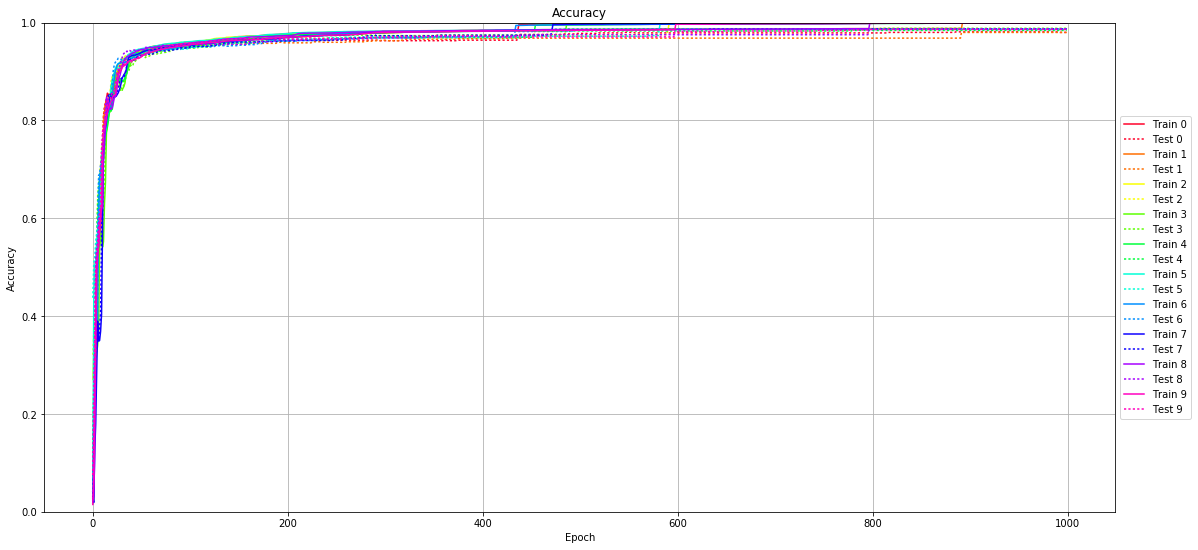

In [17]:
plot_acc(history)

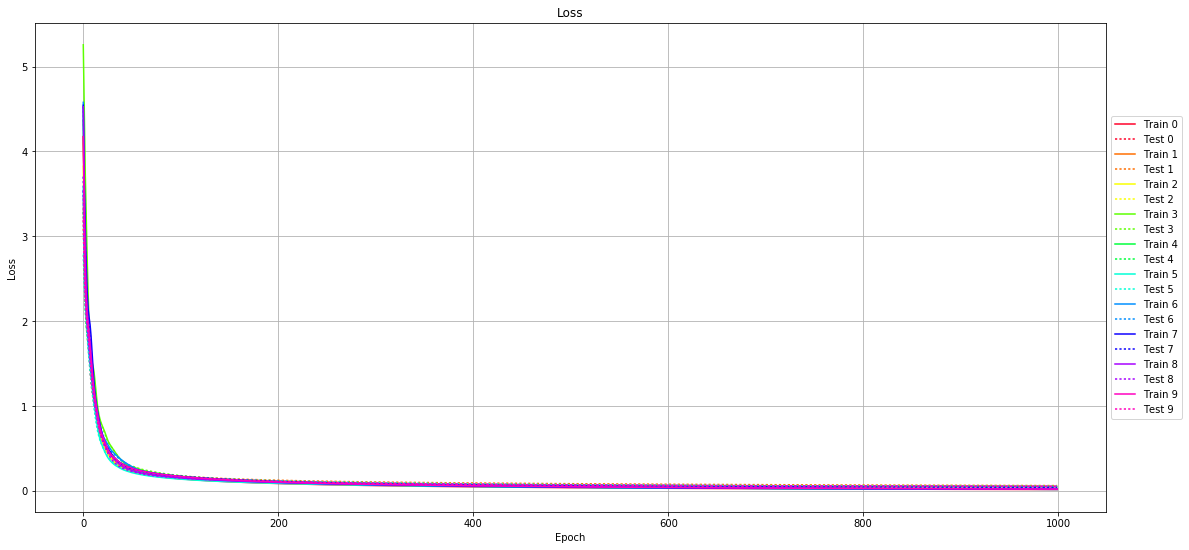

In [18]:
plot_loss(history)

In [19]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


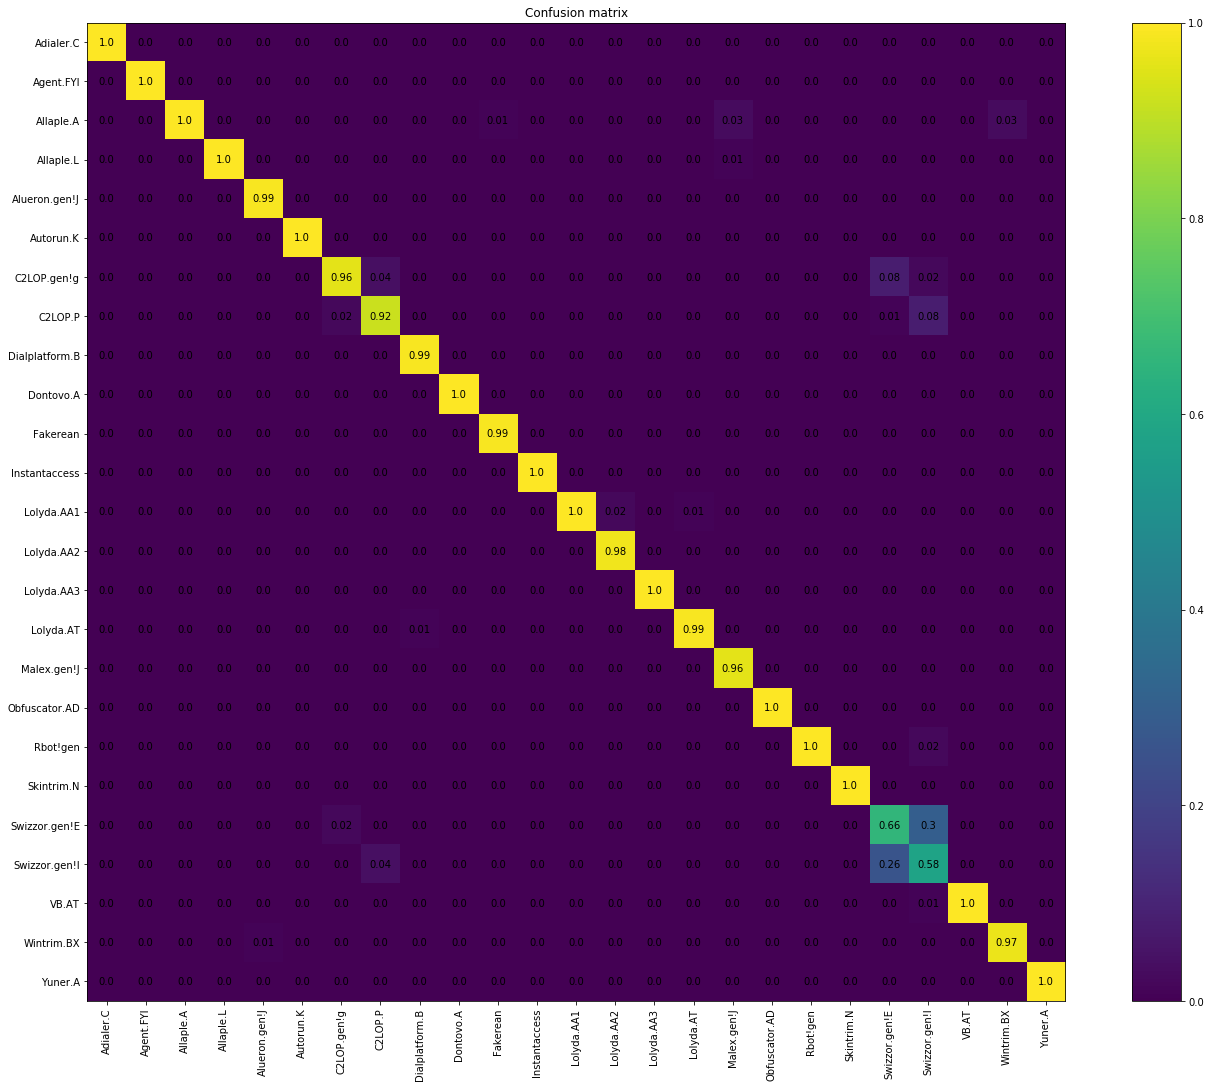

In [20]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()